In [1]:
from IPython.display import display, HTML

display(HTML("""
<div style="
    display: flex;
    flex-direction: column;
    justify-content: center;
    align-items: center;
    height: 90vh;
    text-align: center;
">

  <h1 style="margin-bottom: 40px;">
    Housing Price Analysis and Data Preparation
  </h1>

  <p style="font-size: 18px; margin-bottom: 80px;">
    Exploratory Data Analysis and Feature Engineering
  </p>

  <p style="font-size: 16px; margin-bottom: 40px;">
    Sara Alsiyat
  </p>

  <p style="font-size: 16px; margin-bottom: 10px;">
    Week 3 – MSDS 422
  </p>

  <p style="font-size: 16px; margin-bottom: 80px;">
    Practical Machine Learning
  </p>

  <p style="font-size: 16px;">
    January 2026
  </p>

</div>

<div style="page-break-after: always;"></div>
"""))

# Introduction

This project focuses on understanding housing prices in Ames, Iowa by carefully exploring and preparing the data before building regression-based prediction models. Rather than jumping directly into modeling, I spend time examining how the data are structured, how different features behave, and where potential issues—such as missing values or extreme prices—appear. Based on my experience, these early steps often have a greater impact on model quality than the choice of modeling technique itself.

The dataset comes from the Ames housing study created by Dean De Cock and contains detailed information about residential homes, including size, quality, age, and location. Throughout this project, preprocessing is treated as a thoughtful, domain-driven process rather than a mechanical checklist. Features are cleaned, combined, and transformed in ways that reflect real housing characteristics, helping ensure that later modeling decisions are based on meaningful structure rather than artifacts of poor data preparation (De Cock 2011).

Building on this foundation, the project applies ordinary least squares (OLS) regression models to estimate house prices and evaluate how different features contribute to price variation. Emphasis is placed on interpretability, stability, and careful handling of extreme values rather than on model complexity. Accurate housing price estimates are important to many stakeholders, including home buyers and sellers, real estate professionals, lenders, investors, and policymakers, who rely on these insights to support financial and planning decisions.

### Dataset Versioning and Workflow Overview
To ensure reproducibility and clarity throughout the analysis, multiple versions of the dataset are maintained. These include the raw data, cleaned data, feature-engineered data, and final modeling datasets. This structure makes preprocessing decisions transparent and prevents accidental reuse of intermediate datasets in later modeling steps.

# Data Load and Libraries

In this section, I import the libraries needed for data analysis, visualization, and preprocessing, and load the training and test datasets provided for the Kaggle competition. These tools support the exploratory analysis and data preparation steps that follow.

## Setup and Global Configuration

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["IPYTHONDIR"] = os.path.expanduser("~/.ipython")

import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew

from IPython.display import display, HTML

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone


# ----------------------------
# Global target
# ----------------------------
htarget_column = "SalePrice"


# ----------------------------
# Northwestern colors + table helper
# ----------------------------
nu_purple = "#4E2A84"
nu_gray = "#E6E6E6"
nu_light_purple = "#B6ACD1"
missing_cmap = ListedColormap([nu_light_purple, nu_gray])

def nu_style_table(df, caption=None):
    return (
        df.style
        .set_table_styles(
            [
                {
                    "selector": "table",
                    "props": [
                        ("width", "600px"),
                        ("margin", "0 auto"),
                        ("border-collapse", "collapse"),
                    ],
                },
                {
                    "selector": "caption",
                    "props": [
                        ("caption-side", "top"),
                        ("font-weight", "bold"),
                        ("font-size", "14px"),
                        ("text-align", "center"),
                        ("white-space", "nowrap"),
                        ("padding-bottom", "6px"),
                    ],
                },
                {
                    "selector": "th",
                    "props": [
                        ("background-color", nu_purple),
                        ("color", "white"),
                        ("font-weight", "bold"),
                        ("text-align", "center"),
                        ("padding", "6px"),
                    ],
                },
                {
                    "selector": "td",
                    "props": [
                        ("background-color", nu_gray),
                        ("text-align", "center"),
                        ("padding", "6px"),
                    ],
                },
            ]
        )
        .set_caption(caption if caption else "")
    )

# ----------------------------
# HouseStyle helpers
# ----------------------------
def floors_from_housestyle(style):
    """Convert HouseStyle category into an approximate number of floors."""
    if pd.isna(style):
        return np.nan

    style = str(style)
    mapping = {
        "1Story": 1.0,
        "2Story": 2.0,
        "1.5Fin": 1.5,
        "1.5Unf": 1.5,
        "2.5Fin": 2.5,
        "2.5Unf": 2.5,
        "SFoyer": 1.0,
        "SLvl": 1.0,
    }
    return mapping.get(style, np.nan)


def floor_finish_status(style):
    """Summarize HouseStyle into a clean floor finish status."""
    if pd.isna(style):
        return "Unknown"

    style = str(style)

    if style == "1Story":
        return "SingleStory"
    if style in ["2Story", "2.5Fin"]:
        return "MultiStoryFinished"
    if style == "1.5Fin":
        return "MultiStoryPartiallyFinished"
    if style in ["1.5Unf", "2.5Unf"]:
        return "MultiStoryUnfinished"
    if style in ["SFoyer", "SLvl"]:
        return "SplitLevel"
    return "Other"


# ----------------------------
# Metrics + evaluation helpers
# ----------------------------
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


def evaluate_on_holdout(model, X_tr, y_tr, X_va, y_va):
    """Train on (X_tr,y_tr), evaluate on train/val."""
    model.fit(X_tr, y_tr)

    y_tr_pred = model.predict(X_tr)
    y_va_pred = model.predict(X_va)

    return {
        "Train RMSE": rmse(y_tr, y_tr_pred),
        "Val RMSE": rmse(y_va, y_va_pred),
        "Train MAE": float(mean_absolute_error(y_tr, y_tr_pred)),
        "Val MAE": float(mean_absolute_error(y_va, y_va_pred)),
        "Train R²": float(r2_score(y_tr, y_tr_pred)),
        "Val R²": float(r2_score(y_va, y_va_pred)),
    }


def cv_summary(model, X_data, y_data, model_name):
    """Standard CV summary on the given target scale."""
    cv_results = cross_validate(
        model,
        X_data,
        y_data,
        cv=cv,
        scoring=scoring
    )
    return pd.DataFrame({
        "Model": [model_name],
        "CV RMSE (mean)": [-cv_results["test_rmse"].mean()],
        "CV MAE (mean)":  [-cv_results["test_mae"].mean()],
        "CV R² (mean)":   [cv_results["test_r2"].mean()],
    }).round(4)


def cv_summary_dollar_from_dollar_target(model, X_data, y_data, model_name):
    out = cv_summary(model, X_data, y_data, model_name).copy()

    # Rename standard columns -> dollar columns
    if "CV RMSE (mean)" in out.columns:
        out["CV RMSE ($) (mean)"] = out["CV RMSE (mean)"]
    if "CV MAE (mean)" in out.columns:
        out["CV MAE ($) (mean)"] = out["CV MAE (mean)"]
    if "CV R² (mean)" in out.columns:
        out["CV R² ($) (mean)"] = out["CV R² (mean)"]

    out = out[["Model", "CV RMSE ($) (mean)", "CV MAE ($) (mean)", "CV R² ($) (mean)"]]

    return out.round(4)



def cv_summary_dollar_from_log_target(model, X_data, y_data_dollar, model_name):
    rmses, maes, r2s = [], [], []

    for train_idx, val_idx in cv.split(X_data):
        X_tr, X_va = X_data.iloc[train_idx], X_data.iloc[val_idx]
        y_tr_d, y_va_d = y_data_dollar.iloc[train_idx], y_data_dollar.iloc[val_idx]

        # Train on log target
        y_tr_log = np.log1p(y_tr_d)
        y_va_log = np.log1p(y_va_d)

        m = clone(model)
        m.fit(X_tr, y_tr_log)

        # Predict log, convert to dollars
        y_va_pred_log = m.predict(X_va)
        y_va_pred_d = np.expm1(y_va_pred_log)

        rmses.append(np.sqrt(mean_squared_error(y_va_d, y_va_pred_d)))
        maes.append(mean_absolute_error(y_va_d, y_va_pred_d))
        r2s.append(r2_score(y_va_d, y_va_pred_d))

    return pd.DataFrame({
        "Model": [model_name],
        "CV RMSE ($) (mean)": [np.mean(rmses)],
        "CV MAE ($) (mean)":  [np.mean(maes)],
        "CV R² ($) (mean)":   [np.mean(r2s)],
    }).round(4)


def evaluate_dollar_scale(y_true_log, y_pred_log):
    """Convert log scale back to dollars and compute metrics (for holdout)."""
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return {
        "RMSE ($)": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "R² ($)": float(r2_score(y_true, y_pred)),
    }


# ----------------------------------------------------------
# pick correct test matrix per model
# ----------------------------------------------------------
def get_test_matrix(test_source, cols):
    if test_source == "encoded":
        Xt = df_test_encoded.reindex(columns=cols)
        Xt = Xt.fillna(Xt.median(numeric_only=True))
        return Xt

    if test_source == "enhanced":
        Xt = X_test_enhanced.reindex(columns=cols)
        Xt = Xt.fillna(Xt.median(numeric_only=True))
        return Xt

    if test_source == "enhanced_selected":
        Xt = X_test_enhanced.reindex(columns=cols)
        Xt = Xt.fillna(Xt.median(numeric_only=True))
        return Xt

    raise ValueError(f"Unknown test_source: {test_source}")
# ----------------------------
# Plots + display helpers
# ----------------------------

def plot_on_axis(ax, df, col, ftype):
    if col not in df.columns:
        ax.axis("off")
        return

    if ftype == "numeric":
        ax.scatter(df[col], df["SalePrice"], alpha=0.35, color=nu_purple)
        ax.set_ylabel("SalePrice")

    elif ftype in ["binary", "discrete"]:
        means = df.groupby(col)["SalePrice"].mean()
        ax.bar(means.index.astype(str), means.values, color=nu_purple)

    elif ftype == "categorical":
        sns.boxplot(
            data=df,
            x=col,
            y="SalePrice",
            ax=ax,
            boxprops=dict(facecolor=nu_light_purple, edgecolor=nu_purple)
        )

    ax.set_title(col)
    ax.grid(axis="y", linestyle="--", alpha=0.4)

def plot_actual_vs_pred(y_true, y_pred, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.35, color=nu_purple)

    mn = min(float(np.min(y_true)), float(np.min(y_pred)))
    mx = max(float(np.max(y_true)), float(np.max(y_pred)))

    plt.plot([mn, mx], [mn, mx], linestyle="--", color=nu_gray)
    plt.xlabel("Actual SalePrice")
    plt.ylabel("Predicted SalePrice")
    plt.title(title)
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()


def display_side_by_side(table_left, table_right):
    display(HTML(
        f"""
        <div style="display:flex; gap:40px; align-items:flex-start;">
            <div style="flex:1;">{table_left.to_html()}</div>
            <div style="flex:1;">{table_right.to_html()}</div>
        </div>
        """
    ))

def sanitize_filename(name: str) -> str:
    name = name.lower().strip()
    name = re.sub(r"[^a-z0-9]+", "_", name)
    name = re.sub(r"_+", "_", name).strip("_")
    return name

def save_submission(preds_dollar, model_name, output_dir="output"):
    preds_dollar = np.asarray(preds_dollar)

    preds_dollar = np.clip(preds_dollar, 0, None)

    os.makedirs(output_dir, exist_ok=True)

    fname = f"submission_{sanitize_filename(model_name)}.csv"
    path = os.path.join(output_dir, fname)

    submission = pd.DataFrame({
        "Id": htest_df["Id"],
        "SalePrice": preds_dollar
    })

    submission.to_csv(path, index=False)
    print(f"Saved: {path}")
    return path

## Load Training and Test Data

In [3]:
htrain_df = pd.read_csv(
    "house-prices-advanced-regression-techniques/train.csv"
)

htest_df = pd.read_csv(
    "house-prices-advanced-regression-techniques/test.csv"
)

## Dataset Overview

In [4]:
hdataset_summary = pd.DataFrame(
    {
        "Dataset": ["Training", "Test"],
        "Rows": [htrain_df.shape[0], htest_df.shape[0]],
        "Columns": [htrain_df.shape[1], htest_df.shape[1]],
    }
)

display(
    nu_style_table(
        hdataset_summary,
        caption="Dataset Dimensions (Training vs Test)"
    )
)

The training dataset includes the target variable, SalePrice, which is the value we want to predict. The test dataset contains the same feature columns but does not include SalePrice, since it is used only for generating predictions. This is why the test dataset has one fewer column than the training dataset.

# Data Presentation

In this section, I take a first look at how the dataset is organized and what information is available. The goal here is not to analyze relationships yet, but to understand what types of features exist and how they will need to be handled later during preprocessing and modeling.

## Dataset Structure and Data Types
Before looking at individual records, I first examine the structure of the dataset, including the number of features, their data types, and whether missing values are present.

In [5]:
hstructure_summary = pd.DataFrame(
    {
        "Data Type": htrain_df.dtypes,
        "Non-Null Count": htrain_df.notnull().sum(),
        "Missing Count": htrain_df.isnull().sum(),
    }
).T

display(
    nu_style_table(
        hstructure_summary,
        caption="Dataset Structure Overview"
    )
)

This table provides an overview of the dataset structure, including data types and missing values for each variable. It shows that while most features are complete, some features have a high number of missing values, which will need to be addressed during preprocessing.

## Initial Data Snapshot
Next, I inspect the first few rows of the training dataset to get a concrete sense of how the data are organized and what typical observations look like.

In [6]:
display(
    nu_style_table(
        htrain_df.head(),
        caption="First Five Rows of the Training Dataset"
    )
)

The first five observations give a quick look at how the dataset is structured and how detailed it is. Each row corresponds to one home sale, and the columns describe different aspects of the property, such as size, quality, location, and sale details. Some features, like Alley and PoolQC, contain missing values, which suggests that missing entries often mean a feature does not exist rather than indicating a data error. This is important to keep in mind during preprocessing.

## Summary Statistics
To better understand the distributions of both numerical and categorical features, I compute summary statistics for the training dataset.

In [7]:
hsummary_table = htrain_df.describe(include="all")

display(
    nu_style_table(
        hsummary_table.round(2),
        caption="Summary Statistics for Training Dataset"
    )
)

This table provides a high-level statistical summary of all features in the training dataset. It highlights differences in scale, central tendency, and spread across numerical features, as well as the presence of missing values in several features. Reviewing these statistics helps identify skewed distributions, extreme values, and features that may require special handling during preprocessing and feature engineering.

## Separation of Target, Numerical, and Categorical features

Before moving into exploratory analysis, I separate the target variable from the predictors and identify which features are numerical and which are categorical. This helps ensure that each feature type is handled appropriately during visualization, preprocessing, and modeling.

In [8]:
hnumeric_features = (
    htrain_df
    .select_dtypes(include=["int64", "float64"])
    .columns
    .drop(htarget_column)
)

hcategorical_features = htrain_df.select_dtypes(
    include=["object", "category"]
).columns

print("Number of numerical features:", len(hnumeric_features))
print("Number of categorical features:", len(hcategorical_features))

Number of numerical features: 37
Number of categorical features: 43


This separation helps ensure that each type of variable is explored and processed appropriately in later steps, such as visual diagnostics, missing value handling, and encoding.

# Exploratory Data Analysis (EDA) of the Initial Dataset

In this section, I explore the dataset to understand its overall structure and patterns, starting with a closer look at house prices and then moving to other features.

## Target distribution

I first examine how SalePrice is distributed across homes in the training dataset.

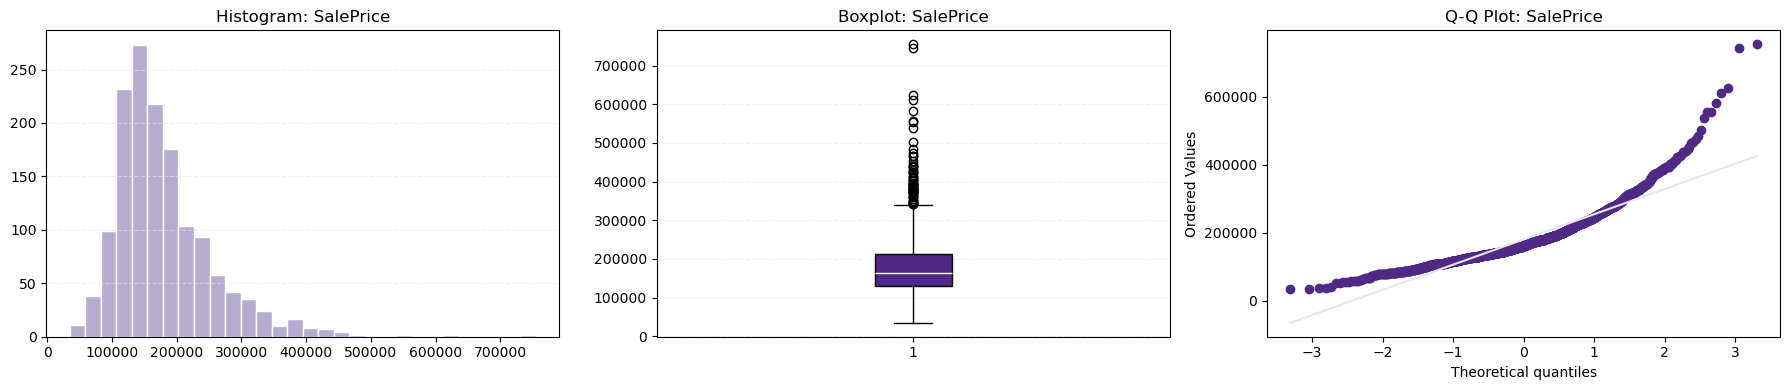

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Histogram
axes[0].hist(
    htrain_df["SalePrice"].dropna(),
    bins=30,
    color=nu_light_purple,
    edgecolor="white",
)
axes[0].set_title(f"Histogram: SalePrice")
axes[0].grid(axis="y", color=nu_gray, linestyle="--", alpha=0.6)
# Boxplot
axes[1].boxplot(
    htrain_df["SalePrice"].dropna(),
    patch_artist=True,
    boxprops=dict(facecolor=nu_purple),
    medianprops=dict(color="white"),
)
axes[1].set_title(f"Boxplot: SalePrice")
axes[1].grid(axis="y", color=nu_gray, linestyle="--", alpha=0.6)
# Q-Q plot 
stats.probplot(
    htrain_df["SalePrice"].dropna(),
    dist="norm",
    plot=axes[2]
)
axes[2].get_lines()[0].set_color(nu_purple)
axes[2].get_lines()[1].set_color(nu_gray)
axes[2].set_title(f"Q-Q Plot: SalePrice")
plt.tight_layout()
plt.show()

The distribution of sale prices is right-skewed. Most homes cluster in the lower price range, while a small number of very expensive properties extend the distribution to the right. This indicates that housing prices are not evenly distributed, which is an important consideration for later modeling and evaluation.

## Missing Values Heatmap
Next, I examine missing values to understand whether they appear randomly or follow clear structural patterns.

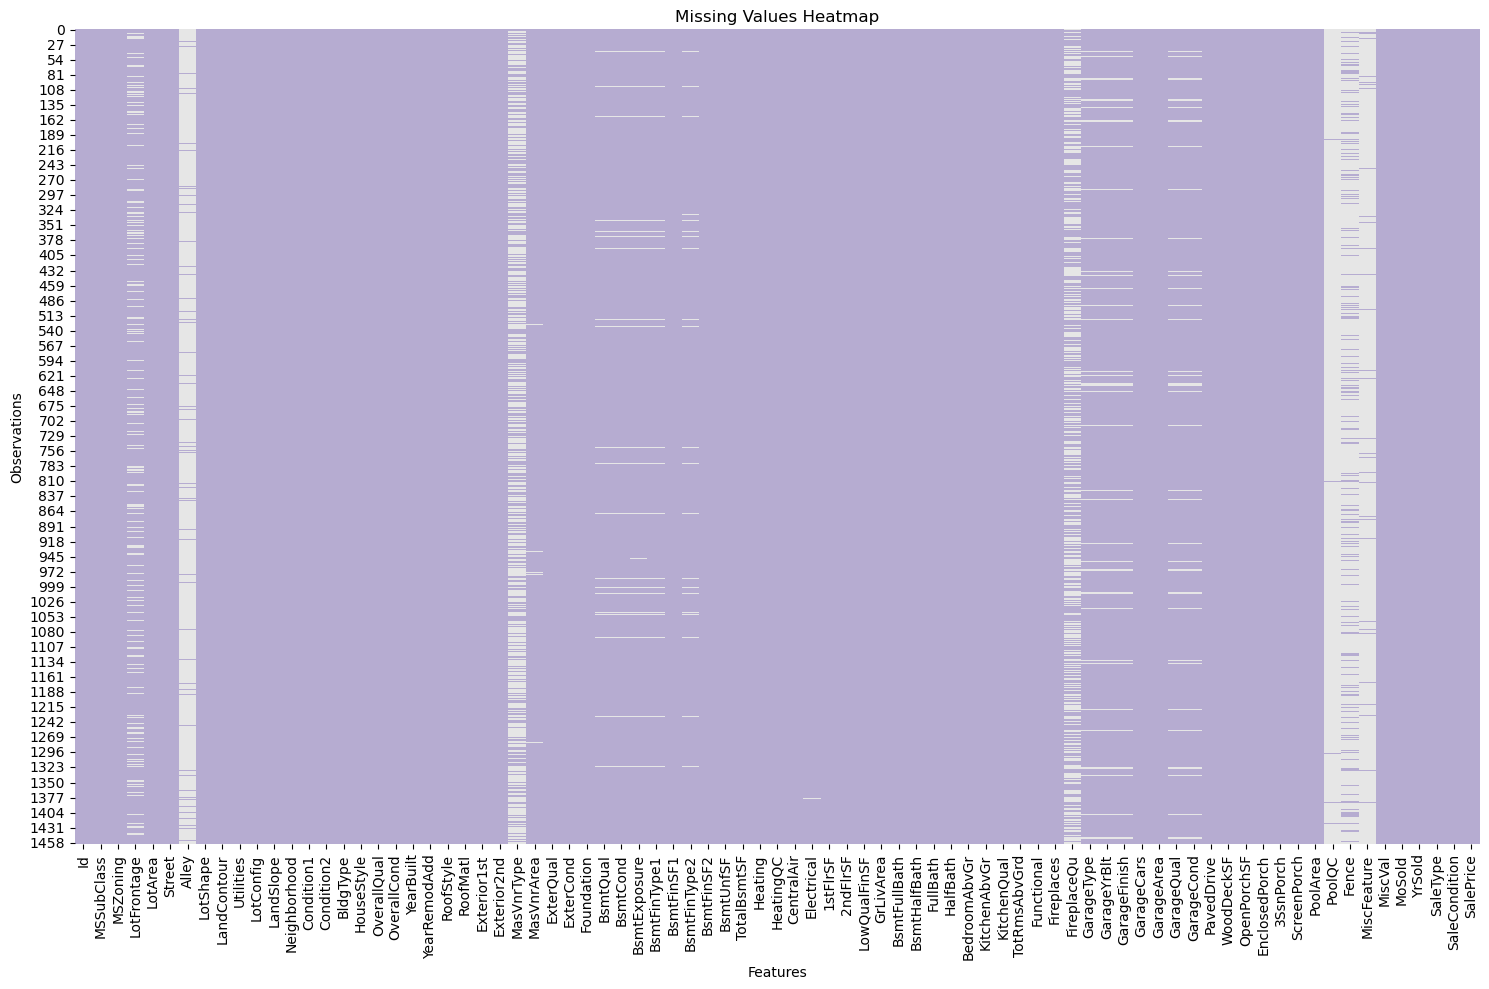

In [10]:
plt.figure(figsize=(15, 10))
sns.heatmap(
    htrain_df.isnull(),
    cbar=False,
    cmap=missing_cmap
)

plt.title("Missing Values Heatmap")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.tight_layout()
plt.show()

Missing values cluster by feature groups rather than appearing randomly across observations. This suggests that missingness often represents the absence of a feature (such as no pool, no alley access, or no garage) rather than data errors. These patterns inform later preprocessing decisions.

## Numeric Feature Range Check
For a focused numeric analysis, I first select a set of ten numeric features that are likely related to sale price, including measures of size, quality, and time. I review their ranges to ensure the values are reasonable and consistent with real housing data. This step helps confirm that extreme values reflect valid homes rather than data errors and provides context before examining distributions and outliers.

In [11]:
selected_hnumeric = [
    "GrLivArea",
    "TotalBsmtSF",
    "GarageArea",
    "1stFlrSF",
    "YearBuilt",
    "LotArea",
    "OverallQual",
    "GarageCars",
    "YearRemodAdd",
    "SalePrice"
]

hrange_check = htrain_df[selected_hnumeric].agg(
    ["min", "max", "mean"]
).round(2)

nu_style_table(
    hrange_check,
    caption="Range Check for Selected Numeric Features"
)

The ranges of the selected numeric features are reasonable and align with real housing characteristics. Size-related features span a wide range, reflecting differences between small and large homes, while quality and garage capacity stay within expected bounds. Year-based features fall within realistic construction and renovation periods, suggesting no obvious data errors in these variables.

## Ordinal vs Continuous Numeric features
After examining missing values, I review numeric features with a small number of distinct values to identify those that represent ordered levels rather than true continuous measurements.

In [12]:
hordinal_candidates = {
    col: htrain_df[col].nunique()
    for col in hnumeric_features
    if (htrain_df[col].nunique() < 15) and (not col.endswith("_Missing"))
}

hordinal_table = (
    pd.DataFrame({"Feature": list(hordinal_candidates.keys()),
                  "Unique Levels": list(hordinal_candidates.values())})
    .sort_values("Unique Levels")
    .set_index("Feature")
    .T
)
hordinal_table.index = ["Unique Levels"]

display(
    nu_style_table(
        hordinal_table,
        caption="Potential Ordinal Numeric Features (Low Unique Levels)"
    )
)

These features have only a few unique values, which suggests they represent ordered categories or counts rather than continuous quantities. Treating them as ordinal features better reflects their real-world meaning and avoids imposing artificial numerical distance.

## Numeric diagnostics
Using the same selected numeric features, I examine their distributions in more detail. For each feature, I review the histogram, boxplot, and Q–Q plot to assess skewness, outliers, and departures from normality. This diagnostic step helps identify features that may require special treatment during preprocessing or modeling.

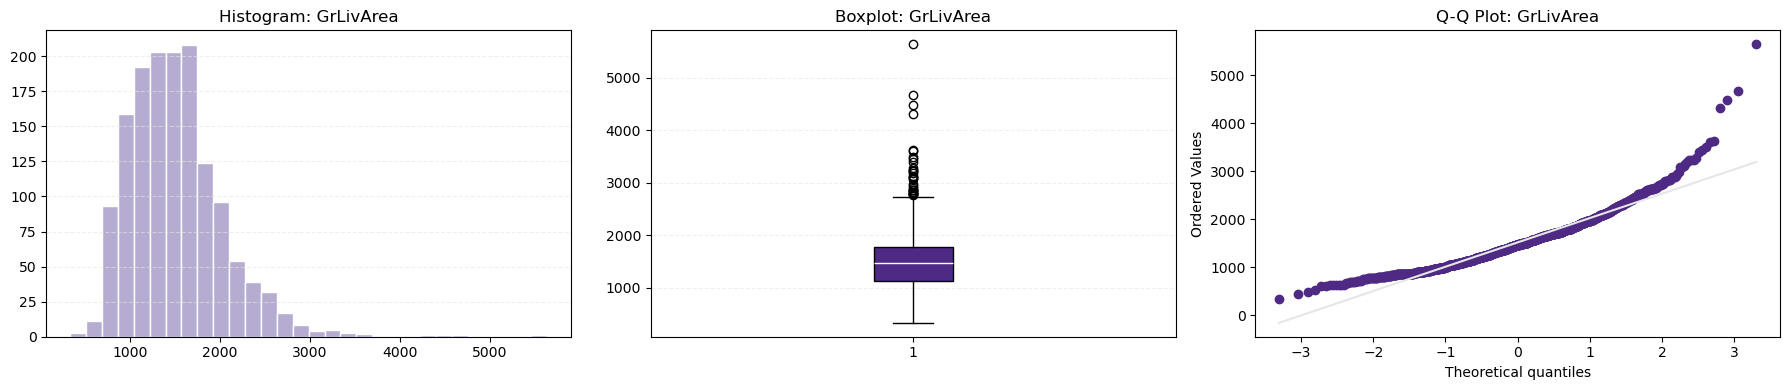

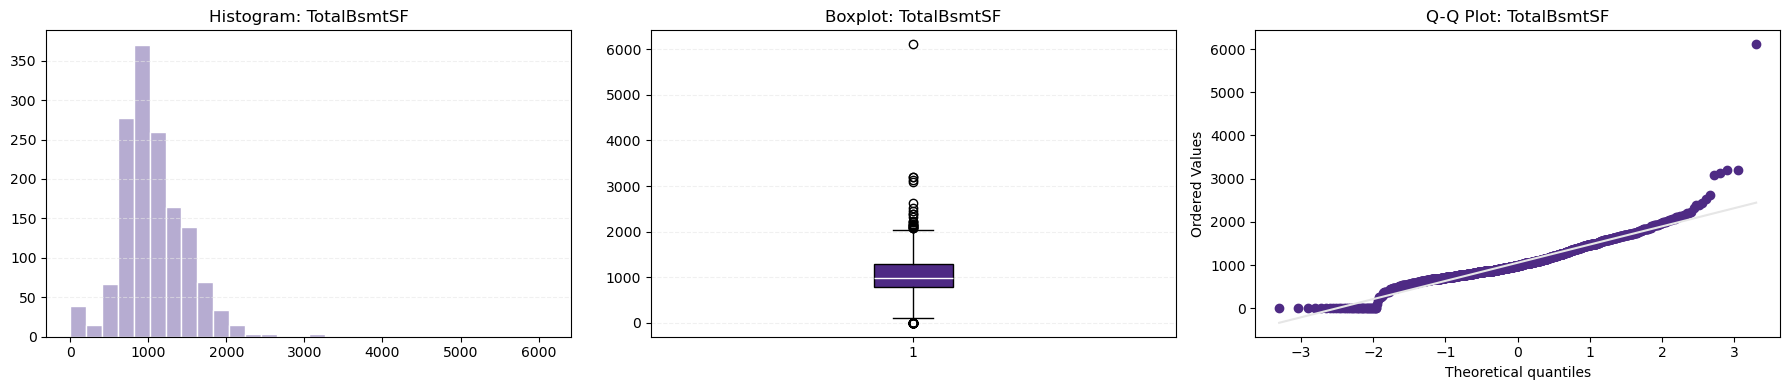

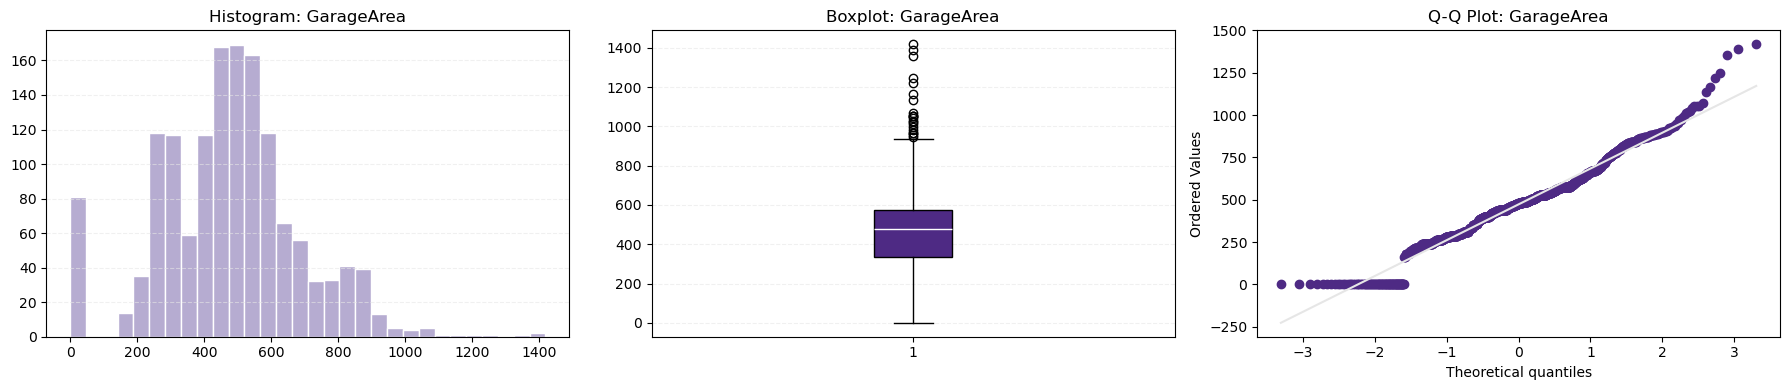

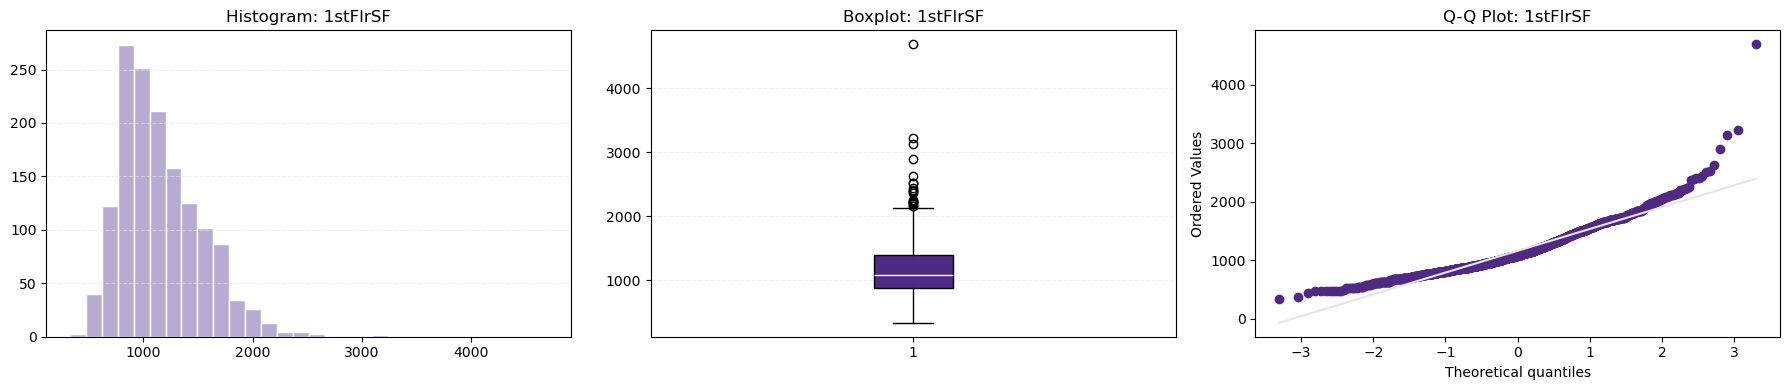

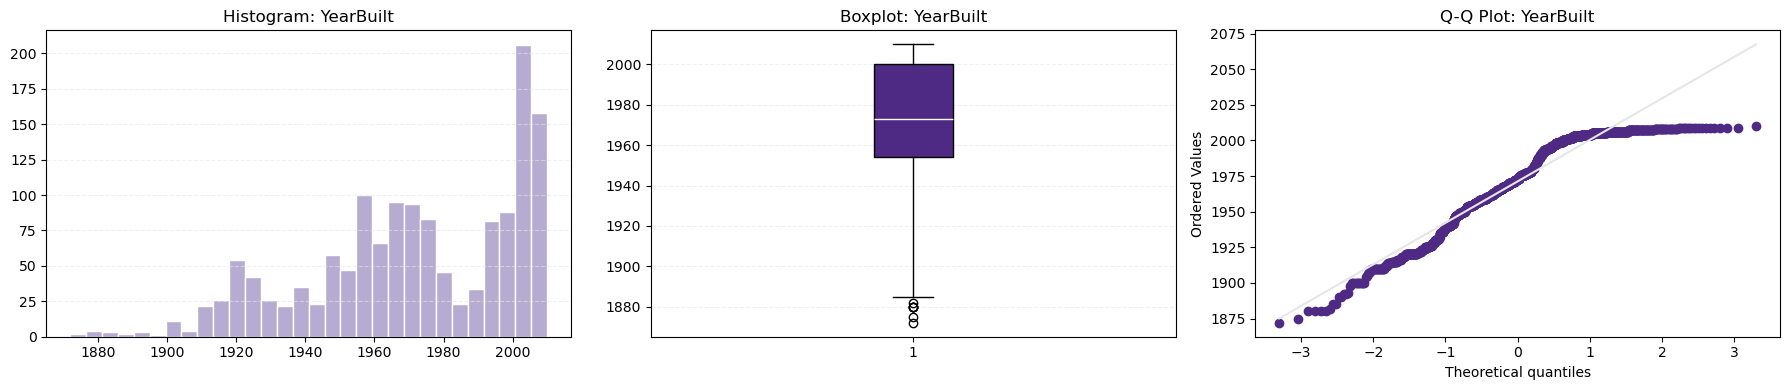

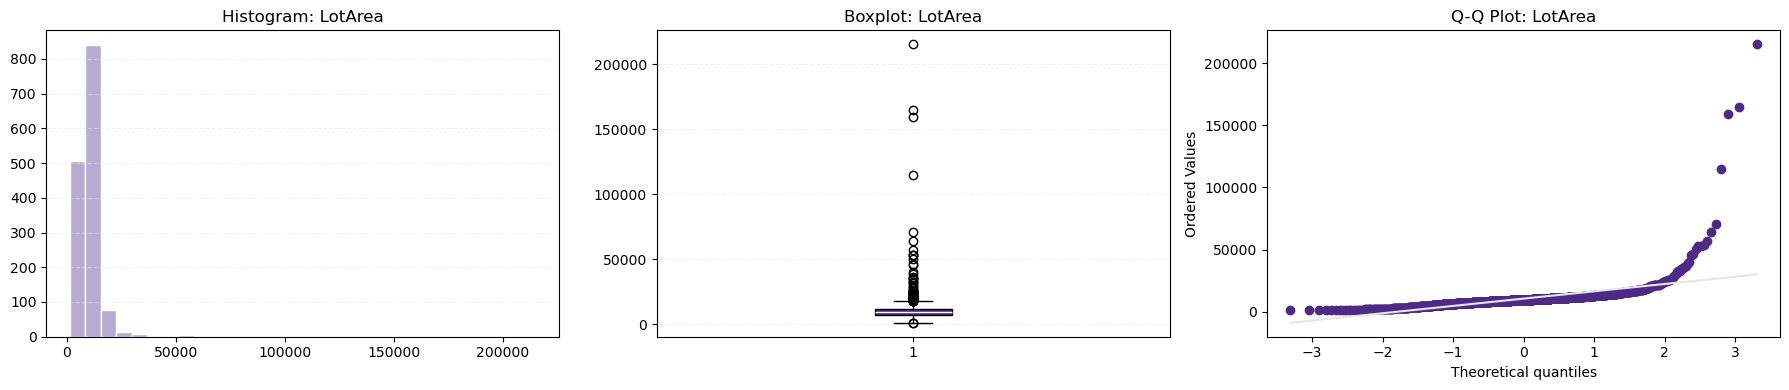

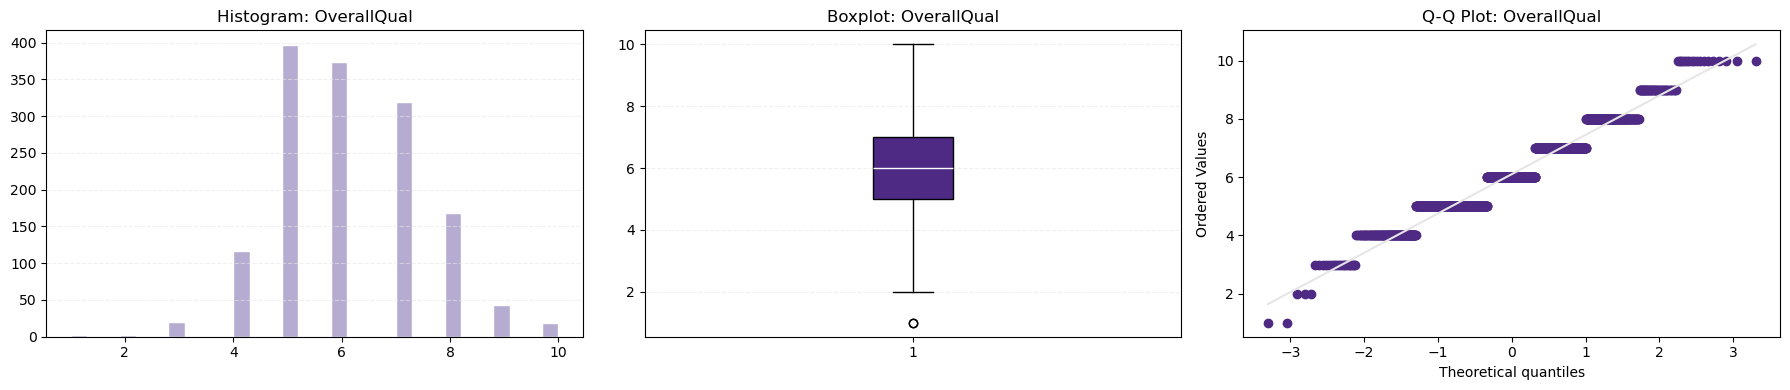

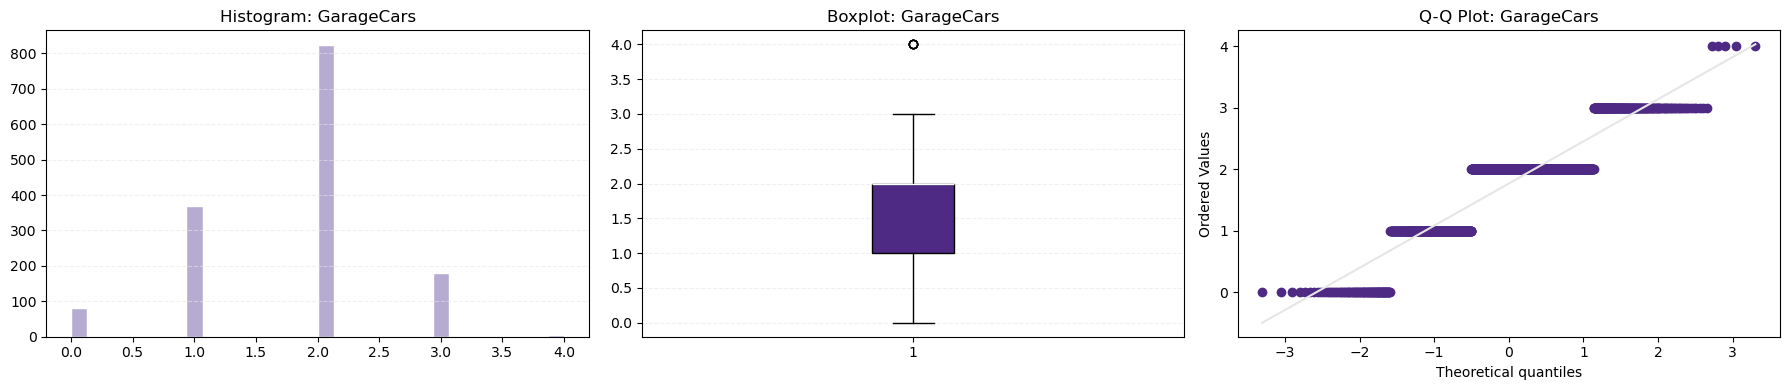

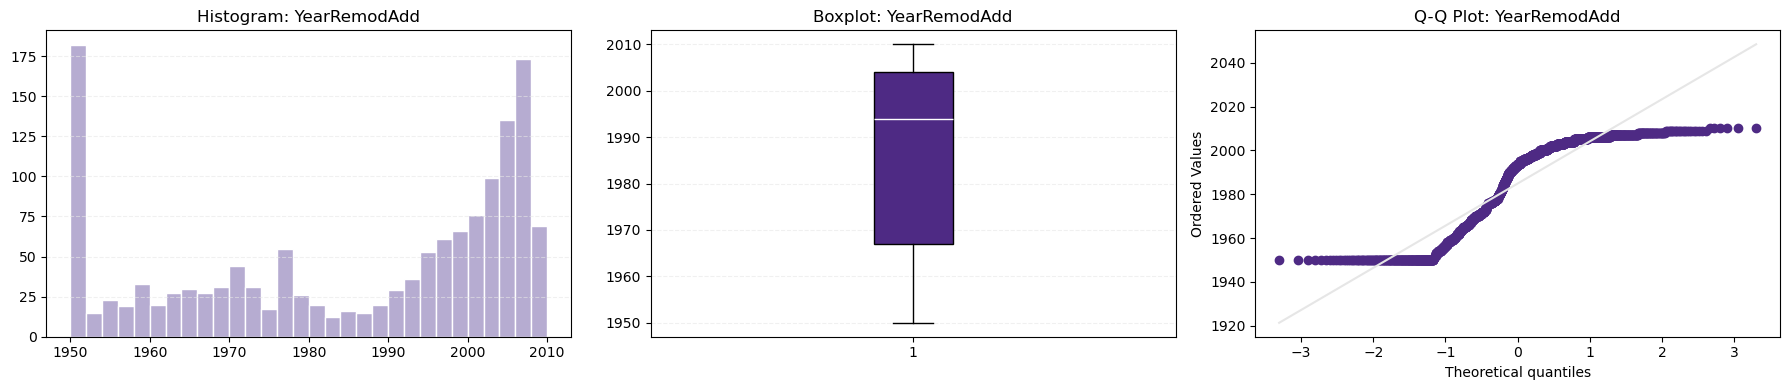

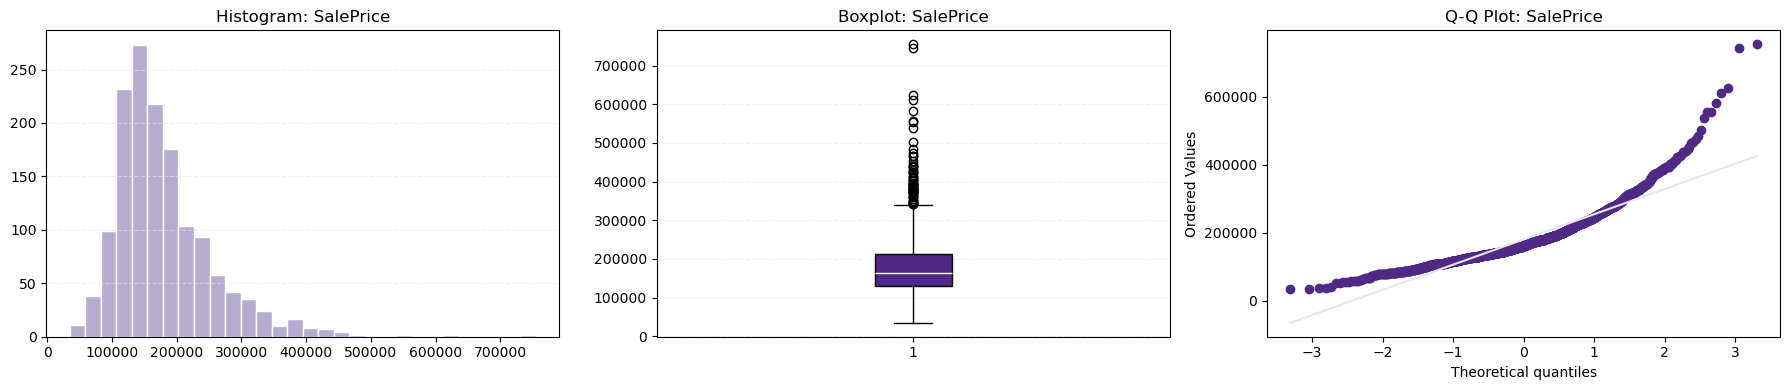

In [13]:

for col in selected_hnumeric:
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # Histogram
    axes[0].hist(
        htrain_df[col].dropna(),
        bins=30,
        color=nu_light_purple,
        edgecolor="white",
    )
    axes[0].set_title(f"Histogram: {col}")
    axes[0].grid(axis="y", color=nu_gray, linestyle="--", alpha=0.6)

    # Boxplot
    axes[1].boxplot(
        htrain_df[col].dropna(),
        patch_artist=True,
        boxprops=dict(facecolor=nu_purple),
        medianprops=dict(color="white"),
    )
    axes[1].set_title(f"Boxplot: {col}")
    axes[1].grid(axis="y", color=nu_gray, linestyle="--", alpha=0.6)

    # Q-Q plot 
    stats.probplot(
        htrain_df[col].dropna(),
        dist="norm",
        plot=axes[2]
    )
    axes[2].get_lines()[0].set_color(nu_purple)
    axes[2].get_lines()[1].set_color(nu_gray)
    axes[2].set_title(f"Q-Q Plot: {col}")

    plt.tight_layout()
    plt.show()

Most size-related features, such as living area, basement area, lot size, and garage area, are clearly right-skewed and contain several extreme values. The Q–Q plots confirm strong deviations from normality. In contrast, year-based features show clustering around specific construction and renovation periods rather than smooth continuous distributions. These patterns suggest that assuming normality would be inappropriate and that robust modeling approaches or transformations may be required.

## Correlation Analysis of Numerical Features

Next, I use a correlation heatmap for the same selected numeric features to see which ones move together and which ones relate most to SalePrice. The correlation heatmap summarizes linear relationships among the selected numeric features and helps identify redundancy before feature engineering.

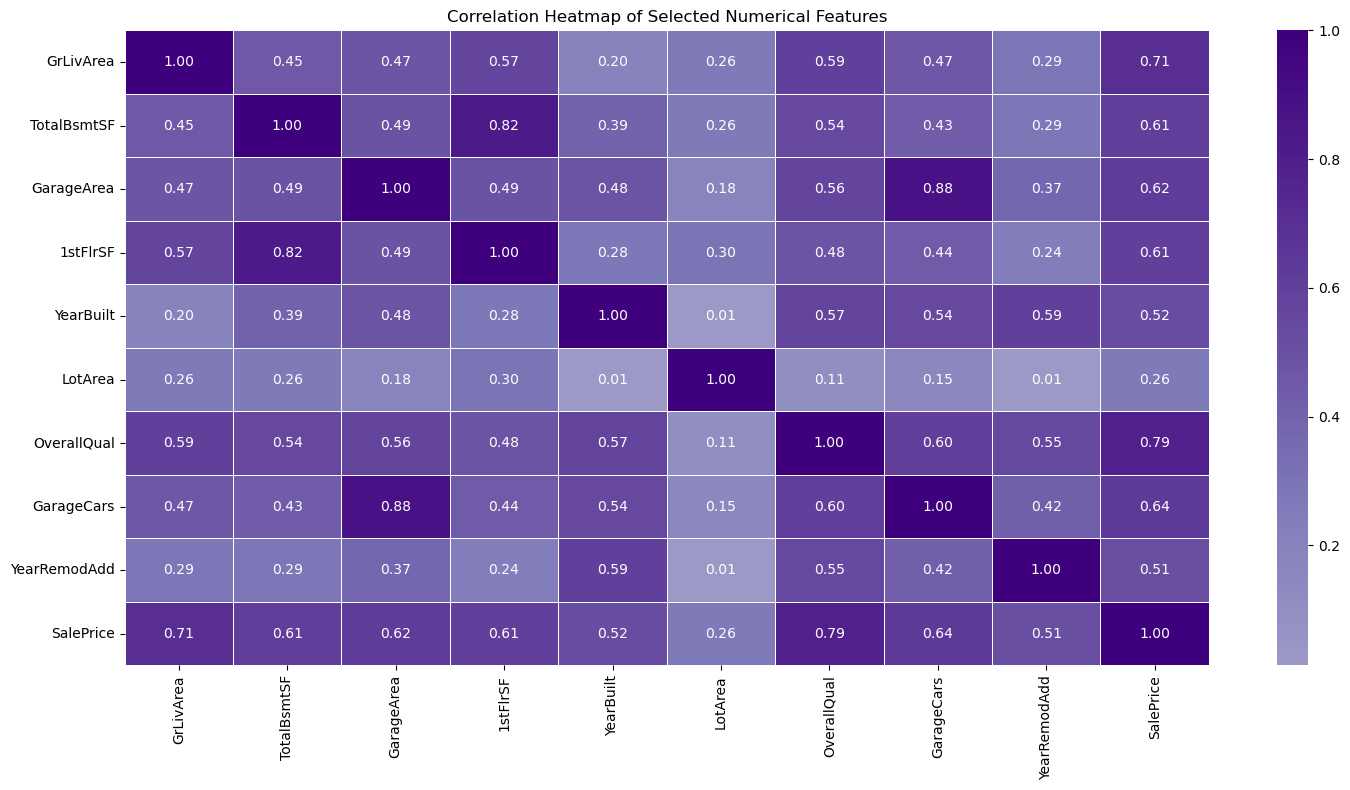

In [14]:
plt.figure(figsize=(15, 8))
sns.heatmap(
    htrain_df[selected_hnumeric].corr(),
    cmap="Purples",
    center=0,
    annot=True,  
    fmt=".2f",     
    linewidths=0.5
)

plt.title("Correlation Heatmap of Selected Numerical Features")
plt.tight_layout()
plt.show()

SalePrice has stronger positive relationships with quality and interior size features than with lot size. Features such as OverallQual, GrLivArea, GarageCars, and TotalBsmtSF show much higher correlations with price, while LotArea has a relatively weak relationship. In addition, many size-related features are highly correlated with each other, which shows redundancy in the raw data. This supports the need for feature engineering in later steps to combine related variables and reduce overlap between predictors.

## Living area vs SalePrice
To better understand the direct relationship between house size and price, I examine how above-ground living area relates to SalePrice using a scatterplot.

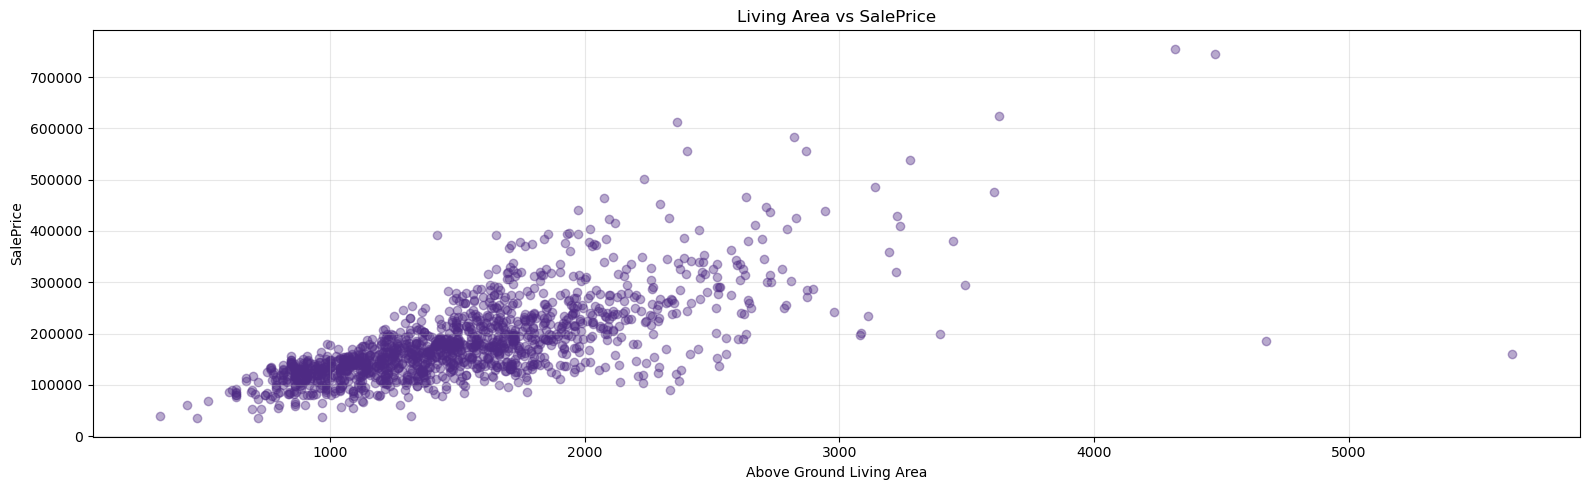

In [15]:
plt.figure(figsize=(16, 5))
plt.scatter(
    htrain_df["GrLivArea"],
    htrain_df["SalePrice"],
    alpha=0.4,
    color=nu_purple
)

plt.title("Living Area vs SalePrice")
plt.xlabel("Above Ground Living Area")
plt.ylabel("SalePrice")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

This scatterplot shows a clear positive relationship between living area and sale price. Larger homes generally sell for higher prices, although price variability increases for larger properties. A small number of extreme values are visible, suggesting that living area is an important factor but not the only driver of price.

## Categorical Feature Cardinality
I examine the number of unique categories in key categorical features to understand their complexity. This helps guide later encoding decisions and manage model complexity.

In [16]:
hcat_cardinality = pd.DataFrame({
    col: [htrain_df[col].nunique()]
    for col in hcategorical_features
}).T

hcat_cardinality.columns = ["Unique Levels"]

hcat_cardinality_top = (
    hcat_cardinality
    .sort_values("Unique Levels", ascending=False)
    .head(10)
    .T
)

display(
    nu_style_table(
        hcat_cardinality_top,
        caption="Categorical Features with Highest Cardinality"
    )
)

This table shows that a small number of categorical features have relatively high cardinality, especially neighborhood and exterior-related features. These variables contain many distinct levels, which means they can add useful detail but may also increase model complexity after encoding. This reinforces the need for careful encoding decisions in later preprocessing steps.

## Categorical distributions

For a selected set of important categorical features, I plot their most frequent categories (up to 10 when available) to understand how the data are distributed across groups.

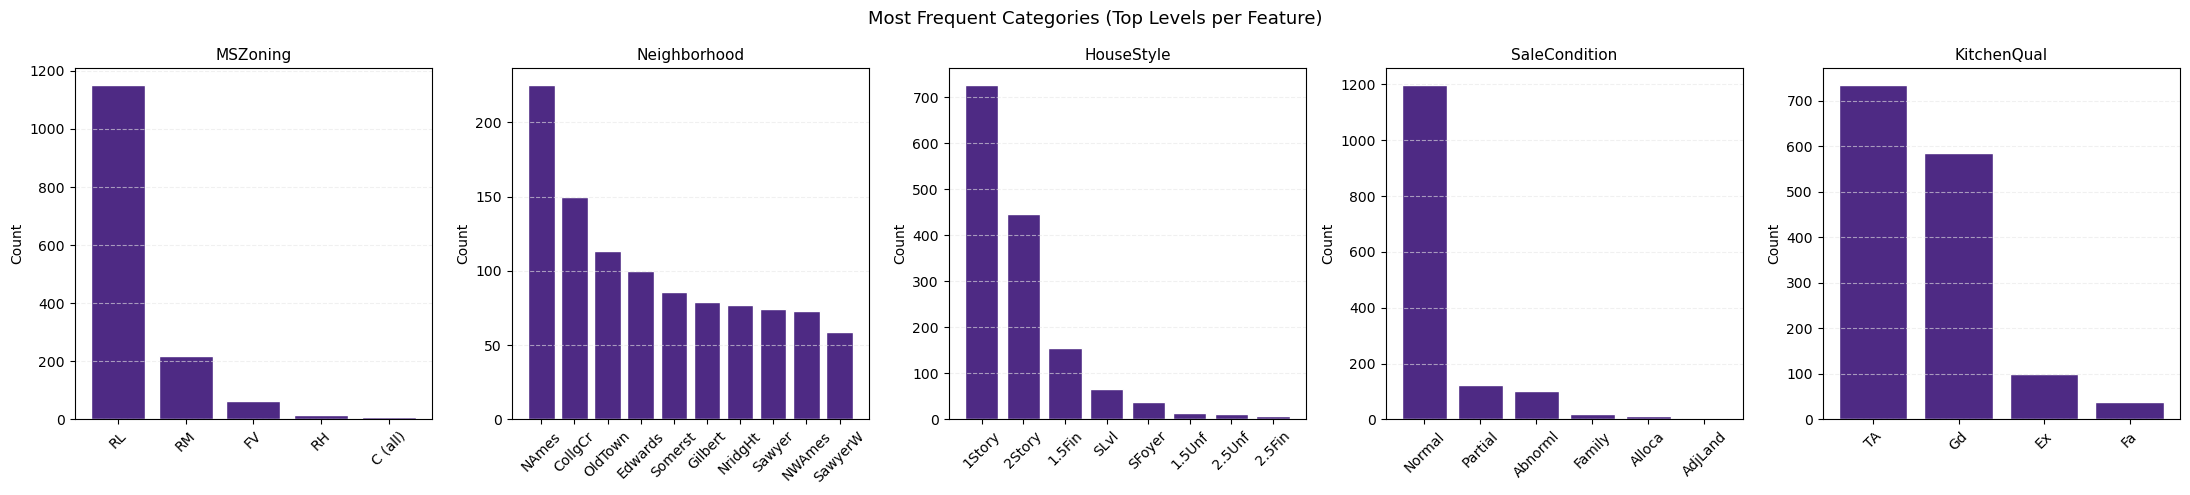

In [17]:
selected_hcategorical = [
    "MSZoning",
    "Neighborhood",
    "HouseStyle",
    "SaleCondition",
    "KitchenQual",
]

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(selected_hcategorical),
    figsize=(22, 5),
    sharey=False
)

for ax, col in zip(axes, selected_hcategorical):
    top_counts = htrain_df[col].value_counts(dropna=False).head(10)

    ax.bar(
        top_counts.index.astype(str),
        top_counts.values,
        color=nu_purple,
        edgecolor="white"
    )
    ax.set_title(col, fontsize=11)
    ax.set_xlabel("")
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=45)
    ax.grid(axis="y", color=nu_gray, linestyle="--", alpha=0.6)

plt.suptitle(
    "Most Frequent Categories (Top Levels per Feature)",
    fontsize=13
)
plt.tight_layout()
plt.show()

Several categorical features are dominated by a small number of levels. This imbalance is important to consider during encoding, as rare categories may contribute limited information or increase model complexity.

## Neighborhood Price Comparison
Finally, I compare house prices across the most common neighborhoods to understand how location relates to price differences.

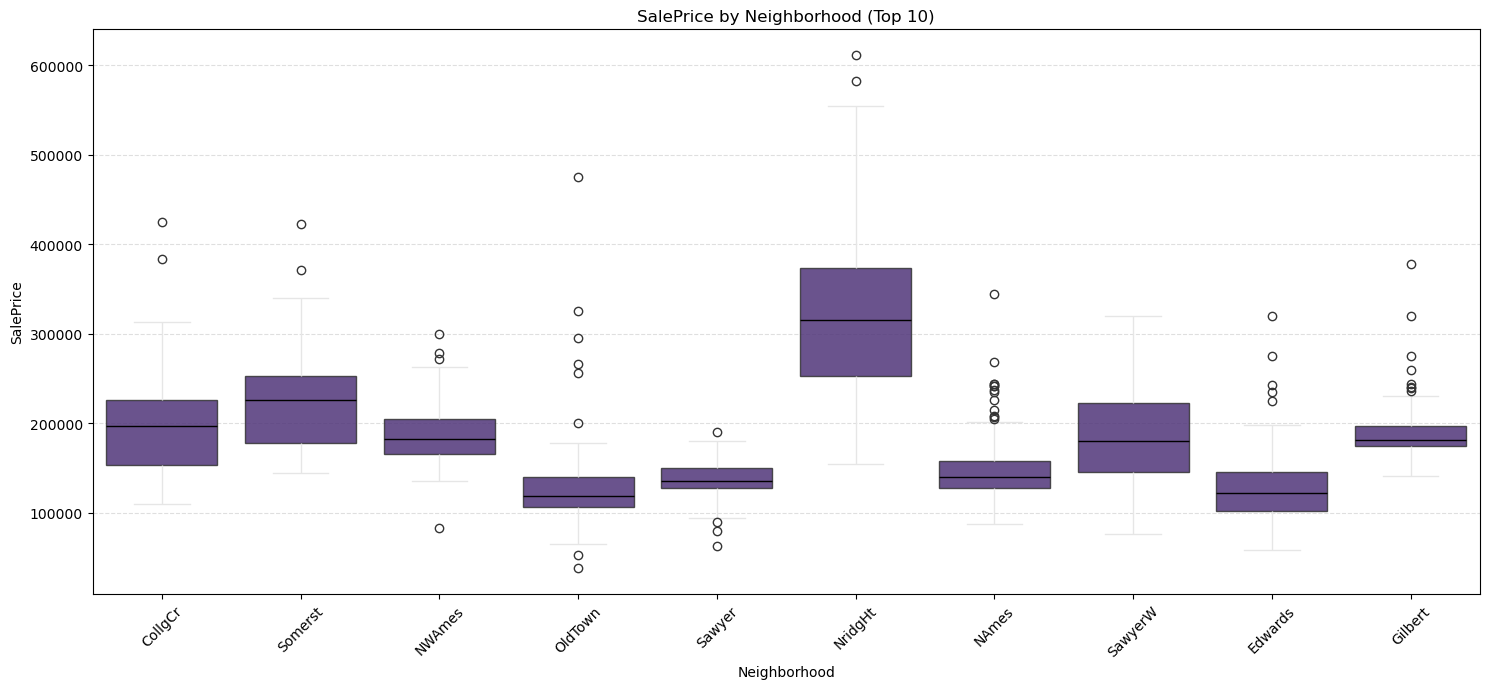

In [18]:
top_neighborhoods = (
    htrain_df["Neighborhood"]
    .value_counts()
    .head(10)
    .index
)

plt.figure(figsize=(15, 7))
sns.boxplot(
    data=htrain_df[htrain_df["Neighborhood"].isin(top_neighborhoods)],
    x="Neighborhood",
    y="SalePrice",
    palette=[nu_purple] * len(top_neighborhoods),
    boxprops=dict(alpha=0.85),
    medianprops=dict(color="black"),
    whiskerprops=dict(color=nu_gray),
    capprops=dict(color=nu_gray),
)

plt.xticks(rotation=45)
plt.title("SalePrice by Neighborhood (Top 10)")
plt.xlabel("Neighborhood")
plt.ylabel("SalePrice")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

House prices vary substantially across neighborhoods. Some neighborhoods exhibit higher typical prices and wider spreads, while others are more concentrated at lower price levels. This indicates that location plays a significant role in pricing and captures information beyond size or age alone.

# Overview of Findings and Next Steps

This section summarizes the main insights from the initial exploratory analysis and outlines the key steps required before moving to predictive modeling.

## Key Findings from Initial EDA

The exploratory analysis indicates that sale prices are right-skewed, with a relatively small number of high-priced homes. Most properties fall within a lower price range, while a few extreme values stretch the distribution to the right. This highlights the presence of outliers and the need for careful handling during modeling.

Missing values in the dataset are not randomly distributed. Instead, they are concentrated in specific feature groups related to property amenities, including pools, fences, alleys, garages, and basements. In many cases, these missing values reflect the absence of a feature rather than a data quality issue. Some features, such as PoolQC and MiscFeature, are missing for most properties, which limits their usefulness for predictive modeling.

Overall, the analysis suggests that housing prices are primarily driven by interior size, construction quality, and location, rather than land size alone. Features related to living area, overall quality, garage capacity, and neighborhood show stronger relationships with sale price, while lot size by itself exhibits a weaker association. The scatterplot of living area and sale price supports this pattern, showing higher prices as interior space increases.

Several size-related features are also strongly correlated with one another, indicating overlap in the information they provide. This redundancy supports the use of feature engineering in later steps to combine or transform variables in a way that better represents housing characteristics. The numeric range checks further confirm the presence of extreme values in several size-related features, reinforcing the need for outlier-aware preprocessing rather than automatic removal.

Additionally, numeric diagnostics reveal that not all numeric features behave as continuous measurements. Some numeric values represent ordered categories, such as quality ratings or room counts, which should be treated differently during preprocessing to preserve their real-world meaning. Finally, the categorical feature analysis shows that a small number of variables, such as neighborhood and exterior materials, have high cardinality, which has implications for encoding and model complexity.

## Next Steps for Data Preparation and Modeling

Based on the initial exploratory data analysis, several data preparation steps are required before building predictive models. Missing values need to be handled carefully, since in many cases they indicate the absence of a feature rather than a data error, such as homes without garages or pools. Features with extremely high levels of missingness will be removed, while the remaining missing values will be handled through targeted, context-aware imputation.

Categorical features must be converted into numerical form so they can be used in regression analysis. Nominal categorical variables such as neighborhood and zoning will be prepared using one-hot encoding, while ordered quality and condition variables will be treated as ordinal features to preserve their natural ranking. In addition, selected sparse or skewed numeric variables may be grouped using binning when this provides a clearer representation of the data.

Outliers observed in sale price and size-related features will be reviewed rather than removed automatically, since many represent valid high-value homes. When necessary, outlier treatment will be applied in a controlled way during modeling, such as through capping, binning, or piecewise regression. Feature engineering will then be used to reduce redundancy and better represent housing characteristics, including total living area and house age.

# Cleansing and Preprocessing

At this stage, I move from exploration to actively cleaning and preparing the data for modeling. Rather than applying a single mechanical rule, preprocessing decisions are guided by insights from the exploratory data analysis, including patterns of missingness, feature types, and the presence of extreme values. The goal is to produce a dataset that is consistent, interpretable, and suitable for regression-based models. All preprocessing steps are applied consistently to both the training and test datasets to ensure alignment and avoid information leakage.

## Identifying and Dropping High-Missing Features

The missing values heatmap from the EDA showed that a small number of features contain extremely high levels of missingness. These features contribute a large share of the missing data while providing limited usable signal.

To address this, I remove features with very high missingness in two steps. First, I drop features with more than 50% missing values. After re-evaluating the dataset, I then remove one additional feature with still unusually high missingness. This approach improves data quality while minimizing information loss.

In [19]:
missing_f_percent = (
    htrain_df.drop(columns=[htarget_column])
    .isnull()
    .mean()
    .mul(100)
)

missing_h_table = (
    missing_f_percent.sort_values(ascending=False)
    .head(25)
    .to_frame()
    .T
)
missing_h_table.index = ["MissingPercent"]

display(
    nu_style_table(
        missing_h_table.round(2),
        caption="Top Missing Features (Train) - Before Dropping"
    )
)

threshold_1 = 50
drop_50 = missing_f_percent[missing_f_percent > threshold_1].index.tolist()

htrain_reduced = htrain_df.drop(columns=drop_50)
htest_reduced = htest_df.drop(columns=drop_50)

print(f"Dropped {len(drop_50)} features with >{threshold_1}% missing.")
print("Training shape:", htrain_reduced.shape)
print("Test shape:", htest_reduced.shape)

if len(drop_50) > 0:
    dropped_50_table = (
        missing_f_percent[drop_50]
        .sort_values(ascending=False)
        .to_frame()
        .T
    )
    dropped_50_table.index = ["MissingPercent"]

    display(
        nu_style_table(
            dropped_50_table.round(2),
            caption="Dropped Features (>50% Missing)"
        )
    )
else:
    print("No features exceeded 50% missingness.")

Dropped 5 features with >50% missing.
Training shape: (1460, 76)
Test shape: (1459, 75)


## Missing Values After Initial Feature Removal
After removing the most sparse features, I re-examine the missingness pattern. At this stage, missing values are far more structured and concentrated in specific feature groups, such as garage and basement features, rather than scattered randomly.

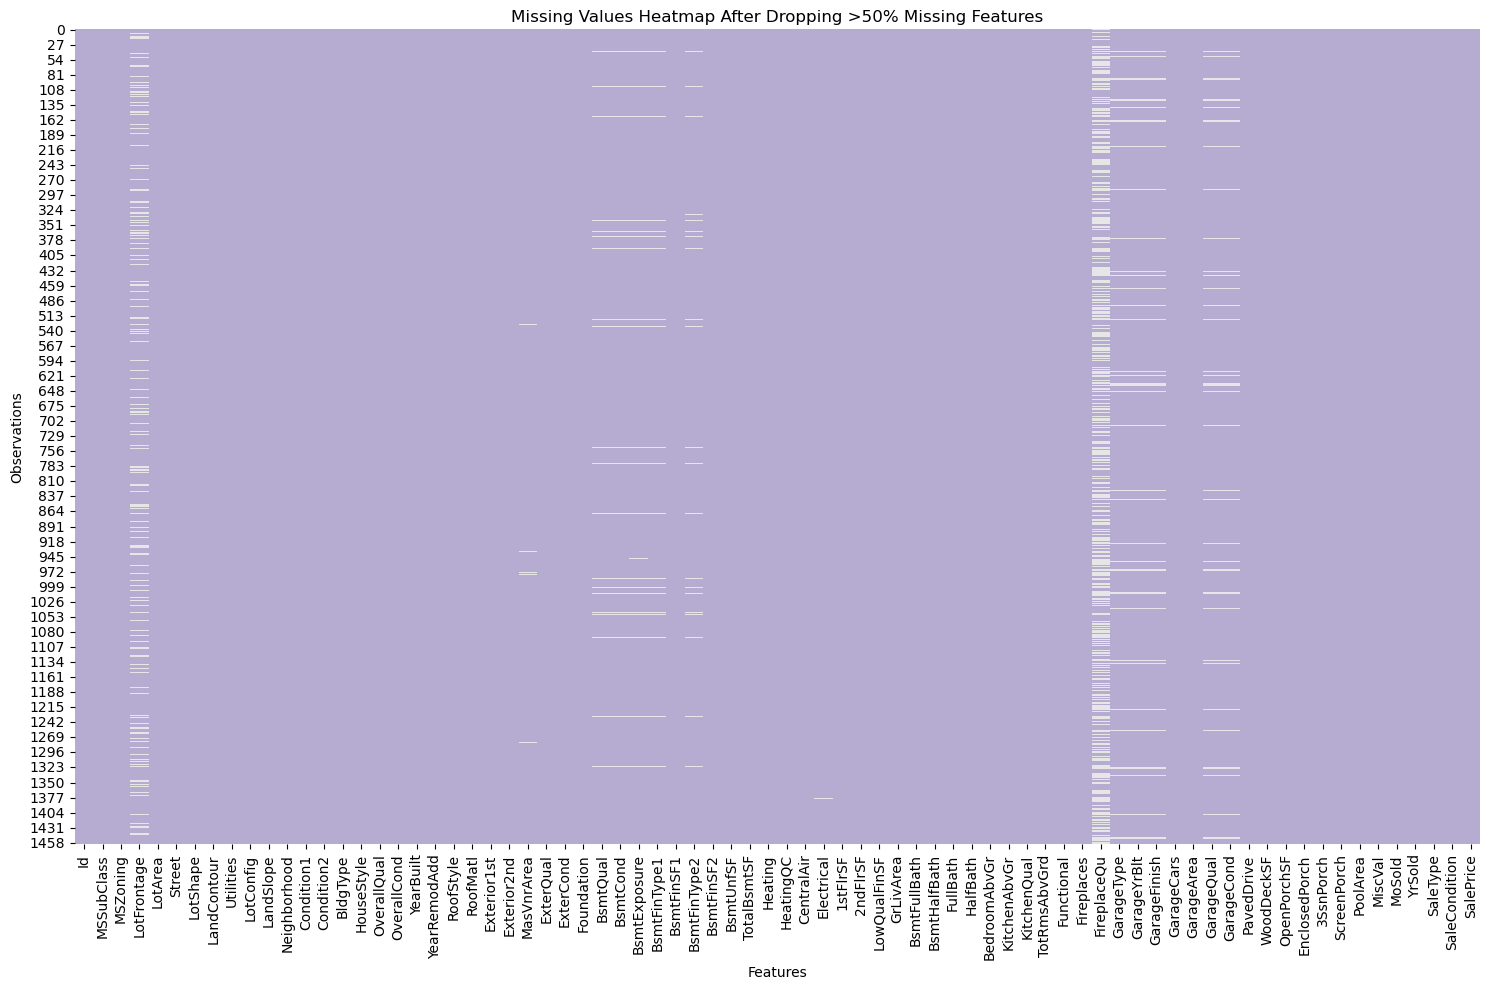

In [20]:
plt.figure(figsize=(15, 10))
sns.heatmap(
    htrain_reduced.isnull(),
    cbar=False,
    cmap=missing_cmap
)

plt.title("Missing Values Heatmap After Dropping >50% Missing Features")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.tight_layout()
plt.show()

This pattern confirms that most remaining missing values reflect structural absence (e.g., no garage or no basement) rather than data quality errors.

## Secondary Feature Removal
After the first reduction, one remaining feature still shows unusually high missingness relative to the rest of the dataset (approximately 47%). A second cutoff is applied to remove this single feature, further stabilizing the dataset while avoiding unnecessary information loss.

In [21]:
missing_f_percent_reduced = (
    htrain_reduced.drop(columns=[htarget_column])
    .isnull()
    .mean()
    .mul(100)
)

missing_h_table_reduced = (
    missing_f_percent_reduced.sort_values(ascending=False)
    .head(25)
    .to_frame()
    .T
)
missing_h_table_reduced.index = ["MissingPercent"]

display(
    nu_style_table(
        missing_h_table_reduced.round(2),
        caption="Top Missing Features (Train) - After First Drop"
    )
)

threshold_2 = 47
drop_47 = missing_f_percent_reduced[missing_f_percent_reduced > threshold_2].index.tolist()

htrain_cleaned = htrain_reduced.drop(columns=drop_47)
htest_cleaned = htest_reduced.drop(columns=drop_47)

print(f"Dropped {len(drop_47)} additional features with >{threshold_2}% missing.")
print("Training shape:", htrain_cleaned.shape)
print("Test shape:", htest_cleaned.shape)


if len(drop_47) > 0:
    dropped_47_table = (
        missing_f_percent_reduced[drop_47]
        .sort_values(ascending=False)
        .to_frame()
        .T
    )
    dropped_47_table.index = ["MissingPercent"]

    display(
        nu_style_table(
            dropped_47_table.round(2),
            caption="Dropped Features (>47% Missing)"
        )
    )
else:
    print("No additional features exceeded 47% missingness.")

Dropped 1 additional features with >47% missing.
Training shape: (1460, 75)
Test shape: (1459, 74)


## Missing Values After Secondary Feature Removal

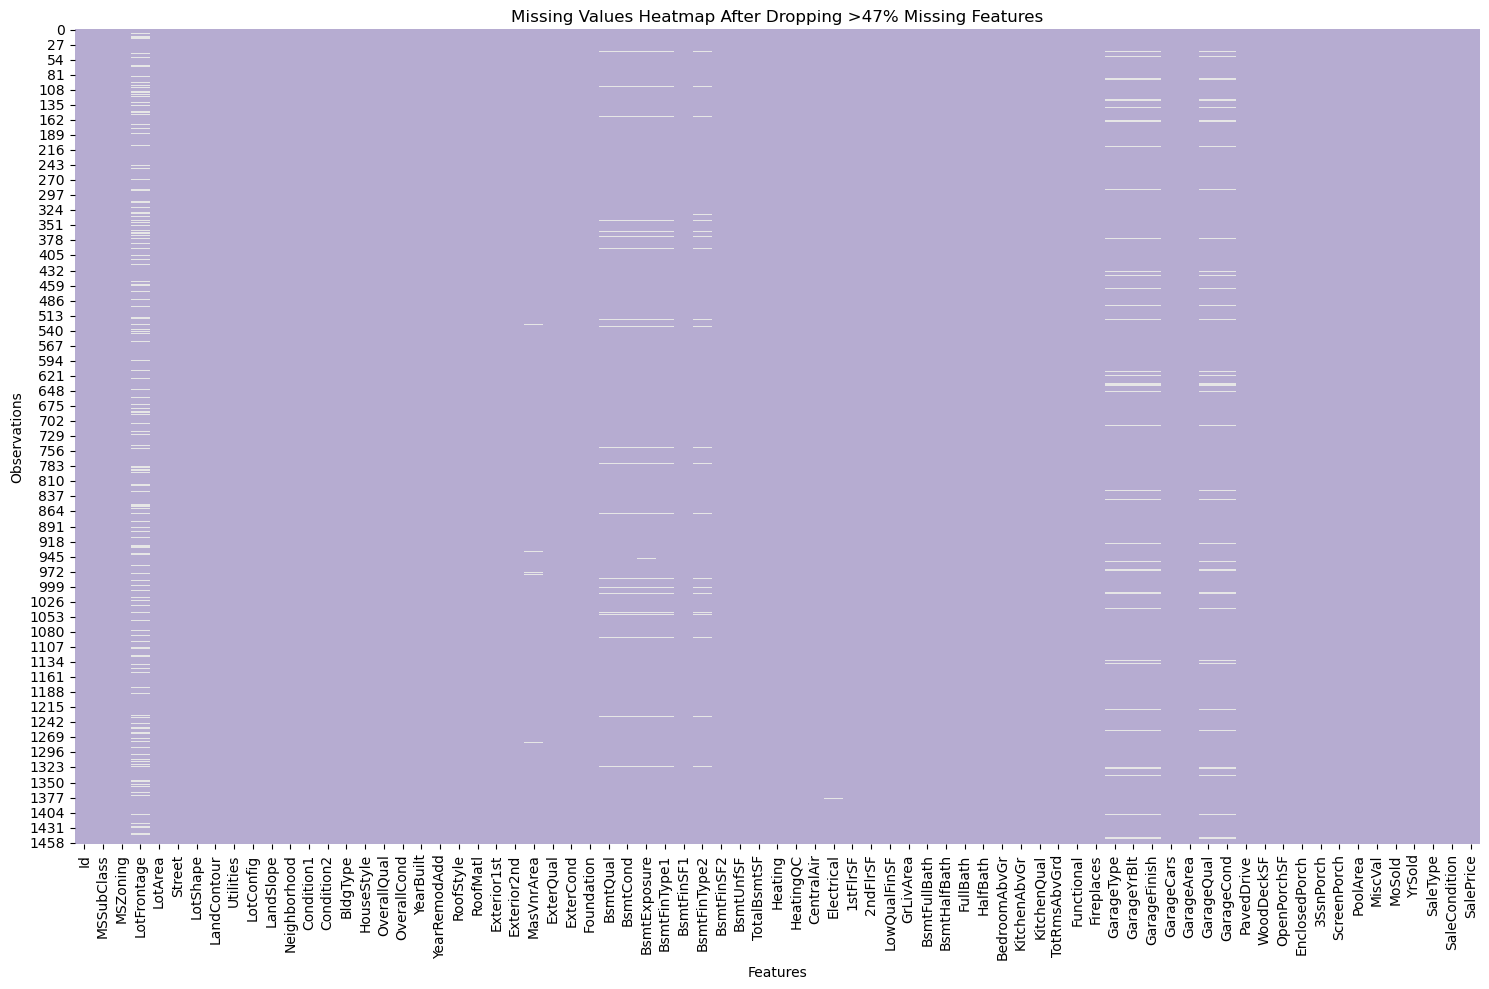

In [22]:
plt.figure(figsize=(15, 10))
sns.heatmap(
    htrain_cleaned.isnull(),
    cbar=False,
    cmap=missing_cmap
)

plt.title("Missing Values Heatmap After Dropping >47% Missing Features")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.tight_layout()
plt.show()

After removing the remaining high-missing feature, the heatmap shows that missing values are no longer widespread. The remaining gaps are limited to a small set of related features and follow clear patterns, which confirms that the dataset is now stable and ready for targeted imputation rather than further feature removal.

## Targeted Imputation of Remaining Missing Values
After removing highly sparse features, the remaining missing values are handled using a meaning-based (context-aware) imputation strategy guided by the Ames housing data dictionary. In this dataset, missingness often does not mean “unknown.” In many cases, it means the feature does not exist for that home (for example, no basement, no garage, no pool, or no fireplace). For these categorical variables, missing values are filled with "None" so that the model treats “absence” as a real category instead of deleting observations.

For numeric variables, I do not apply one generic rule. When a numeric variable represents an amount that can truly be zero (such as basement square feet or garage area), missing values are filled with 0 because that directly represents “none.” For remaining numeric variables where missingness reflects unknown / not recorded (for example, LotFrontage), I fill missing values using the median calculated from the training data only to avoid leakage. In addition, I create a simple missingness indicator (e.g., LotFrontage_Missing) so the model can learn whether missingness itself carries information.

In [23]:
htrain_cleaned = htrain_cleaned.copy()
htest_cleaned = htest_cleaned.copy()

# ----------------------------
htrain_cleaned["MSSubClass"] = htrain_cleaned["MSSubClass"].astype(str)
htest_cleaned["MSSubClass"] = htest_cleaned["MSSubClass"].astype(str)

# ----------------------------
cat_cols = htrain_cleaned.select_dtypes(include=["object", "category"]).columns
for col in cat_cols:
    if htrain_cleaned[col].isna().any() or htest_cleaned[col].isna().any():
        htrain_cleaned[col] = htrain_cleaned[col].fillna("None")
        htest_cleaned[col] = htest_cleaned[col].fillna("None")

# ----------------------------
num_cols = htrain_cleaned.select_dtypes(include=["int64", "float64"]).columns
num_cols = [c for c in num_cols if c != htarget_column]

# Numeric variables where missing means "does not exist" -> fill 0
zero_fill_numeric = [
    "GarageArea", "GarageCars",
    "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF",
    "BsmtFullBath", "BsmtHalfBath",
    "MasVnrArea", "PoolArea", "MiscVal",
]

for col in zero_fill_numeric:
    if col in htrain_cleaned.columns:
        htrain_cleaned[col] = htrain_cleaned[col].fillna(0)
        htest_cleaned[col] = htest_cleaned[col].fillna(0)

# Remaining numeric: median imputation + missingness indicator
remaining_num = [c for c in num_cols if c not in zero_fill_numeric]

for col in remaining_num:
    htrain_cleaned[f"{col}_Missing"] = htrain_cleaned[col].isna().astype(int)
    htest_cleaned[f"{col}_Missing"] = htest_cleaned[col].isna().astype(int)

train_medians = htrain_cleaned[remaining_num].median()

for col in remaining_num:
    htrain_cleaned[col] = htrain_cleaned[col].fillna(train_medians[col])
    htest_cleaned[col] = htest_cleaned[col].fillna(train_medians[col])

print("Remaining NaNs (train):", int(htrain_cleaned.isna().sum().sum()))
print("Remaining NaNs (test):", int(htest_cleaned.isna().sum().sum()))

Remaining NaNs (train): 0
Remaining NaNs (test): 0


## Recompute Numeric and Categorical Features

After feature removal and imputation, numeric and categorical feature lists are recomputed. This ensures that subsequent preprocessing steps, such as encoding and feature engineering, are applied to the correct feature types based on the updated dataset structure.

In [24]:
hnumeric_features = htrain_cleaned.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()

hnumeric_features = [c for c in hnumeric_features if c != htarget_column]

hcategorical_features = htrain_cleaned.select_dtypes(
    include=["object", "category"]
).columns.tolist()

print("Number of numeric features:", len(hnumeric_features))
print("Number of categorical features:", len(hcategorical_features))

print("MSSubClass dtype:", htrain_cleaned["MSSubClass"].dtype)

Number of numeric features: 61
Number of categorical features: 38
MSSubClass dtype: object


## Ordinal Feature Identification 
Some numeric features have a small number of distinct values and represent ordered categories rather than continuous measurements, such as quality ratings and room counts. These features are flagged as potential ordinal variables but are not transformed at this stage.

The goal here is documentation and reproducibility. Decisions about how to treat these features (indicator terms, ordinal encoding, or piecewise modeling) are deferred to the modeling stage.

In [25]:
hfeature_metadata = pd.DataFrame({
    "Feature": htrain_cleaned.columns,
    "DataType": htrain_cleaned.dtypes.astype(str),
    "UniqueLevels": [
        htrain_cleaned[col].nunique() for col in htrain_cleaned.columns
    ]
})

hfeature_metadata["PotentialOrdinal"] = (
    (hfeature_metadata["DataType"].isin(["int64", "float64"])) &
    (hfeature_metadata["Feature"] != htarget_column) &
    (hfeature_metadata["UniqueLevels"] <= 12)
)

ordinal_table = (
    hfeature_metadata
    .query("PotentialOrdinal")
    .set_index("Feature")[["UniqueLevels"]]
    .T
)

display(
    nu_style_table(
        ordinal_table,
        caption="Flagged Ordinal Numeric Features (Metadata Only)"
    )
)

## Outlier Identification

Based on earlier EDA diagnostics, several numeric features exhibit extreme values, particularly size- and price-related features. Rather than removing these observations at this stage, potential outliers are identified and flagged using an IQR-based rule. This preserves valid high-end homes while allowing flexible treatment during model specification and evaluation.

In [26]:
houtlier_flags = {}

selected_outlier_features = [
    "SalePrice",
    "GrLivArea",
    "TotalBsmtSF",
    "GarageArea",
    "LotArea"
]

for col in selected_outlier_features:
    Q1 = htrain_cleaned[col].quantile(0.25)
    Q3 = htrain_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    houtlier_flags[col] = (
        (htrain_cleaned[col] < lower) |
        (htrain_cleaned[col] > upper)
    )

houtlier_summary = pd.DataFrame({
    col: houtlier_flags[col].sum()
    for col in houtlier_flags
}, index=["Flagged Outliers"])

display(
    nu_style_table(
        houtlier_summary,
        caption="Potential Outliers Identified by IQR (Flagged Only)"
    )
)

The table above shows how many observations were flagged as potential outliers using the IQR method for several numeric features. These values were only flagged for awareness and review and were not removed or changed at this stage. In housing data, extreme values often represent real cases such as very large homes or high-priced properties rather than data errors. Because of this, the outliers are documented during exploratory analysis but intentionally kept so their effect can be examined later during the modeling stage.

## Enhanced preprocessing
This step adds extra preprocessing to improve overall model performance and prediction accuracy. It focuses on handling missing values more carefully, reducing the impact of extreme outliers, and applying transformations that make important features more stable. Train and test data are processed together to ensure consistent feature handling, while the target variable is transformed to reduce skewness. These steps help the models learn clearer patterns from the data and produce more reliable predictions.

In [27]:
train_raw = htrain_df.copy()
test_raw  = htest_df.copy()

test_id = test_raw["Id"].copy()

# Log target 
y_log_enhanced = np.log1p(train_raw["SalePrice"]).copy()

# ----------------------------
# Outlier removal (train only)
# ----------------------------
out_idx1 = train_raw[(train_raw["GrLivArea"] > 4000) & (train_raw["SalePrice"] < 300000)].index
train_raw = train_raw.drop(out_idx1)
y_log_enhanced = y_log_enhanced.drop(out_idx1)

out_idx2 = train_raw[train_raw["LotArea"] > 100000].index
train_raw = train_raw.drop(out_idx2)
y_log_enhanced = y_log_enhanced.drop(out_idx2)

print("Train after outliers:", train_raw.shape)

# ----------------------------
# Combine train + test (without target)
# ----------------------------
ntrain_enhanced = len(train_raw)

enhanced = pd.concat(
    [
        train_raw.drop(columns=["Id", "SalePrice"]),
        test_raw.drop(columns=["Id"]),
    ],
    ignore_index=True
)

# ----------------------------
# Missing values (dataset logic)
# ----------------------------
none_cols = [
    "PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
    "GarageType", "GarageFinish", "GarageQual", "GarageCond",
    "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
    "MasVnrType"
]
for col in none_cols:
    if col in enhanced.columns:
        enhanced[col] = enhanced[col].fillna("None")

zero_cols = [
    "GarageYrBlt", "GarageArea", "GarageCars",
    "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF",
    "BsmtFullBath", "BsmtHalfBath", "MasVnrArea"
]
for col in zero_cols:
    if col in enhanced.columns:
        enhanced[col] = enhanced[col].fillna(0)

# LotFrontage by Neighborhood median
if "LotFrontage" in enhanced.columns and "Neighborhood" in enhanced.columns:
    enhanced["LotFrontage"] = enhanced.groupby("Neighborhood")["LotFrontage"].transform(
        lambda x: x.fillna(x.median())
    )

# Final fallback fill: mode for object, median for numeric
for col in enhanced.columns:
    if enhanced[col].isnull().any():
        if enhanced[col].dtype == "object":
            enhanced[col] = enhanced[col].fillna(enhanced[col].mode()[0])
        else:
            enhanced[col] = enhanced[col].fillna(enhanced[col].median())

print("Missingness after fill:", enhanced.isnull().sum().sum())

Train after outliers: (1454, 81)
Missingness after fill: 0


# Feature Engineering
In this section, I create new features based on EDA insights and apply encoding steps to make the dataset model-ready. The goal is to represent housing characteristics in a way that matches domain meaning, keeps ordering when it matters, and stays interpretable for OLS.

## Clean Copies for Feature Engineering
Before creating new features, I create working copies of the cleaned training and test datasets. This keeps the original cleaned data unchanged and ensures feature engineering is applied consistently to both datasets.

In [28]:
hdf_fe = htrain_cleaned.copy()
htest_fe = htest_cleaned.copy()

## Creating Artificial Features
Based on what I observed in the exploratory analysis, I created several engineered features to make the data easier for the models to learn from. Instead of using many raw columns separately, I combined and summarized them into clearer signals. 

For example, I created indicators for garage, basement, kitchen, and fireplace presence, a combined TotalBathrooms feature, and size features like TotalBsmtFinSF and AboveGradeSF_Adj. I also created time-based features (HouseAge and YearsSinceRemodel) because they are easier to interpret than using raw year values.

To capture threshold-style behavior, I binned EnclosedPorch and BsmtFinSF2 into categories, and I grouped neighborhoods into Neighborhood_Bin based on price tiers. I also used HouseStyle to estimate floor-related information (Floors_FromStyle and FloorFinishStatus).

Finally, I added interaction-style features (for example OverallQual × GrLivArea) and created TotalSF (above-grade living area + basement area), along with log_TotalSF, to help reduce the effect of extreme values while keeping all observations.

Overall, these features reduce noise, keep the meaning of the housing variables, and make the relationships with SalePrice clearer for OLS regression.

In [29]:
for df in [hdf_fe, htest_fe]:

    # ----------------------------
    if "GarageArea" in df.columns:
        df["GarageArea"] = df["GarageArea"].fillna(0)
    if "GarageCars" in df.columns:
        df["GarageCars"] = df["GarageCars"].fillna(0)

    if "GarageCars" in df.columns:
        df["HasGarage"] = (df["GarageCars"] > 0).astype(int)
    else:
        df["HasGarage"] = 0

    # ----------------------------
    for c in ["TotalBsmtSF", "BsmtFinSF1", "BsmtFinSF2"]:
        if c in df.columns:
            df[c] = df[c].fillna(0)

    if "TotalBsmtSF" in df.columns:
        df["HasBasement"] = (df["TotalBsmtSF"] > 0).astype(int)
    else:
        df["HasBasement"] = 0
        df["TotalBsmtSF"] = 0

    if ("BsmtFinSF1" in df.columns) and ("BsmtFinSF2" in df.columns):
        df["TotalBsmtFinSF"] = df["BsmtFinSF1"] + df["BsmtFinSF2"]
    else:
        df["TotalBsmtFinSF"] = 0

    def basement_finish_status(row):
        if row["TotalBsmtSF"] == 0:
            return "NoBasement"
        if row["TotalBsmtFinSF"] == 0:
            return "Unfinished"
        if row["TotalBsmtFinSF"] < row["TotalBsmtSF"]:
            return "PartiallyFinished"
        return "Finished"

    df["BasementFinishStatus"] = df.apply(basement_finish_status, axis=1)

    # ----------------------------
    if "KitchenAbvGr" in df.columns:
        df["HasKitchen"] = (df["KitchenAbvGr"] > 0).astype(int)
    else:
        df["HasKitchen"] = 0


    # ----------------------------
    if "Fireplaces" in df.columns:
        df["HasFireplace"] = (df["Fireplaces"] > 0).astype(int)
    else:
        df["HasFireplace"] = 0


    # ----------------------------
    needed_baths = ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]
    if all(c in df.columns for c in needed_baths):
        df["TotalBathrooms"] = (
            df["FullBath"]
            + 0.5 * df["HalfBath"]
            + df["BsmtFullBath"]
            + 0.5 * df["BsmtHalfBath"]
        )
    else:
        df["TotalBathrooms"] = np.nan


    # ----------------------------
    if "2ndFlrSF" in df.columns:
        df["TotalFloors"] = 1 + (df["2ndFlrSF"] > 0).astype(int)
    else:
        df["TotalFloors"] = 1

    needed_area = ["1stFlrSF", "2ndFlrSF", "LowQualFinSF"]
    if all(c in df.columns for c in needed_area):
        df["AboveGradeSF_Adj"] = (
            df["1stFlrSF"] + df["2ndFlrSF"] + df["LowQualFinSF"]
        )
    else:
        df["AboveGradeSF_Adj"] = np.nan


    # ----------------------------
    if "HouseStyle" in df.columns:
        df["Floors_FromStyle"] = df["HouseStyle"].map(floors_from_housestyle)
        df["FloorFinishStatus"] = df["HouseStyle"].apply(floor_finish_status)
    else:
        df["Floors_FromStyle"] = np.nan
        df["FloorFinishStatus"] = "Other"


    # ----------------------------
    if all(c in df.columns for c in ["YrSold", "YearBuilt"]):
        df["HouseAge"] = (df["YrSold"] - df["YearBuilt"]).clip(lower=0)
    else:
        df["HouseAge"] = np.nan

    if all(c in df.columns for c in ["YrSold", "YearRemodAdd"]):
        df["YearsSinceRemodel"] = (df["YrSold"] - df["YearRemodAdd"]).clip(lower=0)
    else:
        df["YearsSinceRemodel"] = np.nan


    # ----------------------------
    if "EnclosedPorch" in df.columns:
        df["EnclosedPorch_Bin"] = pd.cut(
            df["EnclosedPorch"],
            bins=[-1, 0, 50, 150, np.inf],
            labels=["0", "1-50", "51-150", "150+"]
        )

    if "BsmtFinSF2" in df.columns:
        df["BsmtFinSF2_Bin"] = pd.cut(
            df["BsmtFinSF2"],
            bins=[-1, 0, 200, 600, np.inf],
            labels=["0", "1-200", "201-600", "600+"]
        )

# ==========================================================
neighborhood_price = (
    hdf_fe.groupby("Neighborhood")[htarget_column]
    .median()
    .sort_values()
)

neighborhood_bins = pd.qcut(
    neighborhood_price,
    q=5,
    labels=[
        "Very Low Price",
        "Low Price",
        "Mid Price",
        "High Price",
        "Very High Price"
    ]
)

neighborhood_bin_map = neighborhood_bins.to_dict()

hdf_fe["Neighborhood_Bin"] = hdf_fe["Neighborhood"].map(neighborhood_bin_map)
htest_fe["Neighborhood_Bin"] = htest_fe["Neighborhood"].map(neighborhood_bin_map)
hdf_fe["Neighborhood_Bin"] = hdf_fe["Neighborhood_Bin"].fillna("Mid Price")
htest_fe["Neighborhood_Bin"] = htest_fe["Neighborhood_Bin"].fillna("Mid Price")

# ==========================================================
for df in [hdf_fe, htest_fe]:
    
    if 'OverallQual' in df.columns and 'GrLivArea' in df.columns:
        df['QualityArea'] = df['OverallQual'] * df['GrLivArea']
    
    if 'OverallQual' in df.columns and 'TotalBsmtSF' in df.columns:
        df['QualityBsmt'] = df['OverallQual'] * df['TotalBsmtSF']
    
    if 'OverallQual' in df.columns and 'GarageArea' in df.columns:
        df['QualityGarage'] = df['OverallQual'] * df['GarageArea']
    
    if 'OverallQual' in df.columns and 'OverallCond' in df.columns:
        df['QualCond'] = df['OverallQual'] * df['OverallCond']
    
    if 'HouseAge' in df.columns and 'OverallQual' in df.columns:
        df['AgeQual'] = df['HouseAge'] * df['OverallQual']
    
    if 'TotalBathrooms' in df.columns and 'GrLivArea' in df.columns:
        df['BathArea'] = df['TotalBathrooms'] * df['GrLivArea']
    
    df['TotalSF'] = df['GrLivArea'] + df['TotalBsmtSF']
    df['QualityTotalSF'] = df['OverallQual'] * df['TotalSF']
    
    df['log_TotalSF'] = np.log1p(df['TotalSF'])

print("Train shape:", hdf_fe.shape)
print("Test shape:", htest_fe.shape)

Train shape: (1460, 125)
Test shape: (1459, 124)


In [30]:
engineered_features = pd.DataFrame(
    [

        # ----------------------------
        ["TotalBsmtSF, BsmtFinSF1, BsmtFinSF2", "HasBasement", "Binary",
         "Indicates whether the house has a basement."],
        
        ["BsmtFinSF1 + BsmtFinSF2", "TotalBsmtFinSF", "Numeric",
         "Total finished basement area."],
        
        ["TotalBsmtSF vs TotalBsmtFinSF", "BasementFinishStatus", "Categorical",
         "Basement finish level: Finished, PartiallyFinished, Unfinished, or NoBasement."],

        # ----------------------------
        ["GarageCars", "HasGarage", "Binary",
         "Indicates whether the house has a garage."],
        
        ["KitchenAbvGr", "HasKitchen", "Binary",
         "Indicates whether a kitchen exists above grade."],
        
        ["Fireplaces", "HasFireplace", "Binary",
         "Indicates whether the house has at least one fireplace."],


        # ----------------------------
        ["FullBath, HalfBath, BsmtFullBath, BsmtHalfBath", "TotalBathrooms", "Discrete",
         "Combined bathroom count with half-bath weighting."],
        
        ["1stFlrSF, 2ndFlrSF, LowQualFinSF", "AboveGradeSF_Adj", "Numeric",
         "Adjusted above-grade living area."],
        
        ["2ndFlrSF", "TotalFloors", "Discrete",
         "Approximated number of floors based on second-floor presence."],


        # ----------------------------
        ["HouseStyle", "Floors_FromStyle", "Numeric",
         "Approximate number of floors derived from house style."],
        
        ["HouseStyle", "FloorFinishStatus", "Categorical",
         "Simplified floor layout category (OneStory, TwoStory, HalfStory, SplitLevel)."],


        # ----------------------------
        ["YrSold − YearBuilt", "HouseAge", "Numeric",
         "Age of the house at time of sale."],
        
        ["YrSold − YearRemodAdd", "YearsSinceRemodel", "Numeric",
         "Years since the last remodel at time of sale."],


        # ----------------------------
        ["EnclosedPorch", "EnclosedPorch_Bin", "Categorical",
         "Binned enclosed porch area to capture threshold effects."],
        
        ["BsmtFinSF2", "BsmtFinSF2_Bin", "Categorical",
         "Binned secondary basement finished area."],

        # ----------------------------
        ["Neighborhood + SalePrice (train only)", "Neighborhood_Bin", "Categorical",
         "Neighborhood grouped into five price-based bins."],
        
        ["OverallQual × GrLivArea", "QualityArea", "Numeric",
         "Interaction: Quality premium increases with size"],
        ["OverallQual × TotalBsmtSF", "QualityBsmt", "Numeric",
         "Interaction: Quality premium for finished basement"],
        ["OverallQual × GarageArea", "QualityGarage", "Numeric",
         "Interaction: Quality premium for garage space"],
        ["OverallQual × OverallCond", "QualCond", "Numeric",
         "Interaction: Combined quality and condition effect"],
        ["HouseAge × OverallQual", "AgeQual", "Numeric",
         "Interaction: Depreciation varies by quality"],
        ["TotalBathrooms × GrLivArea", "BathArea", "Numeric",
         "Interaction: Luxury indicator (bathrooms per sqft)"],
        ["GrLivArea + TotalBsmtSF", "TotalSF", "Numeric",
         "Combined total square footage"],
        ["OverallQual × TotalSF", "QualityTotalSF", "Numeric",
         "Interaction: Quality premium on total space"],
        ["log(TotalSF)", "log_TotalSF", "Numeric",
         "Log-transformed total square footage"],
        
    ],
    columns=[
        "Baseline Feature(s)",
        "Engineered Feature",
        "Type",
        "Purpose"
    ]
)

display(
    nu_style_table(
        engineered_features,
        caption="Summary of Artificial (Engineered) Features"
    )
)

These engineered features make the data easier to understand and use for modeling. Instead of many separate variables, related information is grouped together to better represent house size, quality, age, and layout. This helps reduce noise in the data and makes the relationship with SalePrice clearer for a linear regression model.

## Feature Transformation Assessment
After feature engineering, I reviewed the distributions of numeric predictors to assess skewness and determine whether additional transformations were needed. Highly skewed variables can violate linear regression assumptions and disproportionately influence model estimates. Using skewness metrics, I identified features with substantial right skew and evaluated whether transformations would improve interpretability or model performance. In this case, most engineered features showed improved distributional behavior, and remaining skewed variables were addressed through feature engineering, binning, or later modeling choices rather than aggressive transformation.

In [31]:
numeric_cols = (
    hdf_fe
    .select_dtypes(include=["int64", "float64"])
    .columns
    .drop(htarget_column, errors="ignore")
)

skew_rows = []
for col in numeric_cols:
    s = skew(hdf_fe[col].dropna())
    skew_rows.append([col, s, abs(s), abs(s) >= 0.5])

skew_df = pd.DataFrame(
    skew_rows,
    columns=["Feature", "Skew", "Absolute Skew", "Highly Skewed (>|0.5|)"]
).sort_values("Absolute Skew", ascending=False).round(3)

display(nu_style_table(skew_df, caption="Skewness Assessment of Numeric Features (After Feature Engineering)"))

Skewness checks were used to see which numeric features have very uneven distributions. Instead of applying transformations to every skewed variable, I only added log-transformed versions for a small set of continuous size-related features, where price changes are more likely to behave proportionally rather than linearly. The original variables were kept as well, so the models can choose which form explains sale price better while keeping the results easy to interpret

In [32]:
log_features = [
    "LotArea",
    "AboveGradeSF_Adj",
    "TotalBsmtFinSF",
    "GrLivArea",
    "TotalBsmtSF"
]

log_summary = []

for col in log_features:
    if col in hdf_fe.columns:
        hdf_fe[f"log_{col}"] = np.log1p(hdf_fe[col])
        htest_fe[f"log_{col}"] = np.log1p(htest_fe[col])
        log_summary.append(col)

log_table = pd.DataFrame({
    "Original Feature": log_summary,
    "Transformed Feature": [f"log_{c}" for c in log_summary],
    "Reason": "Reduce skewness & stabilize scale"
})

display(
    nu_style_table(
        log_table,
        caption="Log-Transformed Features Added After Skewness Assessment"
    )
)

## Overview of Artificial Features

In [33]:
numeric_artificial_features = [
    # Binary 
    "HasGarage",
    "HasBasement",
    "HasKitchen",
    "HasFireplace",

    # Numeric / discrete
    "TotalBsmtFinSF",
    "TotalBathrooms",
    "TotalFloors",
    "Floors_FromStyle",
    "AboveGradeSF_Adj",
    "HouseAge",
    "YearsSinceRemodel",
]

numeric_existing = [c for c in numeric_artificial_features if c in hdf_fe.columns]

hengineered_numeric_summary = (
    hdf_fe[numeric_existing]
    .describe()
    .T
    .round(2)
)

display(
    nu_style_table(
        hengineered_numeric_summary,
        caption="Numeric Artificial (Engineered) Features"
    )
)

# ----------------------------------------------------------

categorical_artificial_features = [
    "BasementFinishStatus",
    "FloorFinishStatus",
    "EnclosedPorch_Bin",
    "BsmtFinSF2_Bin",
    "Neighborhood_Bin",
]

cat_existing = [c for c in categorical_artificial_features if c in hdf_fe.columns]

for col in cat_existing:
    feature_dist = (
        hdf_fe[col]
        .value_counts(dropna=False)
        .to_frame(name="Count")
    )

    display(
        nu_style_table(
            feature_dist,
            caption=f"Categorical Artificial Feature Distribution — {col}"
        )
    )

These engineered features look reasonable and easy to understand. Most houses have a garage and a basement, which matches what we would expect for this dataset. Features like total bathrooms, living area, and basement space vary a lot across homes, which is helpful because these differences are important for predicting sale price.

The categorical features also make sense. Most basements are either unfinished or partially finished, single-story homes are the most common, and the neighborhood price bins are fairly balanced. Overall, this confirms that the artificial features describe the housing data well and should be useful for regression modeling.

## Encoding for Ordered Quality Features
Certain categorical variables represent ordered quality levels. These are encoded using ordinal mappings rather than one-hot encoding to preserve ranking.

In [34]:
hquality_map = {
    "None": 0,
    "Po": 1,
    "Fa": 2,
    "TA": 3,
    "Gd": 4,
    "Ex": 5
}

hordinal_cols = [
    "KitchenQual",
    "ExterQual",
    "HeatingQC",
    "BsmtQual",
    "GarageQual"
]

for df in [hdf_fe, htest_fe]:
    for col in hordinal_cols:
        if col in df.columns:
            df[col] = df[col].map(hquality_map).fillna(0).astype(int)

## One-Hot Encoding for Remaining Categorical Features
All remaining nominal categorical features are converted to indicator variables. Training and test data are combined prior to encoding to ensure column alignment.

In [35]:
htrain_ready = hdf_fe.copy()
htest_ready = htest_fe.copy()
htest_ready[htarget_column] = np.nan

# Drop raw columns that were summarized into engineered features
drop_raw_cols = ["Neighborhood", "HouseStyle"]

for df in [hdf_fe, htest_fe]:
    df.drop(columns=drop_raw_cols, errors="ignore", inplace=True)
    

hall_data = pd.concat([htrain_ready, htest_ready], ignore_index=True)

hcategorical_columns = hall_data.select_dtypes(
    include=["object", "category"]
).columns

all_hencoded = pd.get_dummies(
    hall_data,
    columns=hcategorical_columns,
    drop_first=True
)

encoding_summary = pd.DataFrame({
    "Stage": ["Before Encoding", "After One-Hot Encoding"],
    "Rows": [hall_data.shape[0], all_hencoded.shape[0]],
    "Columns": [hall_data.shape[1], all_hencoded.shape[1]],
})

display(
    nu_style_table(
        encoding_summary,
        caption="Dataset Dimensions Before and After One-Hot Encoding"
    )
)

encoded_dummy_preview = all_hencoded.filter(like="Neighborhood_").head()

display(
    nu_style_table(
        encoded_dummy_preview,
        caption="Example of One-Hot Encoded Dummy Columns (Neighborhood)"
    )
)

After one-hot encoding, the number of rows stays the same, but the number of columns increases a lot. This happens because each category (like neighborhoods and bins) is turned into its own binary column. Even though the dataset becomes wider, this step is necessary so regression models can use categorical information correctly. The example shows how one neighborhood is marked as True while the others are False, which is exactly how dummy variables are supposed to work.

## Final Feature Matrices for Modeling
After encoding, the combined dataset is split back into training and test sets based on whether SalePrice is available. Rows with a known sale price are used for training, while rows without a sale price are kept for testing.

In [36]:
df_hencoded = all_hencoded[
    all_hencoded[htarget_column].notna()
].copy()

df_hencoded[htarget_column] = df_hencoded[htarget_column].astype(float)

df_test_encoded = (
    all_hencoded[all_hencoded[htarget_column].isna()]
    .drop(columns=[htarget_column])
    .copy()
)

train_medians = df_hencoded.median(numeric_only=True)

df_hencoded = df_hencoded.fillna(train_medians)
df_test_encoded = df_test_encoded.fillna(train_medians)

print("Training feature matrix shape:", df_hencoded.shape)
print("Test feature matrix shape:", df_test_encoded.shape)
print("Remaining NaNs (train):", int(df_hencoded.isna().sum().sum()))
print("Remaining NaNs (test):", int(df_test_encoded.isna().sum().sum()))

Training feature matrix shape: (1460, 314)
Test feature matrix shape: (1459, 313)
Remaining NaNs (train): 0
Remaining NaNs (test): 0


Both datasets contain zero missing values, confirming that the preprocessing pipeline was applied correctly and consistently. At this point, the data are fully numeric, aligned between training and test sets, and ready for regression modeling and evaluation.

## Enhanced Feature Engineering

This feature engineering step builds stronger and more meaningful predictors from the original variables. Related features are combined to better represent total house size, bathroom availability, and time-based effects such as house age and years since remodeling. These engineered variables capture housing characteristics more clearly than raw features alone.

Ordinal quality variables are converted into numeric scales so that higher quality consistently reflects higher values. Additional categorical features related to basement exposure, garage finish, functionality, and driveway type are also encoded in an ordered way. Together, these transformations improve interpretability, reduce noise, and help the regression models learn more stable relationships from the data.

In [37]:
# Core engineered features 
if {"TotalBsmtSF", "1stFlrSF", "2ndFlrSF"}.issubset(enhanced.columns):
    enhanced["TotalSF"] = enhanced["TotalBsmtSF"] + enhanced["1stFlrSF"] + enhanced["2ndFlrSF"]

if {"FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"}.issubset(enhanced.columns):
    enhanced["TotalBath"] = (
        enhanced["FullBath"]
        + 0.5 * enhanced["HalfBath"]
        + enhanced["BsmtFullBath"]
        + 0.5 * enhanced["BsmtHalfBath"]
    )

if {"YrSold", "YearBuilt"}.issubset(enhanced.columns):
    enhanced["Age"] = enhanced["YrSold"] - enhanced["YearBuilt"]

if {"YrSold", "YearRemodAdd"}.issubset(enhanced.columns):
    enhanced["RemodAge"] = enhanced["YrSold"] - enhanced["YearRemodAdd"]

# Ordinal quality to numeric
qual_map = {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
for col in ["ExterQual", "BsmtQual", "KitchenQual", "HeatingQC", "FireplaceQu"]:
    if col in enhanced.columns:
        enhanced[col + "_n"] = enhanced[col].map(qual_map).fillna(0)

if "BsmtExposure" in enhanced.columns:
    enhanced["BsmtExposure_n"] = enhanced["BsmtExposure"].map({"None":0,"No":1,"Mn":2,"Av":3,"Gd":4}).fillna(0)

if "GarageFinish" in enhanced.columns:
    enhanced["GarageFinish_n"] = enhanced["GarageFinish"].map({"None":0,"Unf":1,"RFn":2,"Fin":3}).fillna(0)

if "CentralAir" in enhanced.columns:
    enhanced["CentralAir_n"] = (enhanced["CentralAir"] == "Y").astype(int)

if "Functional" in enhanced.columns:
    enhanced["Functional_n"] = enhanced["Functional"].map(
        {"Sal":1,"Sev":2,"Maj2":3,"Maj1":4,"Mod":5,"Min2":6,"Min1":7,"Typ":8}
    ).fillna(8)

if "BsmtFinType1" in enhanced.columns:
    enhanced["BsmtFinType1_n"] = enhanced["BsmtFinType1"].map(
        {"None":0,"Unf":1,"LwQ":2,"Rec":3,"BLQ":4,"ALQ":5,"GLQ":6}
    ).fillna(0)

if "PavedDrive" in enhanced.columns:
    enhanced["PavedDrive_n"] = enhanced["PavedDrive"].map({"N":0,"P":1,"Y":2}).fillna(2)

print("Feature engineering done. Shape:", enhanced.shape)

Feature engineering done. Shape: (2913, 94)


### Encoding and Skewness Adjustment
After creating the engineered and ordinal features, the remaining categorical variables are converted into indicator (dummy) variables using one-hot encoding. Only the most important categorical features are encoded to avoid unnecessary sparsity while still capturing meaningful location and condition effects.

Next, numeric features are examined for skewness. Highly skewed variables are transformed using a log(1 + x) transformation when applicable. This helps reduce the influence of extreme values, improves normality, and stabilizes variance. Applying these transformations before model training leads to more reliable coefficient estimates and better generalization for both linear and regularized regression models.

In [38]:
# selected set of numeric features
numeric_features_enhanced = [
    "OverallQual", "GrLivArea", "TotalSF", "GarageCars", "GarageArea",
    "TotalBsmtSF", "1stFlrSF", "TotalBath", "FullBath",
    "YearBuilt", "YearRemodAdd", "MasVnrArea", "Fireplaces",
    "ExterQual_n", "KitchenQual_n", "BsmtQual_n", "GarageFinish_n",
    "HeatingQC_n", "BsmtExposure_n",
    "TotRmsAbvGrd", "LotArea", "LotFrontage", "BsmtFinSF1",
    "WoodDeckSF", "OpenPorchSF", "2ndFlrSF",
    "Age", "RemodAge", "OverallCond", "BedroomAbvGr",
    "CentralAir_n", "Functional_n", "BsmtFinType1_n", "PavedDrive_n",
    "GarageYrBlt", "BsmtUnfSF", "ScreenPorch", "HalfBath", "EnclosedPorch",
]
numeric_features_enhanced = [c for c in numeric_features_enhanced if c in enhanced.columns]

# Add only a couple categoricals
cat_features_enhanced = [c for c in ["Neighborhood", "SaleCondition"] if c in enhanced.columns]

for col in cat_features_enhanced:
    dummies = pd.get_dummies(enhanced[col], prefix=col[:4], drop_first=True)
    enhanced = pd.concat([enhanced, dummies], axis=1)

dummy_cols_enhanced = []
for col in cat_features_enhanced:
    dummy_cols_enhanced += [c for c in enhanced.columns if c.startswith(col[:4] + "_")]

final_features_enhanced = numeric_features_enhanced + dummy_cols_enhanced
X_enhanced = enhanced[final_features_enhanced].copy()

# -------------------------------
# Skewness transform for features
# -------------------------------

# Convert any bool columns to int (True/False -> 1/0)
bool_cols = X_enhanced.select_dtypes(include=["bool"]).columns
if len(bool_cols) > 0:
    X_enhanced[bool_cols] = X_enhanced[bool_cols].astype(int)

# Keep numeric columns only for skewness calculation
num_cols = X_enhanced.select_dtypes(include=[np.number]).columns

sk = X_enhanced[num_cols].apply(lambda s: skew(s.dropna()))
sk = sk[sk.abs() > 0.5]

for col in sk.index:
    if X_enhanced[col].min() >= 0:
        X_enhanced[col] = np.log1p(X_enhanced[col])

print("Final features:", X_enhanced.shape[1])
print("Skewness-transformed columns:", len(sk))

Final features: 68
Skewness-transformed columns: 57


At this stage, the final feature set contains 31 predictors after feature selection and encoding. Many numeric variables showed strong right skewness, so log transformations were applied to 29 features to reduce skew and limit the impact of extreme values.

This transformation improves feature distributions, helps linear models better meet normality assumptions, and leads to more stable and reliable predictions across models.

# Overview Presentation of the Cleaned Dataset  
After completing data cleaning, targeted imputation, feature engineering, binning, ordinal encoding, and one-hot encoding, the dataset is now fully prepared for regression modeling. This section provides a final check to confirm that all preprocessing steps were applied correctly, that no missing values remain, and that the feature structure is consistent and suitable for model training and evaluation.

## Dataset Dimensions After Preprocessing

In [39]:
df_hencoded.shape, df_test_encoded.shape

((1460, 314), (1459, 313))

After completing all preprocessing steps, the training dataset contains 1,460 observations and 314 features, while the test dataset contains 1,459 observations and 313 features.

The number of rows remains the same as in the original data, which confirms that no observations were removed during preprocessing. The number of features increases substantially due to one-hot encoding of categorical variables and the creation of engineered features. The test dataset has one fewer column because it does not include the target variable (SalePrice).

## Data Types After Encoding

In [40]:
df_hencoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 0 to 1459
Columns: 314 entries, Id to Neighborhood_Bin_Very Low Price
dtypes: bool(222), float64(26), int64(66)
memory usage: 1.3 MB


The encoded training dataset contains 314 features in total. Most of these features are boolean variables, which were created through one-hot encoding and binning of categorical variables. The remaining features are numeric variables, stored as integers or floats, representing continuous, discrete, and engineered values.

This confirms that all categorical variables have been successfully converted into numerical form and that the dataset is fully compatible with regression modeling.

## Final Dataset Summary

In [41]:
hsummary_table = pd.DataFrame({
    "Dataset": ["Training", "Test"],
    "Rows": [df_hencoded.shape[0], df_test_encoded.shape[0]],
    "Columns": [df_hencoded.shape[1], df_test_encoded.shape[1]],
    "Missing Values": [
        int(df_hencoded.isnull().sum().sum()),
        int(df_test_encoded.isnull().sum().sum()),
    ],
})

display(
    nu_style_table(
        hsummary_table,
        caption="Final Dataset Summary After Cleaning and Encoding"
    )
)

Both the training and test datasets contain zero missing values. This confirms that features with excessive missingness were removed, remaining missing values were handled using context-aware imputation, and no unintended gaps were introduced during feature engineering or encoding. The preprocessing pipeline was applied consistently across both datasets.

## Data Type Distribution

In [42]:
dtype_compare = pd.DataFrame({
    "Data Type": df_hencoded.dtypes.value_counts().index.astype(str),
    "Training": df_hencoded.dtypes.value_counts().values,
    "Test": df_test_encoded.dtypes.value_counts().reindex(
        df_hencoded.dtypes.value_counts().index
    ).values,
})

display(
    nu_style_table(
        dtype_compare,
        caption="Data Type Distribution: Training vs Test Datasets"
    )
)

This table shows how feature data types are distributed in the training and test datasets. Both datasets contain the same number of boolean and integer features, confirming that one-hot encoding and engineered discrete features were applied consistently. The test dataset has one fewer floating-point feature because it does not include the target variable (SalePrice). Overall, this confirms that the datasets are properly aligned and ready for regression modeling without any data type mismatches.

## Summary of Key Features After Preprocessing
The features included in this summary were selected because they represent the main drivers of housing prices: size, layout, and age. Together, they provide a concise but meaningful overview of how space is distributed, how functional the layout is, and how old or recently updated the properties are. Reviewing these features helps confirm that the engineered variables have realistic ranges and capture variation that is relevant for regression modeling.

In [43]:
key_features = [
    "SalePrice",
    "GrLivArea",
    "TotalBsmtFinSF", 
    "TotalBathrooms",
    "TotalFloors",  
    "Floors_FromStyle",
    "HouseAge",
    "YearsSinceRemodel", 
]

key_existing = [c for c in key_features if c in df_hencoded.columns]

hkey_features_summary = (
    df_hencoded[key_existing]
    .describe()
    .T
    .round(2)
)

display(
    nu_style_table(
        hkey_features_summary,
        caption="Summary Statistics of Key Features After Preprocessing"
    )
)

The summary statistics show that the key features look reasonable and realistic after preprocessing. Variables related to house size, such as GrLivArea and TotalBsmtFinSF, show a wide range of values, which helps explain differences in sale prices. The age features (HouseAge and YearsSinceRemodel) include both newer and older homes, which is important because age clearly affects value. Features like TotalBathrooms and TotalFloors stay within expected limits and are easy to interpret. Overall, this confirms that the engineered features make sense and that the dataset is well prepared for regression modeling.

At this stage, the training and test datasets are fully prepared for regression modeling. All missing values have been handled, categorical variables have been converted into numeric form, and engineered features have been added to better represent important housing characteristics.

The training and test datasets are aligned and share the same feature structure, ensuring consistency between model training and prediction. With preprocessing complete, the next step is to build and evaluate regression models using holdout validation and cross-validatio

# Final EDA and Comparisons
After completing data cleaning, targeted imputation, feature engineering, transformation, and encoding, I perform a final round of exploratory analysis. Unlike the initial EDA phase, the goal of this section is validation rather than discovery. The objective is to confirm that preprocessing decisions improved feature behavior, reduced noise, and produced a dataset that better represents the relationships relevant for regression modeling

## Target Variable Review 
To ensure that preprocessing did not distort the target variable, I re-examine the distribution of SalePrice in the final encoded training dataset. A histogram, boxplot, and Q–Q plot are used to assess skewness, outliers, and deviation from normality.

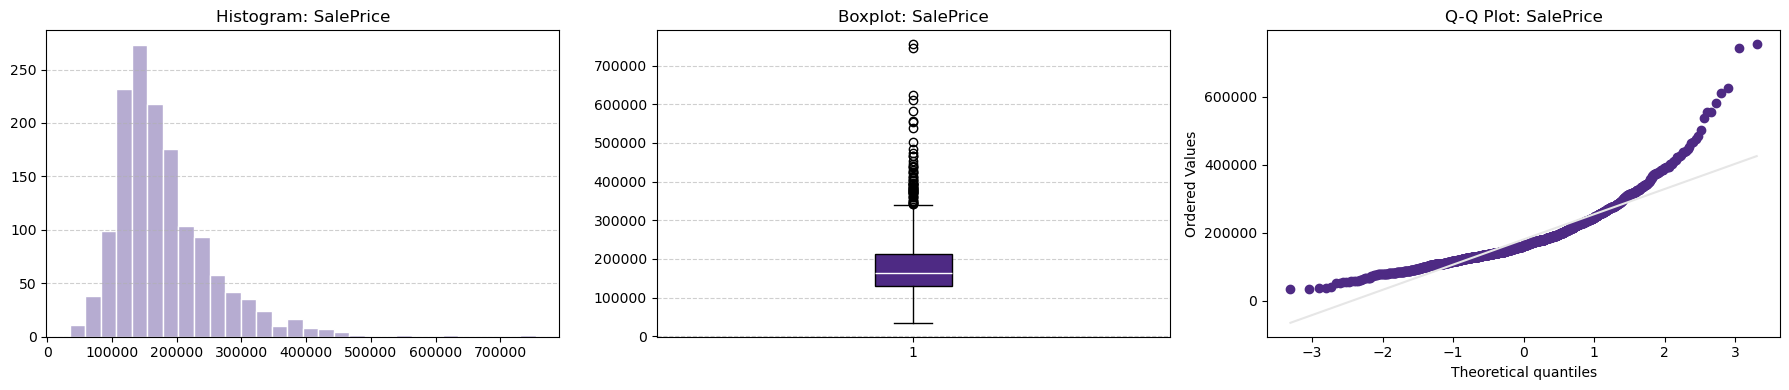

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Histogram
axes[0].hist(
    df_hencoded["SalePrice"],
    bins=30,
    color=nu_light_purple,
    edgecolor="white"
)
axes[0].set_title("Histogram: SalePrice")
axes[0].grid(axis="y", linestyle="--", alpha=0.6)

# Boxplot
axes[1].boxplot(
    df_hencoded["SalePrice"],
    patch_artist=True,
    boxprops=dict(facecolor=nu_purple),
    medianprops=dict(color="white")
)
axes[1].set_title("Boxplot: SalePrice")
axes[1].grid(axis="y", linestyle="--", alpha=0.6)

# Q-Q plot
stats.probplot(df_hencoded["SalePrice"], dist="norm", plot=axes[2])
axes[2].get_lines()[0].set_color(nu_purple)
axes[2].get_lines()[1].set_color(nu_gray)
axes[2].set_title("Q-Q Plot: SalePrice")

plt.tight_layout()
plt.show()

The distribution remains right-skewed with a small number of high-priced homes. This confirms that cleaning and feature engineering preserved the natural structure of the target variable rather than artificially smoothing or distorting it.

## Missing Values: Before vs After Cleaning
To validate the effectiveness of the preprocessing pipeline, I compare missing values in the raw training data and the cleaned dataset.

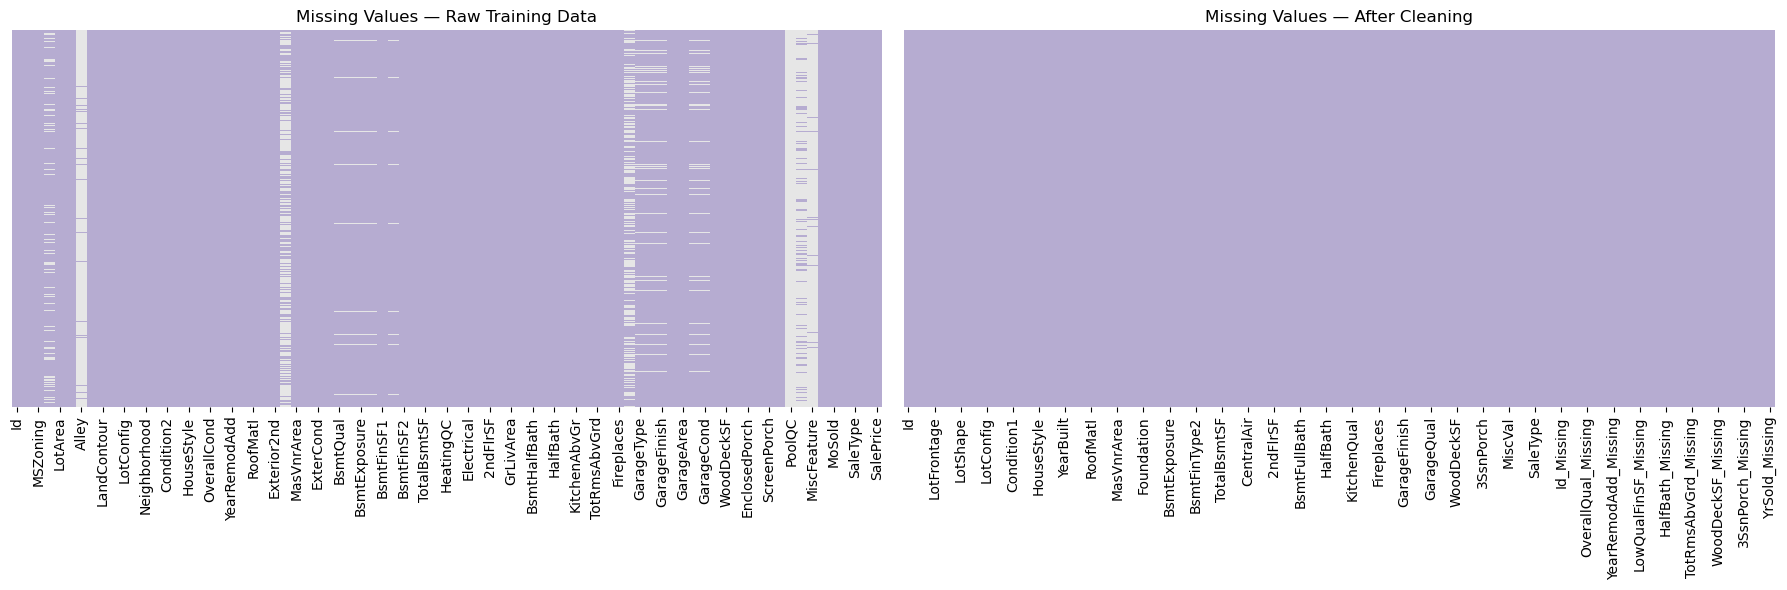

In [45]:
hmissing_before = int(htrain_df.isna().sum().sum())
hmissing_after  = int(htrain_cleaned.isna().sum().sum())

missing_summary = pd.DataFrame({
    "Stage": ["Before Cleaning", "After Cleaning"],
    "Total Missing Values": [hmissing_before, hmissing_after]
})

display(
    nu_style_table(
        missing_summary,
        caption="Missing Values Before vs After Cleaning"
    )
)


fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.heatmap(
    htrain_df.isnull(),
    cbar=False,
    cmap=missing_cmap,
    yticklabels=False,
    ax=axes[0]
)
axes[0].set_title("Missing Values — Raw Training Data")

sns.heatmap(
    htrain_cleaned.isnull(),
    cbar=False,
    cmap=missing_cmap,
    yticklabels=False,
    ax=axes[1]
)
axes[1].set_title("Missing Values — After Cleaning")

plt.tight_layout()
plt.show()

The comparison confirms that all missing values were addressed through targeted feature removal and context-aware handling. No missing values remain in the cleaned dataset.

## Engineered Feature Validation
This subsection validates the engineered features by examining their relationship with SalePrice. Visualizations are chosen based on feature type: scatter plots for numeric variables, bar charts for binary or discrete features, and boxplots for categorical features.

In [46]:
hplot_df = hdf_fe.copy()
hplot_df["SalePrice"] = htrain_df["SalePrice"].values

### Basement Features

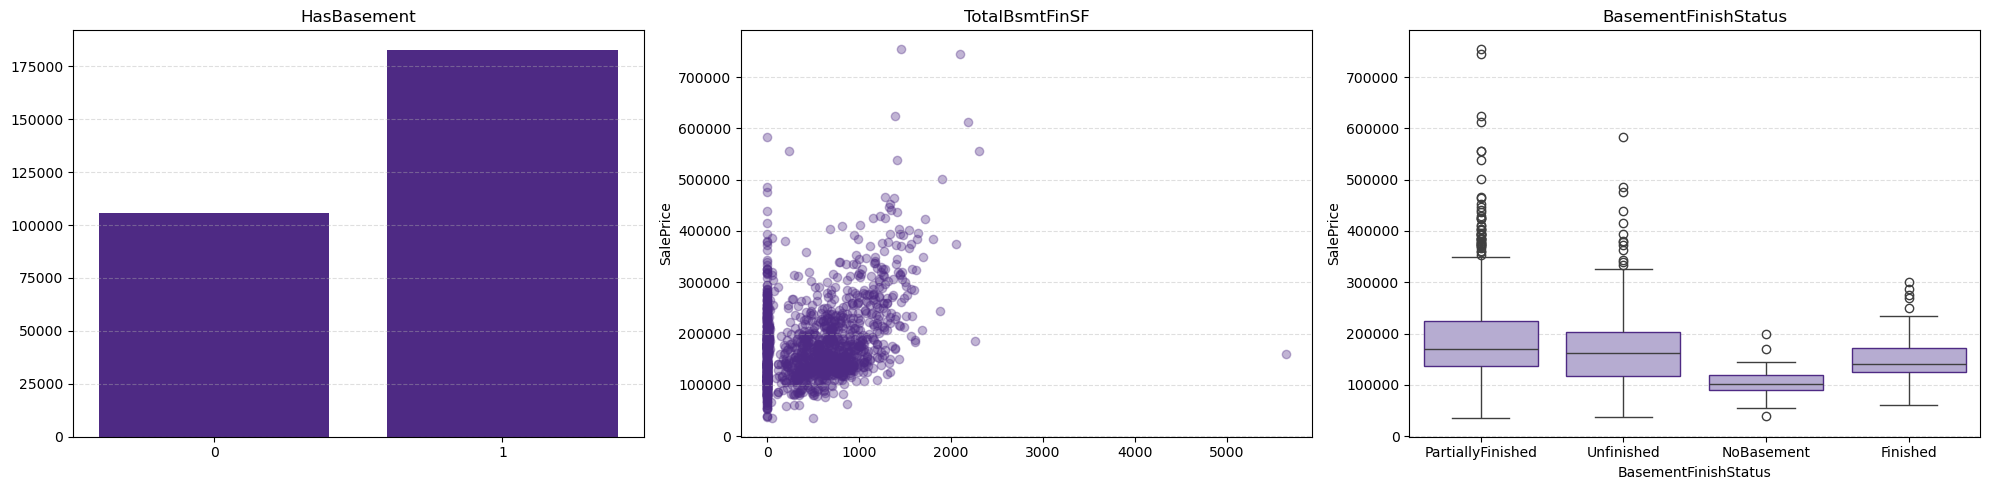

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plot_on_axis(axes[0], hplot_df, "HasBasement", "binary")
plot_on_axis(axes[1], hplot_df, "TotalBsmtFinSF", "numeric")
plot_on_axis(axes[2], hplot_df, "BasementFinishStatus", "categorical")
plt.tight_layout()
plt.show()

Basement-related engineered features show clearer and more interpretable separation than raw basement variables. Finished basements are associated with higher prices, while unfinished or absent basements cluster at lower values.

### Floors, Area, and Layout

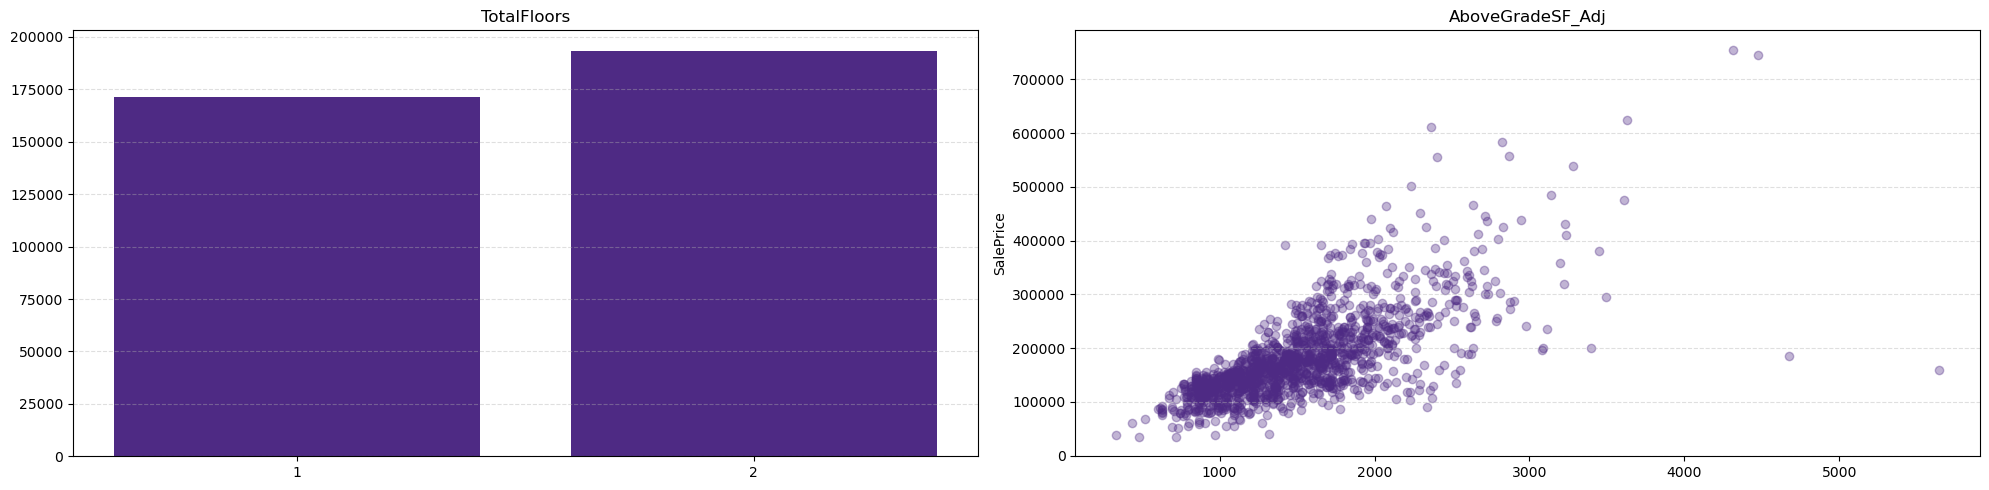

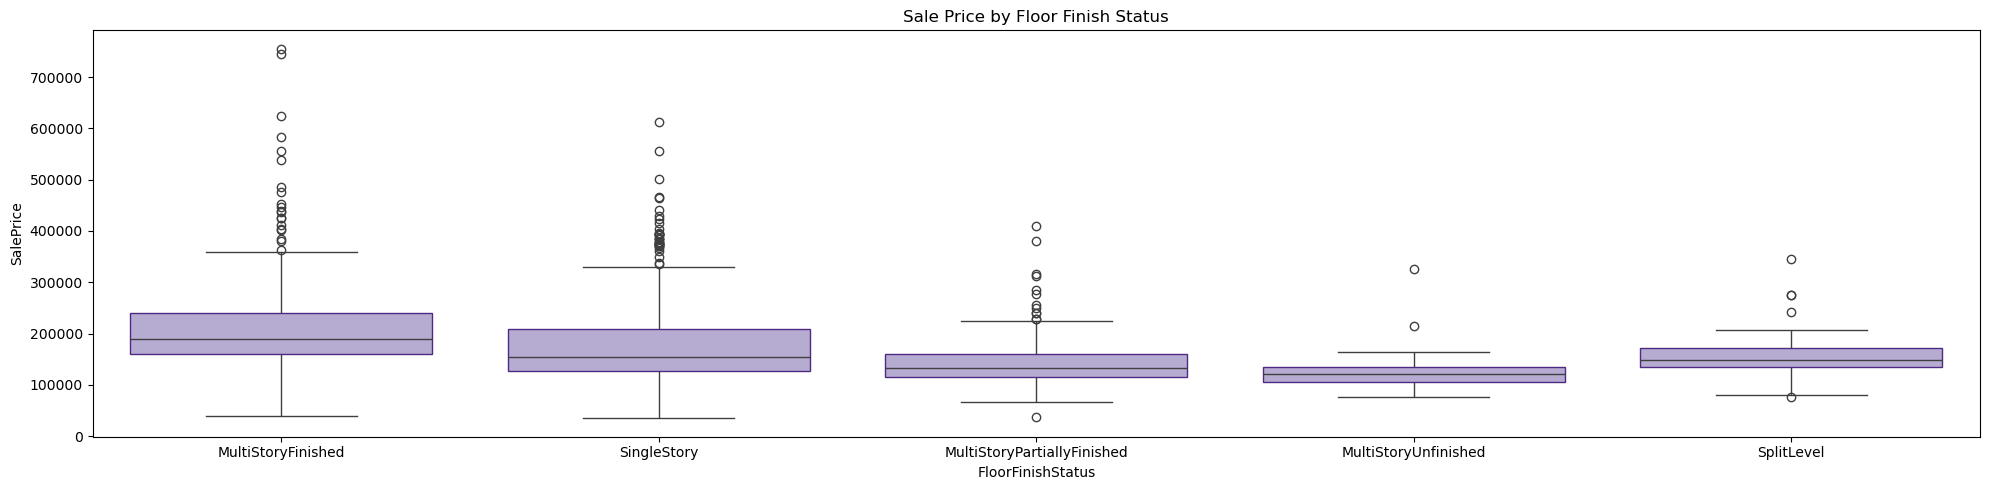

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
plot_on_axis(axes[0], hplot_df, "TotalFloors", "discrete")
plot_on_axis(axes[1], hplot_df, "AboveGradeSF_Adj", "numeric")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(
    data=hplot_df,
    x="FloorFinishStatus",
    y="SalePrice",
    ax=ax,
    boxprops=dict(facecolor=nu_light_purple, edgecolor=nu_purple)
)
ax.set_title("Sale Price by Floor Finish Status")
plt.tight_layout()
plt.show()

Engineered layout features provide clearer signals than individual square-footage components. Above-grade living space and floor count both show strong positive relationships with price.

### Amenities and Bathrooms

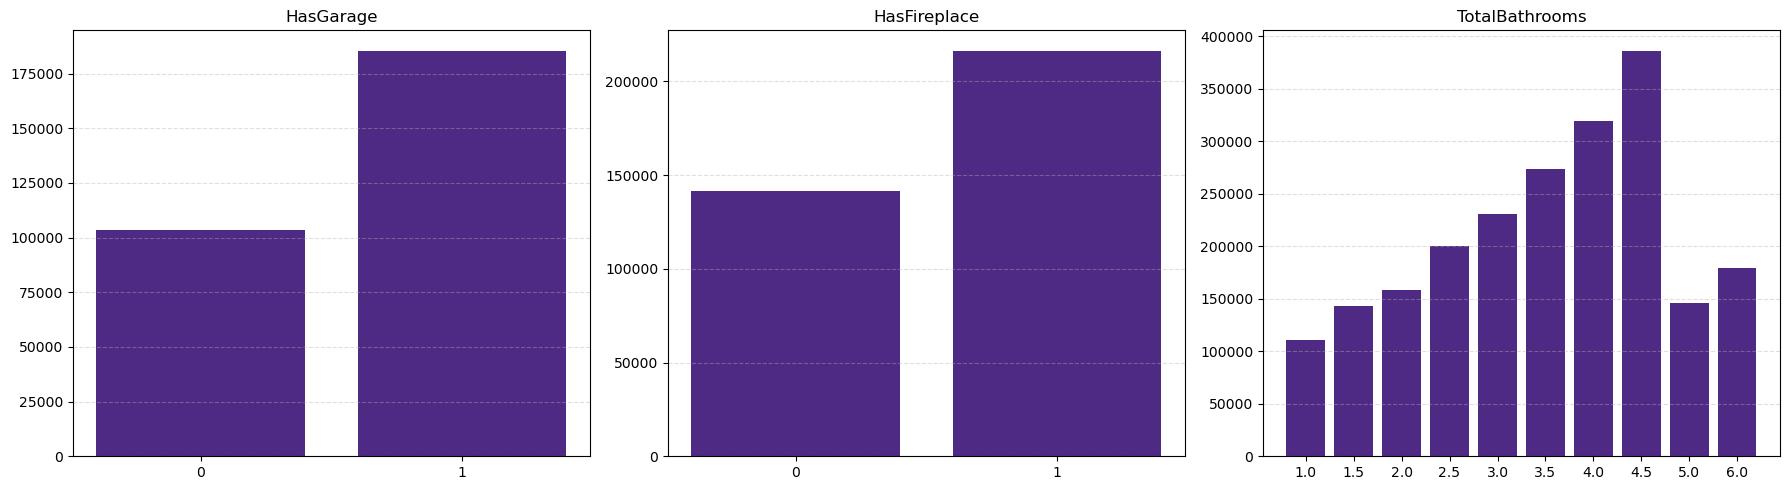

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_on_axis(axes[0], hplot_df, "HasGarage", "binary")
plot_on_axis(axes[1], hplot_df, "HasFireplace", "binary")
plot_on_axis(axes[2], hplot_df, "TotalBathrooms", "discrete")
plt.tight_layout()
plt.show()

Amenities contribute positively to price, though their effects are weaker than size-related features. TotalBathrooms shows a particularly strong relationship, supporting its use as a consolidated feature.

### Time-Related Features

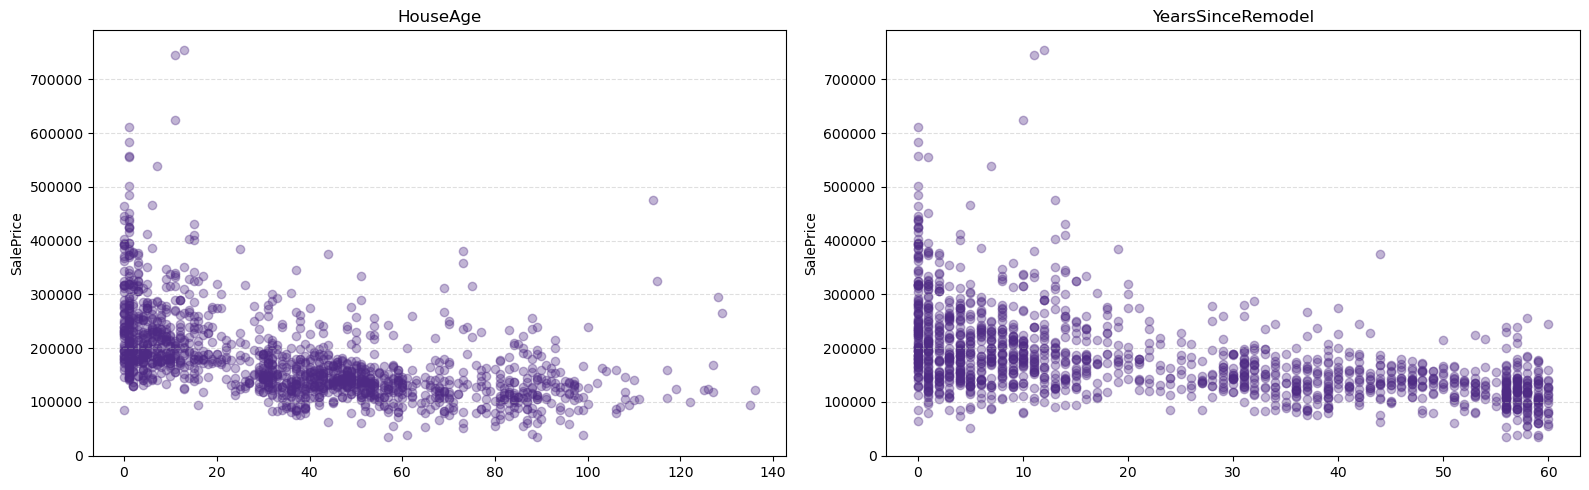

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_on_axis(axes[0], hplot_df, "HouseAge", "numeric")
plot_on_axis(axes[1], hplot_df, "YearsSinceRemodel", "numeric")
plt.tight_layout()
plt.show()

Older homes and homes that have not been remodeled recently tend to sell for less, confirming that time-based engineered features behave as expected.

### Neighborhood

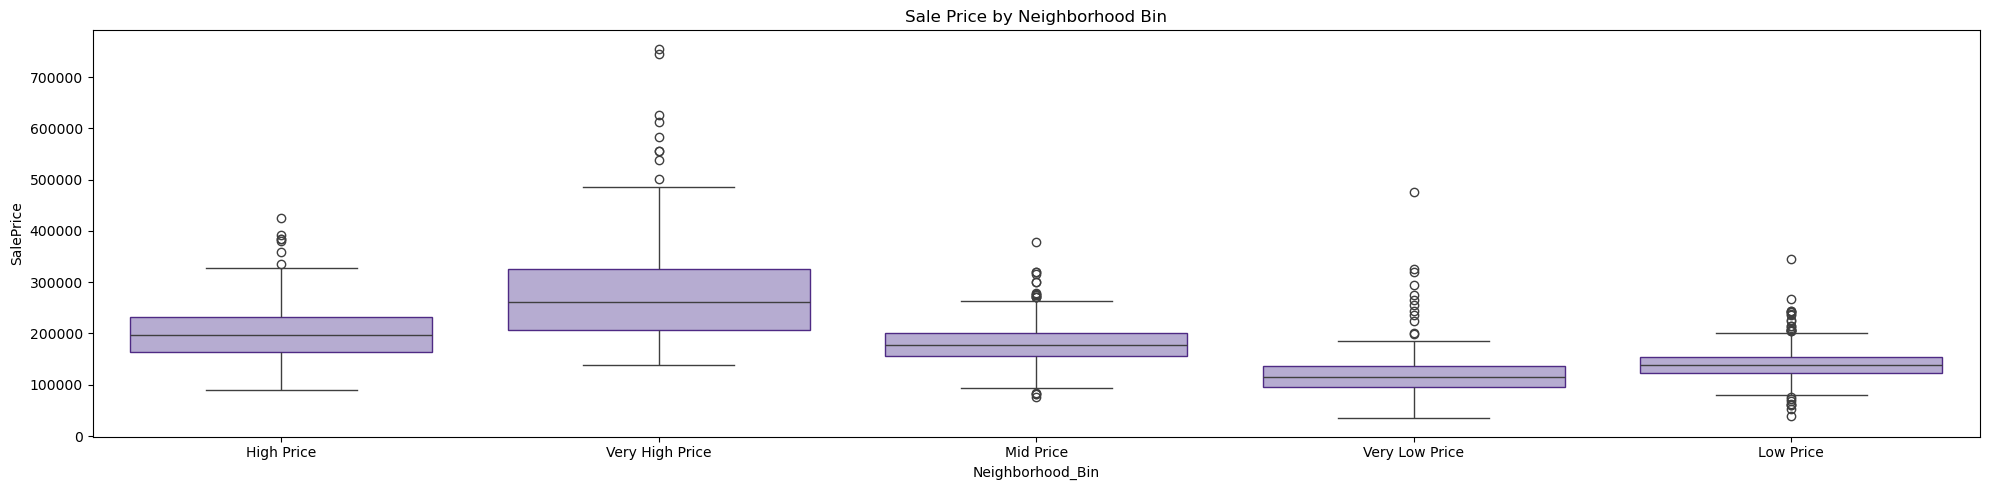

In [51]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(
    data=hplot_df,
    x="Neighborhood_Bin",
    y="SalePrice",
    ax=ax,
    boxprops=dict(facecolor=nu_light_purple, edgecolor=nu_purple)
)
ax.set_title("Sale Price by Neighborhood Bin")
plt.tight_layout()
plt.show()

The boxplot shows a clear relationship between neighborhood price bins and sale prices. Homes in higher-priced neighborhood bins generally have higher median sale prices, while lower-priced bins have lower medians. The Very High Price group shows the highest median and the widest spread, indicating both more expensive homes and greater price variability. In contrast, the Very Low Price and Low Price bins have lower medians and tighter ranges, suggesting more consistent pricing. The presence of outliers in all bins shows that expensive homes can still appear in lower-priced areas, but overall neighborhood binning captures meaningful differences in housing prices

## Correlation Analysis

### Numeric & Transformed Features

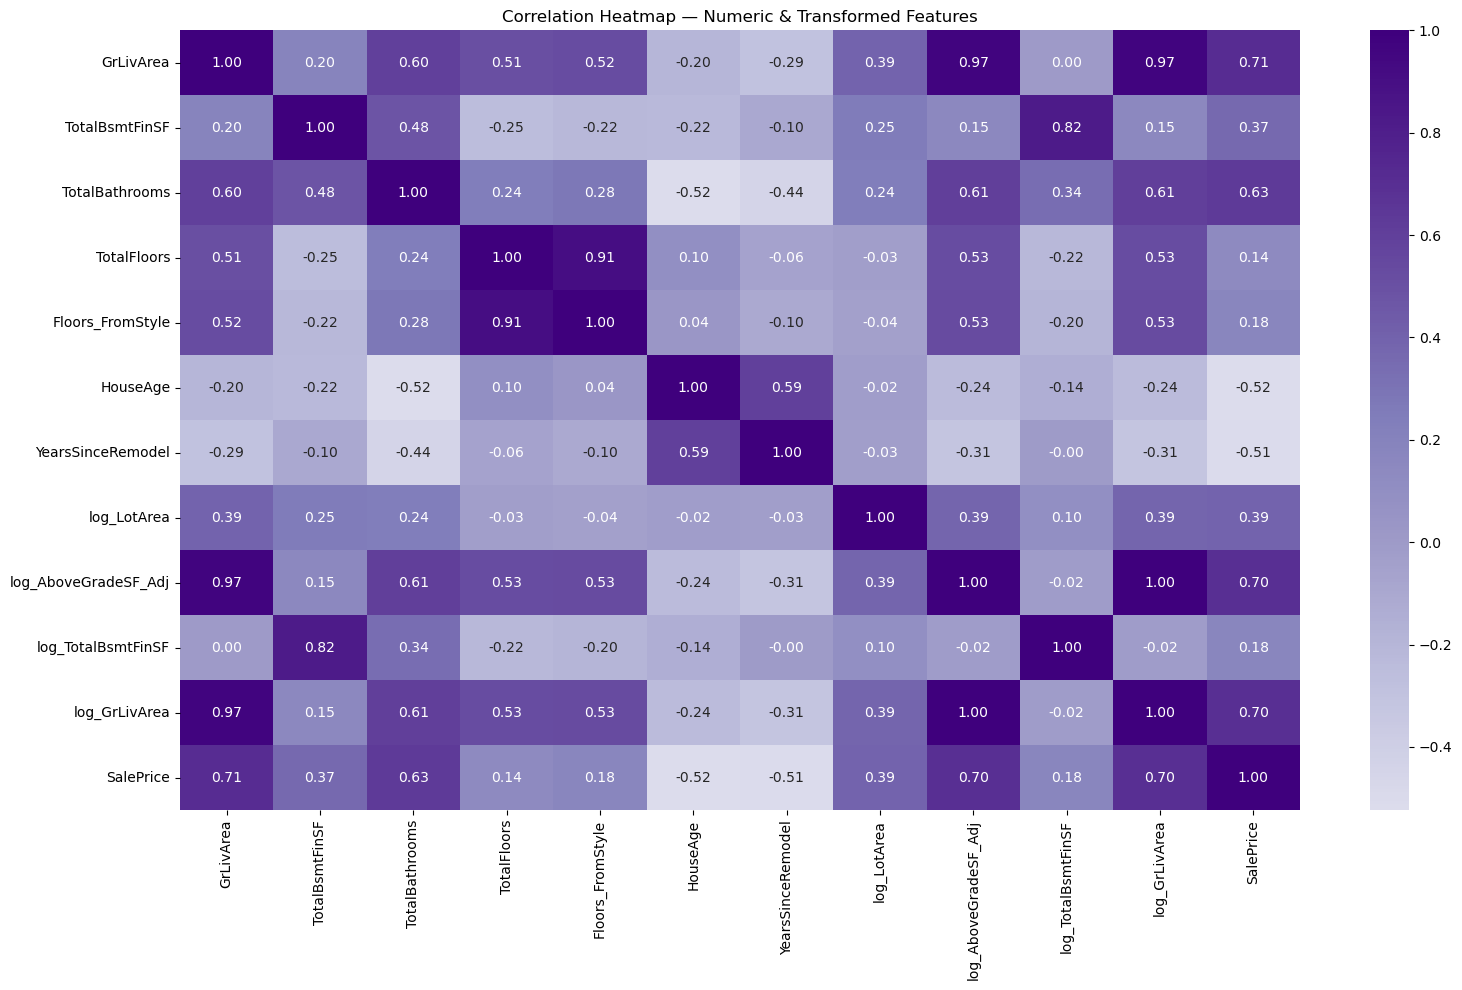

In [52]:
numeric_corr_features = [
    "GrLivArea",
    "TotalBsmtFinSF",
    "TotalBathrooms",
    "TotalFloors",
    "Floors_FromStyle",
    "HouseAge",
    "YearsSinceRemodel",
    "log_LotArea",
    "log_AboveGradeSF_Adj",
    "log_TotalBsmtFinSF",
    "log_GrLivArea",
    "SalePrice"
]

plt.figure(figsize=(16, 10))
sns.heatmap(
    hdf_fe[numeric_corr_features].corr(),
    cmap="Purples",
    center=0,
    annot=True,
    fmt=".2f"
)
plt.title("Correlation Heatmap — Numeric & Transformed Features")
plt.tight_layout()
plt.show()

Size and quality related features show strong positive correlations with SalePrice, while age-related features show negative correlations. Log-transformed variables reduce skew and maintain meaningful relationships.

### Binary & Discrete Features

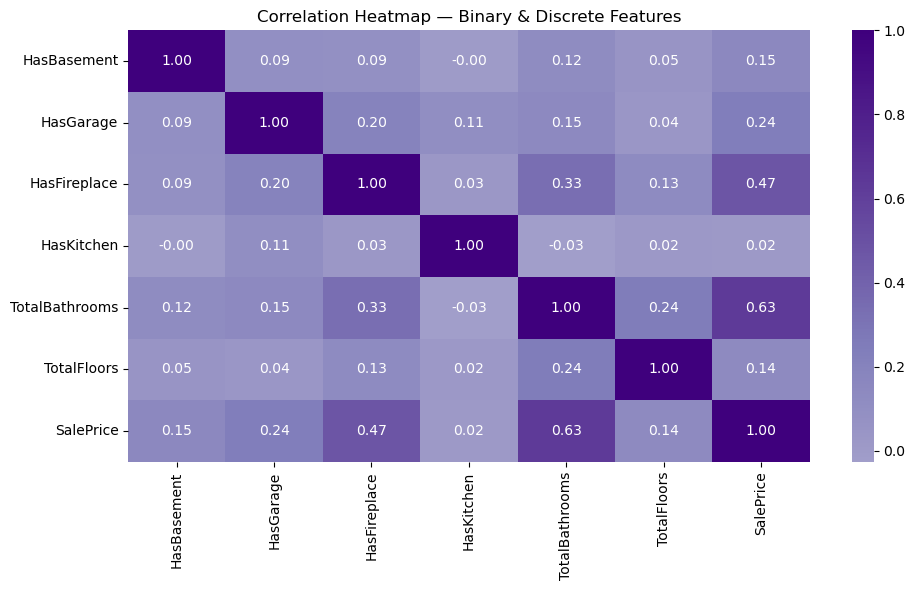

In [53]:
binary_discrete = [
    "HasBasement",
    "HasGarage",
    "HasFireplace",
    "HasKitchen",
    "TotalBathrooms",
    "TotalFloors"
]

plt.figure(figsize=(10, 6))
sns.heatmap(
    hdf_fe[binary_discrete + ["SalePrice"]].corr(),
    cmap="Purples",
    center=0,
    annot=True,
    fmt=".2f"
)
plt.title("Correlation Heatmap — Binary & Discrete Features")
plt.tight_layout()
plt.show()

Binary and discrete features capture amenity presence and structural thresholds. Their correlations are smaller than continuous size features but still meaningful.

### Categorical Engineered Features

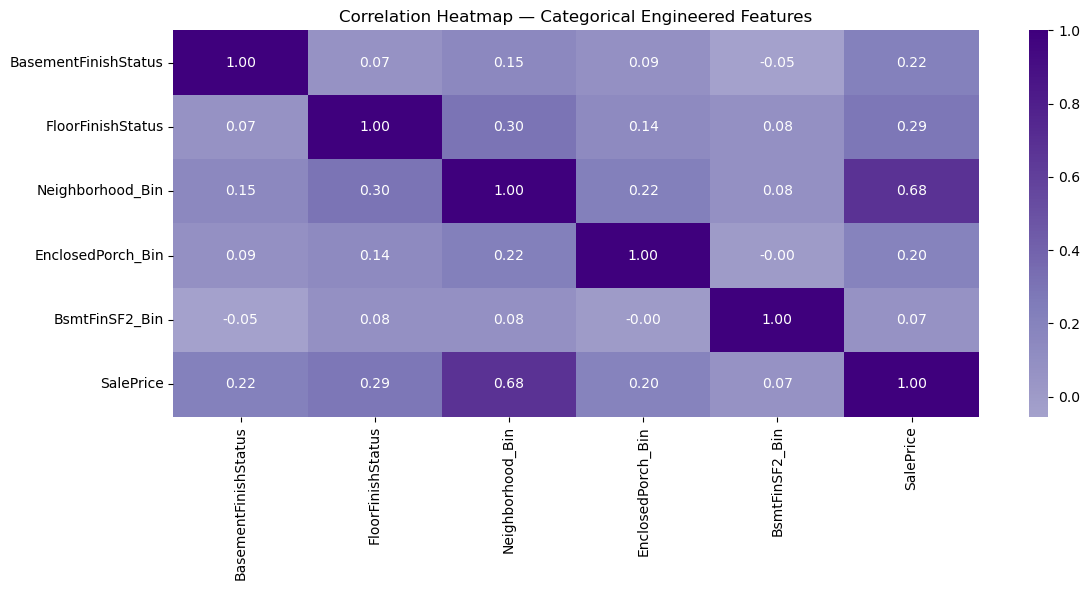

In [54]:
cat_features = [
    "BasementFinishStatus",
    "FloorFinishStatus",
    "Neighborhood_Bin",
    "EnclosedPorch_Bin",
    "BsmtFinSF2_Bin"
]

cat_corr = hdf_fe[cat_features + ["SalePrice"]].copy()

for col in cat_features:
    cat_corr[col] = cat_corr.groupby(col)["SalePrice"].transform("mean")

plt.figure(figsize=(12, 6))
sns.heatmap(
    cat_corr.corr(),
    cmap="Purples",
    center=0,
    annot=True,
    fmt=".2f"
)
plt.title("Correlation Heatmap — Categorical Engineered Features")
plt.tight_layout()
plt.show()

Neighborhood_Bin shows the strongest categorical relationship with SalePrice, confirming that location remains a dominant price driver. Other categorical features capture secondary structural and layout effects.

## Final Dataset Readiness Check
Finally, basic checks are performed to confirm that the training and test datasets are fully cleaned, encoded, and ready for modeling. These checks ensure consistency between datasets and verify that no unintended data leakage or structural issues remain before model training.

In [55]:
summary_table = pd.DataFrame({
    "Dataset": ["Training", "Test"],
    "Rows": [df_hencoded.shape[0], df_test_encoded.shape[0]],
    "Columns": [df_hencoded.shape[1], df_test_encoded.shape[1]],
    "Missing Values": [
        int(df_hencoded.isna().sum().sum()),
        int(df_test_encoded.isna().sum().sum())
    ]
})

display(
    nu_style_table(
        summary_table,
        caption="Final Dataset Summary After Cleaning and Encoding"
    )
)

# Export Cleaned Datasets

df_hencoded.to_csv("output/htrain_cleaned_encoded.csv", index=False)
df_test_encoded.to_csv("output/htest_cleaned_encoded.csv", index=False)

print("Cleaned datasets saved successfully:")
print("- output/htrain_cleaned_encoded.csv")
print("- output/htest_cleaned_encoded.csv")

Cleaned datasets saved successfully:
- output/htrain_cleaned_encoded.csv
- output/htest_cleaned_encoded.csv


The training and test datasets are fully aligned, contain zero missing values, and share identical feature structures. The dataset is now validated and ready for regression modeling.

# Regression Modeling and Evaluation

In this section, I build and compare multiple regression models using the cleaned, encoded, and feature-engineered housing dataset. The modeling workflow is divided into two parts: OLS Model Development and Regularized Regression Models (Ridge, Lasso, ElasticNet). This separation allows a clear comparison between classical linear regression and regularization-based approaches while staying within the methods covered in the course.

All models rely on linear regression techniques. Instead of introducing new algorithms, improvements are achieved through better data preparation, feature engineering, ordinal handling, outlier control, log transformations, limited polynomial expansion, and regularization. This ensures that performance gains come from meaningful structure in the data rather than unnecessary model complexity.

Model evaluation is approached from both explanatory and predictive perspectives. Explanatory performance is assessed using R² and Adjusted R² to understand how well the models explain price variation. Predictive performance is evaluated using RMSE on a holdout validation set and through k-fold cross-validation. Using both perspectives helps distinguish true improvement from overfitting.

## Overview of Modeling Strategy
Before fitting any regression models, a structured modeling strategy is defined to ensure results are fair, interpretable, and reliable. Rather than testing a single specification, a staged approach is used so the impact of each modeling decision can be evaluated independently.

The process begins with a baseline OLS model using all available encoded features. Subsequent OLS models refine this baseline by modifying the data representation rather than changing the algorithm. These refinements include focusing on engineered features, handling ordinal predictors more carefully, controlling the influence of extreme values, and introducing limited non-linearity where exploratory analysis suggested curvature.

Once a strong OLS specification is established, regularized regression models are introduced. Ridge, Lasso, and ElasticNet are used to address multicollinearity and coefficient instability while keeping the same underlying feature space. Hyperparameter tuning and cross-validation are applied so that the models can automatically balance bias and variance and identify stable, generalizable solutions.

## Train–Validation Splitting Strategy
Before fitting any regression models, the cleaned and encoded dataset is split into training and validation sets. This allows performance to be evaluated on unseen data and provides an early check for overfitting.

The same split is reused across all models to ensure fair comparison. An 80/20 split is used, and a fixed random seed ensures reproducibility. Using a consistent split makes sure that differences in performance reflect modeling choices rather than random variation in the data.

In [56]:
X = df_hencoded.drop(columns=[htarget_column])
y = df_hencoded[htarget_column]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)


# ==========================================================
# Train–Validation split for enhanced model
# ==========================================================

X_train_enhanced = X_enhanced.iloc[:ntrain_enhanced].copy()
X_test_enhanced = X_enhanced.iloc[ntrain_enhanced:].copy()
enhanced_y_log = y_log_enhanced.copy()  # already aligned after outlier removal

X_train_enhanced, X_val_enhanced, y_train_enhanced, y_val_enhanced = train_test_split(
    X_train_enhanced, enhanced_y_log, test_size=0.2, random_state=42
)

print("X_train_enhanced:", X_train_enhanced.shape, "X_val_enhanced:", X_val_enhanced.shape)

Training set shape: (1168, 313)
Validation set shape: (292, 313)
X_train_enhanced: (1163, 68) X_val_enhanced: (291, 68)


## Cross-Validation Design

To obtain more stable performance estimates, five-fold cross-validation is used in addition to the holdout validation split. Cross-validation reduces sensitivity to a single data partition and provides a more reliable estimate of predictive performance.

Performance is evaluated using RMSE, MAE, and R², capturing both error magnitude and overall goodness of fit.

In [57]:
cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2",
}

##  Indicator, Dichotomous, and Piecewise Components
Categorical variables were converted into indicator (dummy) variables during preprocessing using one-hot encoding. These binary predictors allow the regression models to capture discrete differences across neighborhoods and other categorical characteristics.

In addition, selected numeric variables were transformed into binned features during preprocessing. These binned variables introduce piecewise effects, allowing linear models to capture threshold behavior without sacrificing interpretability. Because these transformations were applied before the modeling stage, all regression models automatically incorporate indicator, dichotomous, and piecewise components without requiring special treatment during estimation.

## OLS Model Development

### Model 1:  Baseline Linear Regression
Model 1 is used as a baseline linear regression model. It includes all encoded features without any feature selection or additional adjustments. The goal of this model is to provide a reference point so that later models can be compared against it.

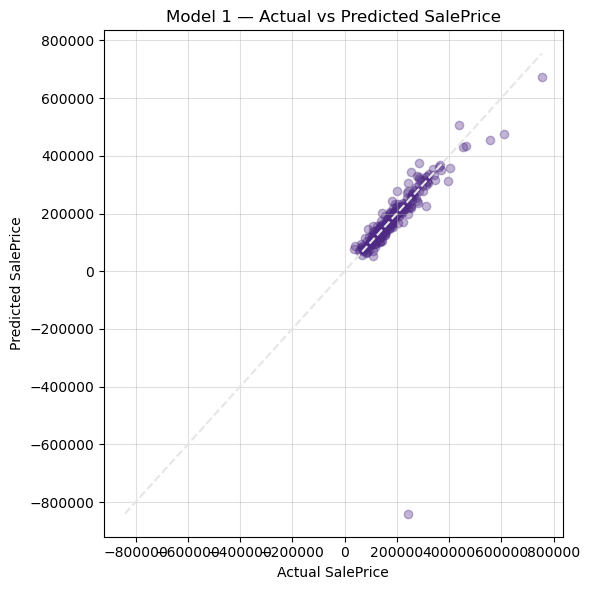

In [58]:
model_1 = LinearRegression()
model_1.fit(X_train, y_train)

y_train_pred_1 = model_1.predict(X_train)
y_val_pred_1 = model_1.predict(X_val)

model_1_holdout = pd.DataFrame({
    "Train RMSE": [np.sqrt(mean_squared_error(y_train, y_train_pred_1))],
    "Val RMSE":   [np.sqrt(mean_squared_error(y_val, y_val_pred_1))],
    "Train R²":   [r2_score(y_train, y_train_pred_1)],
    "Val R²":     [r2_score(y_val, y_val_pred_1)],
}).round(4)

model_1_cv = cv_summary(model_1, X, y, "Model 1: Baseline")

display_side_by_side(
    nu_style_table(model_1_holdout, "Model 1 — Holdout Performance"),
    nu_style_table(model_1_cv, "Model 1 — Cross-Validation Performance")
)

plot_actual_vs_pred(
    y_val,
    y_val_pred_1,
    "Model 1 — Actual vs Predicted SalePrice"
)

After evaluating the results, it is clear that Model 1 does not perform well on unseen data. While the training R² is very high (0.95), the validation R² drops to about 0.40, and the validation RMSE is much larger than the training RMSE. This large gap shows that the model fits the training data very well but does not generalize to new houses, which is a clear sign of overfitting.

In addition, some predicted sale prices become unrealistically very low and negative. This happens because a basic OLS model on the raw dollar target is very sensitive to extreme values and does not enforce non-negative predictions. These issues highlight the limitations of a simple baseline model and motivate the need for better feature engineering, transformations, and stabilization techniques in the following models.

To confirm this, I compared training and validation metrics directly. The large differences in both RMSE and R² indicate that the model is fitting noise and rare patterns in the training data rather than general relationships. Looking at the largest coefficients also shows that some rare categories and correlated features have an outsized influence on the model.

In [59]:
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model_1.coef_,
    "Abs_Coefficient": np.abs(model_1.coef_)
})

coef_df = coef_df.sort_values("Abs_Coefficient", ascending=False)

top_overfit_features = coef_df.head(20)

display(
    nu_style_table(
        top_overfit_features[["Feature", "Coefficient"]].round(4),
        caption="Model 1 — Largest Coefficients (Potential Overfitting Drivers)"
    )
)

overfit_gap = pd.DataFrame({
    "Metric": ["RMSE", "R²"],
    "Train": [
        np.sqrt(mean_squared_error(y_train, y_train_pred_1)),
        r2_score(y_train, y_train_pred_1)
    ],
    "Validation": [
        np.sqrt(mean_squared_error(y_val, y_val_pred_1)),
        r2_score(y_val, y_val_pred_1)
    ]
})

overfit_gap["Gap"] = overfit_gap["Train"] - overfit_gap["Validation"]

display(
    nu_style_table(
        overfit_gap.round(4),
        caption="Model 1 — Overfitting Diagnostic (Train vs Validation)"
    )
)

Model 1 demonstrates why using all features without control is not effective and motivates the need for feature engineering and more careful model design in the next models.

### Model 2: Engineered-Feature Linear Regression
Because Model 1 used everything after one-hot encoding, it had too many predictors and clearly overfit. So in Model 2, I narrowed the input down to a small set of engineered numeric features + Neighborhood_Bin dummy variables only.

The features were selected because they capture the main factors that influence house prices without adding unnecessary complexity. GrLivArea represents the primary above-ground living space and is one of the strongest indicators of price. TotalBsmtFinSF accounts for usable finished basement space, which adds value beyond the main floors. TotalBathrooms combines all bathroom types into a single measure, giving a clearer picture of home functionality. TotalFloors provides a simple signal about the house layout, while HouseAge reflects depreciation over time. YearsSinceRemodel captures the benefit of recent updates, which often increase sale price. Finally, Neighborhood_Bin variables represent location through price tiers, allowing the model to capture neighborhood effects without relying on many sparse raw neighborhood dummy variables.

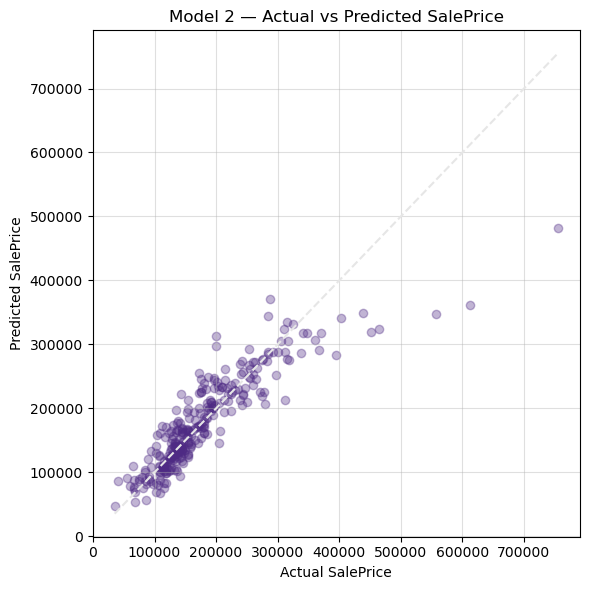

In [60]:
engineered_numeric = [
    "GrLivArea",
    "TotalBsmtFinSF",
    "TotalBathrooms",
    "TotalFloors",
    "HouseAge",
    "YearsSinceRemodel"
]

neighborhood_features = [
    c for c in df_hencoded.columns
    if c.startswith("Neighborhood_Bin_")
]

X2 = df_hencoded[engineered_numeric + neighborhood_features]
y2 = df_hencoded["SalePrice"]

X2_train, X2_val, y2_train, y2_val = train_test_split(
    X2, y2, test_size=0.2, random_state=42
)

model_2 = LinearRegression()
model_2.fit(X2_train, y2_train)

y2_train_pred = model_2.predict(X2_train)
y2_val_pred = model_2.predict(X2_val)

model_2_holdout = pd.DataFrame({
    "Train RMSE": [np.sqrt(mean_squared_error(y2_train, y2_train_pred))],
    "Val RMSE":   [np.sqrt(mean_squared_error(y2_val, y2_val_pred))],
    "Train R²":   [r2_score(y2_train, y2_train_pred)],
    "Val R²":     [r2_score(y2_val, y2_val_pred)],
}).round(4)

model_2_cv = cv_summary(model_2, X2, y2, "Model 2: Engineered Linear")

display_side_by_side(
    nu_style_table(model_2_holdout, "Model 2 — Holdout Performance"),
    nu_style_table(model_2_cv, "Model 2 — Cross-Validation Performance")
)

plot_actual_vs_pred(
    y2_val,
    y2_val_pred,
    "Model 2 — Actual vs Predicted SalePrice"
)

Model 2 performs much better than the baseline by using carefully selected engineered features, but it still assumes that all relationships with price are strictly linear. From the EDA, this may not fully reflect how size-related features behave, since very large homes do not increase in price at the same rate as smaller ones. To address this, the next model explores limited non-linear effects by adding polynomial terms only to key size variables, while keeping the rest of the model simple and interpretable.

### Model 3: Polynomial Linear Regression
In this model, I extend the engineered linear model by allowing limited non-linear effects for key size-related features. Polynomial terms are applied only to log-transformed variables such as living area and finished basement space, since these features showed diminishing returns in the exploratory analysis. This approach keeps the model stable and interpretable while giving it more flexibility than a purely linear specification. Although the model is trained using a log-transformed target for stability, all predictions and evaluation metrics are converted back to the original dollar scale to allow direct comparison with the other models.

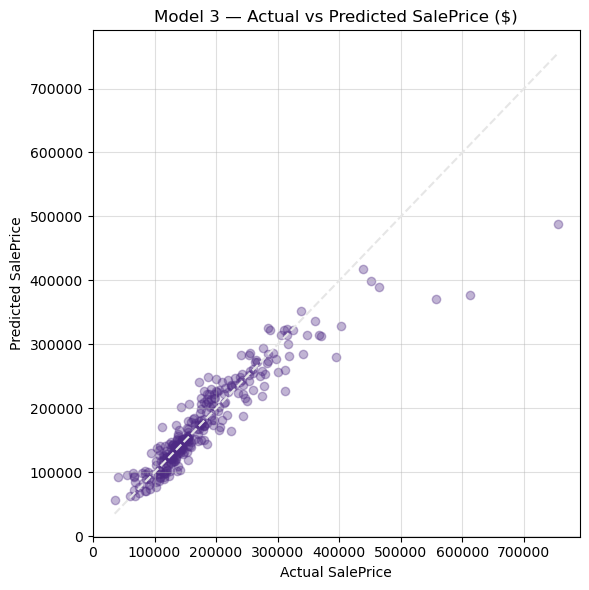

In [61]:
df_m3 = df_hencoded.copy()

y3_log = np.log1p(df_m3["SalePrice"])

X3_all = df_m3.drop(columns=["SalePrice"]).copy()

features_m3 = [
    "log_GrLivArea",
    "log_TotalBsmtFinSF",
    "log_LotArea",
    "TotalBathrooms",
    "HouseAge",
    "YearsSinceRemodel",
    "OverallQual",
]

features_m3 = [c for c in features_m3 if c in X3_all.columns]
neighborhood_bins = [c for c in X3_all.columns if c.startswith("Neighborhood_Bin_")]

X3 = X3_all[features_m3 + neighborhood_bins].fillna(
    X3_all[features_m3 + neighborhood_bins].median(numeric_only=True)
)

poly_features = ["log_GrLivArea", "log_TotalBsmtFinSF", "log_LotArea"]

preprocess_poly = ColumnTransformer(
    transformers=[
        ("poly", PolynomialFeatures(degree=2, include_bias=False), poly_features)
    ],
    remainder="passthrough"
)

model_3 = Pipeline([
    ("prep", preprocess_poly),
    ("lr", LinearRegression())
])

X3_train, X3_val, y3_train, y3_val = train_test_split(
    X3, y3_log, test_size=0.2, random_state=42
)

model_3.fit(X3_train, y3_train)

y3_val_pred_log = model_3.predict(X3_val)


m3_metrics = evaluate_dollar_scale(y3_val, y3_val_pred_log)

model_3_holdout = pd.DataFrame({
    "Model": ["Model 3: Polynomial"],
    "Val RMSE ($)": [m3_metrics["RMSE ($)"]],
    "Val R² ($)":   [m3_metrics["R² ($)"]],
}).round(4)

display(nu_style_table(model_3_holdout, "Model 3 — Dollar-Scale Holdout Performance"))

model_3_cv = cv_summary_dollar_from_log_target(
    model_3,
    X3,
    df_m3["SalePrice"],
    "Model 3: Polynomial"
)

display(nu_style_table(model_3_cv, "Model 3 — Dollar-Scale Cross-Validation"))

plot_actual_vs_pred(
    np.expm1(y3_val),
    np.expm1(y3_val_pred_log),
    "Model 3 — Actual vs Predicted SalePrice ($)"
)

Model 3 shows that adding limited non-linear structure helps capture some patterns in the data, especially for size-related features. The holdout results improve compared to earlier linear models, but the cross-validation performance is weaker and less stable. This suggests that while polynomial terms can fit certain splits well, they add complexity that does not consistently generalize across different folds.

Instead of adding more polynomial complexity, the next step focuses on improving stability and interpretability. Model 4 takes a different approach by refining feature representation rather than changing the functional form. It combines the strongest engineered features, respects ordinal structure for quality variables, uses neighborhood price bins, and applies log transformations to handle skewed size variables. Importantly, the target variable is modeled on a log scale to reduce the impact of extreme prices, while evaluation and predictions are reported back in dollars.

### Model 4: Optimized OLS
This model uses aggregated engineered features, ordinal quality encoding, neighborhood price bins, and log-transformed size variables. Modeling the target on a log scale helps stabilize variance and reduces the influence of very expensive homes without removing any observations. Predictions are converted back to dollar values.

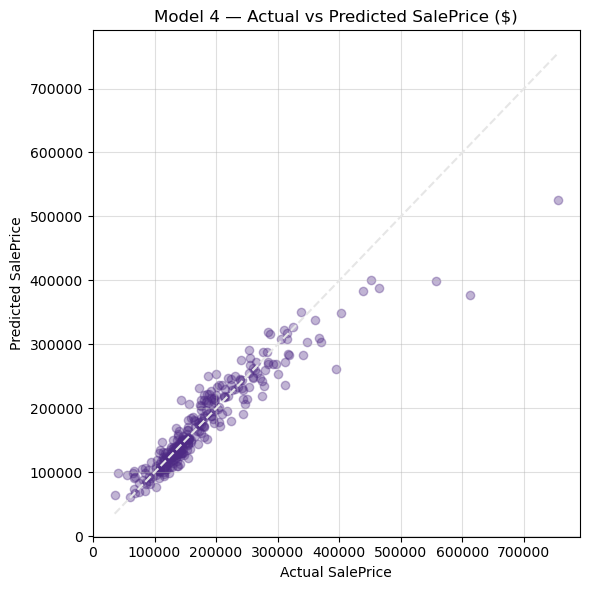

In [62]:
df_m4 = df_hencoded.copy()

y4_log = np.log1p(df_m4["SalePrice"])
X4_all = df_m4.drop(columns=["SalePrice"]).copy()

features_m4 = [
    "log_GrLivArea",
    "log_TotalBsmtFinSF",
    "log_LotArea",
    "TotalBathrooms",
    "HouseAge",
    "YearsSinceRemodel",
    "OverallQual",
    "KitchenQual",
    "ExterQual",
    "HeatingQC",
    "BsmtQual",
    "GarageQual",
]

features_m4 = [c for c in features_m4 if c in X4_all.columns]

neighborhood_bins = [c for c in X4_all.columns if c.startswith("Neighborhood_Bin_")]

X4 = X4_all[features_m4 + neighborhood_bins].fillna(
    X4_all[features_m4 + neighborhood_bins].median(numeric_only=True)
)

X4_train, X4_val, y4_train, y4_val = train_test_split(
    X4, y4_log, test_size=0.2, random_state=42
)

model_4 = LinearRegression()
model_4.fit(X4_train, y4_train)

y4_val_pred_log = model_4.predict(X4_val)

m4_metrics = evaluate_dollar_scale(y4_val, y4_val_pred_log)

model_4_holdout = pd.DataFrame({
    "Model": ["Model 4: Optimized OLS"],
    "Val RMSE ($)": [m4_metrics["RMSE ($)"]],
    "Val R² ($)":   [m4_metrics["R² ($)"]],
}).round(4)

display(
    nu_style_table(
        model_4_holdout,
        "Model 4 — Dollar-Scale Holdout Performance"
    )
)

model_4_cv = cv_summary_dollar_from_log_target(
    model_4,
    X4,
    df_m4["SalePrice"], 
    "Model 4: Optimized OLS"
)

display(
    nu_style_table(
        model_4_cv,
        "Model 4 — Dollar-Scale Cross-Validation"
    )
)

plot_actual_vs_pred(
    np.expm1(y4_val),
    np.expm1(y4_val_pred_log),
    "Model 4 — Actual vs Predicted SalePrice ($)"
)

Model 4 shows strong and stable performance on both the holdout set and cross-validation. The validation RMSE is low, and the R² values are high and fairly consistent between holdout and cross-validation. This suggests that the model generalizes well. Using aggregated engineered features, ordinal quality variables, neighborhood price bins, and log-transformed size variables helps the model capture the main drivers of sale price while keeping predictions stable and interpretable in dollar terms.

Although Model 4 performs well, the data include extreme values that can still influence linear regression estimates. To further test whether limiting the effect of these extreme observations improves stability, the next model applies an outlier-control strategy. Instead of transforming the target or removing data, Model 5 reduces the influence of very large values directly in key variables.

### Model 5: Outlier-Controlled Linear Regression
This model builds on the earlier linear regression models by improving stability through enhanced preprocessing rather than changing model complexity. The target variable, SalePrice, is modeled on a log scale to reduce skewness, and extreme observations are controlled through targeted outlier removal and skewness correction of numeric predictors.

Additional engineered features such as total square footage, total bathrooms, and age-related variables are included to better capture key drivers of housing prices. Predictors are standardized, and model performance is evaluated on a holdout set and using cross-validation, with results reported back in dollar scale for interpretability.

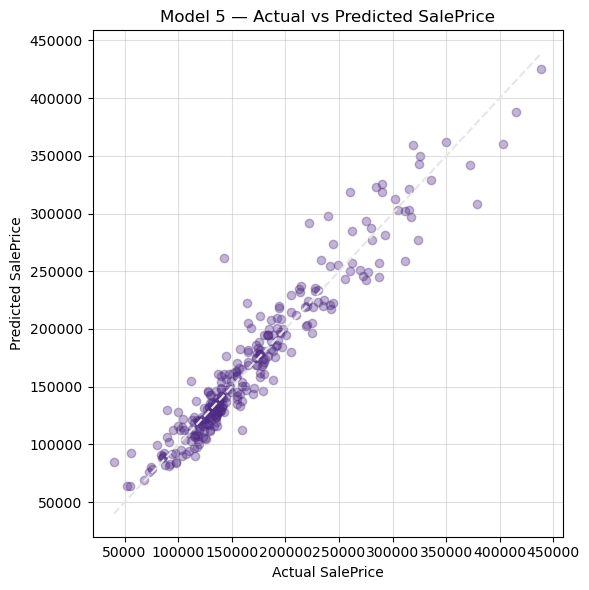

In [63]:
model_5 = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

# Fit
model_5.fit(X_train_enhanced, y_train_enhanced)

# Predict on holdout (log scale)
y_val_enhanced_pred_log = model_5.predict(X_val_enhanced)

# Convert back to $ for interpretability 
m5 = evaluate_dollar_scale(y_val_enhanced, y_val_enhanced_pred_log)

model_5_holdout = pd.DataFrame({
    "Model": ["Model 5: Outlier-Controlled Engineered"],
    "Val RMSE ($)": [m5["RMSE ($)"]],
    "Val R² ($)":   [m5["R² ($)"]],
}).round(4)

# Cross-validation (dollar scale from log target)
model_5_cv = cv_summary_dollar_from_log_target(
    model_5,
    X_enhanced.iloc[:ntrain_enhanced],       
    train_raw["SalePrice"].astype(float),   
    "Model 5: Outlier-Controlled Engineered"
)

display_side_by_side(
    nu_style_table(model_5_holdout, "Model 5 — Holdout Performance"),
    nu_style_table(model_5_cv, "Model 5 — Cross-Validation Performance")
)

# Actual vs predicted plot in dollars
plot_actual_vs_pred(
    np.expm1(y_val_enhanced),
    np.expm1(y_val_enhanced_pred_log),
    "Model 5 — Actual vs Predicted SalePrice"
)

Model 5 shows very strong results after using enhanced preprocessing and feature engineering. The holdout RMSE is about $19,300 with an R² of 0.92, which means the model explains most of the variation in house prices on unseen data.

The cross-validation results are also strong and consistent. The average CV RMSE is around $22,700, and the CV R² stays high at 0.92. The small gap between holdout and CV results shows that the model generalizes well and is not overfitting.

Overall, Model 5 is the best-performing OLS model in this project and provides a strong, reliable baseline before moving to more advanced methods.

Even though Model 5 performs very well, it is still an OLS model and can be affected by multicollinearity when features are highly correlated. To address this, the next section explores regularized regression models (Ridge, Lasso, and ElasticNet), which add penalties to improve stability and reduce overfitting.

## Regularized Regression Models (Ridge, Lasso, ElasticNet)
In this section, I apply regularized regression models to address multicollinearity and potential overfitting that can still affect OLS models, even after strong preprocessing. Ridge, Lasso, and ElasticNet add penalty terms that shrink coefficients, which helps stabilize the model when predictors are highly correlated.

All regularized models use standardized predictors (since these methods are scale-sensitive) and are trained on the log-transformed target, log1p(SalePrice), for better numerical stability. For interpretability, all results are reported back in dollar scale using expm1.

Each method is evaluated in two versions. The “a” models use all encoded features to study the effect of regularization alone. The “b” models use the enhanced preprocessing and feature engineering introduced in Model 5, focusing on a cleaner and more informative feature set. This setup allows a clear comparison between regularization alone and regularization combined with improved feature design.

### Regularization-ready Preprocessing
Before fitting the regularized models, I set up a consistent target and feature structure that can be reused across Ridge, Lasso, and ElasticNet. Because regularization depends on coefficient size, predictors are standardized inside a pipeline so all features are penalized fairly.

I also model SalePrice on a log scale using log1p. This reduces right-skewness and makes training more stable. During evaluation and Kaggle submission, predictions are converted back to dollars using expm1 so results stay interpretable.

To keep the comparison clear, I prepare two feature inputs. First, X_reg contains the full encoded feature set for the “a” models (all features). Second, X_sel_enhanced contains the enhanced feature set for the “b” models. This enhanced set follows the same stronger preprocessing and feature engineering used in Model 5, so the “b” models start from cleaner predictors instead of hundreds of weak variables.

In [64]:
# ----------------------------
# Target (log scale)
# ----------------------------
df_reg = df_hencoded.copy()
y_dollar = df_reg["SalePrice"].astype(float)
y_log = np.log1p(y_dollar)

# ----------------------------
# A models: all encoded features
# ----------------------------
X_reg = df_reg.drop(columns=["SalePrice"]).copy()
X_reg = X_reg.fillna(X_reg.median(numeric_only=True))

print("X_reg (all encoded) shape:", X_reg.shape)

# ----------------------------
# B models: enhanced feature matrix
# ----------------------------

X_sel_enhanced = X_enhanced.iloc[:ntrain_enhanced].copy()

# Safety: make sure everything is numeric
X_sel_enhanced = X_sel_enhanced.apply(pd.to_numeric, errors="coerce")
X_sel_enhanced = X_sel_enhanced.fillna(X_sel_enhanced.median(numeric_only=True))

y_log_sel_enhanced = y_log_enhanced.copy()

print("X_sel_enhanced (enhanced features) shape:", X_sel_enhanced.shape)
print("y_log_sel_enhanced shape:", y_log_sel_enhanced.shape)

X_reg (all encoded) shape: (1460, 313)
X_sel_enhanced (enhanced features) shape: (1454, 68)
y_log_sel_enhanced shape: (1454,)


### Model 6: Ridge Regression 
Ridge regression helps when many predictors are correlated. Instead of dropping features, Ridge shrinks coefficients toward zero, which reduces instability caused by multicollinearity.

In this section, Ridge is tested in two stages. Model 6a uses the full encoded feature set to examine whether regularization alone is sufficient. Model 6b applies Ridge to the enhanced feature set introduced in Model 5, allowing the model to start from cleaner, stronger predictors and improve stability and generalization.

#### Model 6a: Ridge Regression (All Encoded Features)
Model 6a applies Ridge using all available encoded predictors. This tests whether Ridge can control overfitting without any manual feature selection. Since Ridge is sensitive to feature scale, predictors are standardized inside the pipeline. The model is trained on log(SalePrice) and evaluated back in dollars.

##### Hyperparameter Tuning

Ridge is tuned across a wide range of alpha values using five-fold cross-validation. Alpha controls regularization strength: small alpha means very light shrinkage, while large alpha applies stronger shrinkage.

In [65]:
X6a = X_reg.copy()
X6a = X6a.fillna(X6a.median(numeric_only=True))

X6a_train, X6a_val, y6a_train, y6a_val = train_test_split(
    X6a, y_log, test_size=0.2, random_state=42
)

ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", Ridge())
])

ridge_grid = {"reg__alpha": np.logspace(-3, 5, 40)}

ridge_search = GridSearchCV(
    ridge_pipe,
    ridge_grid,
    cv=cv,
    scoring=scoring,
    refit="rmse",
    n_jobs=-1
)

ridge_search.fit(X6a_train, y6a_train)

model_6a = ridge_search.best_estimator_
best_alpha_6a = ridge_search.best_params_["reg__alpha"]
print("Best alpha (6a):", best_alpha_6a)

Best alpha (6a): 554.1020330009492


##### Ridge Tuning Curve

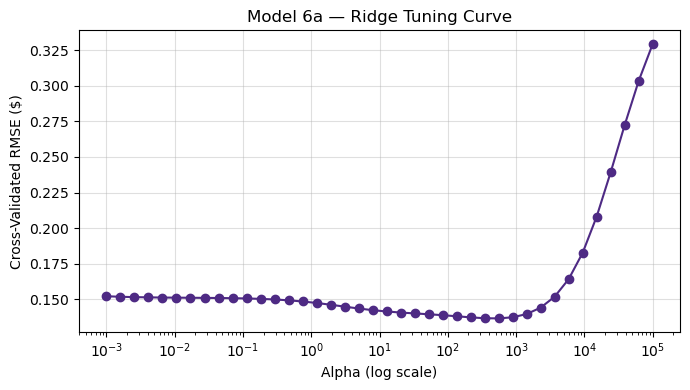

In [66]:
ridge_tuning_df = pd.DataFrame({
    "alpha": ridge_search.cv_results_["param_reg__alpha"].astype(float),
    "CV RMSE": -ridge_search.cv_results_["mean_test_rmse"]
}).sort_values("alpha")

plt.figure(figsize=(7, 4))
plt.plot(
    ridge_tuning_df["alpha"],
    ridge_tuning_df["CV RMSE"],
    marker="o",
    color=nu_purple
)
plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Cross-Validated RMSE ($)")
plt.title("Model 6a — Ridge Tuning Curve")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

The tuning curve shows how cross-validated RMSE changes as alpha increases. The best alpha is chosen where RMSE reaches its minimum. This curve also helps show where the model begins to underfit when alpha becomes too large.

##### Model 6a Performance

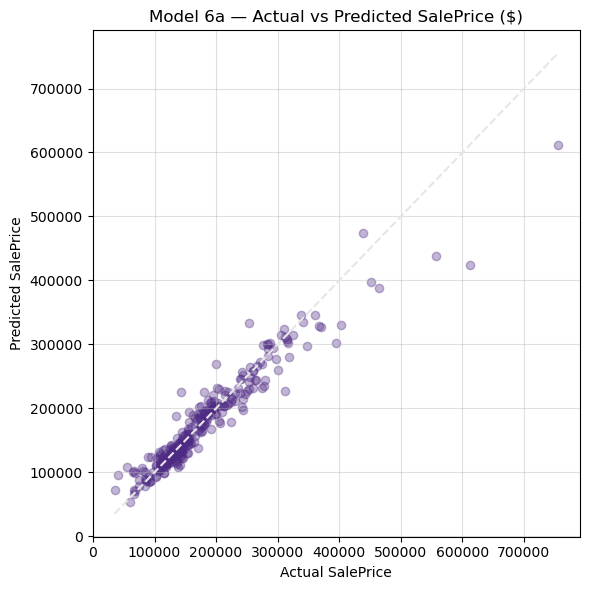

In [67]:
y6a_val_pred_log = model_6a.predict(X6a_val)
m6a = evaluate_dollar_scale(y6a_val, y6a_val_pred_log)

model_6a_holdout = pd.DataFrame({
    "Model": ["Model 6a: Ridge (all features)"],
    "Val RMSE ($)": [m6a["RMSE ($)"]],
    "Val R² ($)":   [m6a["R² ($)"]],
    "Best alpha":   [best_alpha_6a],
}).round(4)

model_6a_cv = cv_summary_dollar_from_log_target(
    Pipeline([
        ("scaler", StandardScaler()),
        ("reg", Ridge(alpha=best_alpha_6a))
    ]),
    X6a,
    df_reg["SalePrice"],
    "Model 6a: Ridge (all features)"
)

display_side_by_side(
    nu_style_table(model_6a_holdout, "Model 6a — Holdout (Dollar Scale)"),
    nu_style_table(model_6a_cv,      "Model 6a — Cross-Validation (Dollar Scale)")
)

plot_actual_vs_pred(
    np.expm1(y6a_val),
    np.expm1(y6a_val_pred_log),
    "Model 6a — Actual vs Predicted SalePrice ($)"
)

Model 6a looks strong on the holdout split, with RMSE around 26K and R² around 0.91. However, cross-validation tells a different story: CV RMSE jumps to about 44.6K and CV R² drops to about 0.39. This big gap suggests the holdout performance is not reliable and the model does not generalize consistently across folds.

Even with Ridge shrinkage, using all encoded features still keeps many weak predictors in the model. This makes the model unstable across different training splits. Because of this, Model 6a is useful mainly as a diagnostic: it shows that regularization alone is not enough when the feature space is very large.

##### Top Coefficients (Feature Importance)
Because Ridge keeps all selected predictors, feature importance is examined using the largest standardized coefficients.

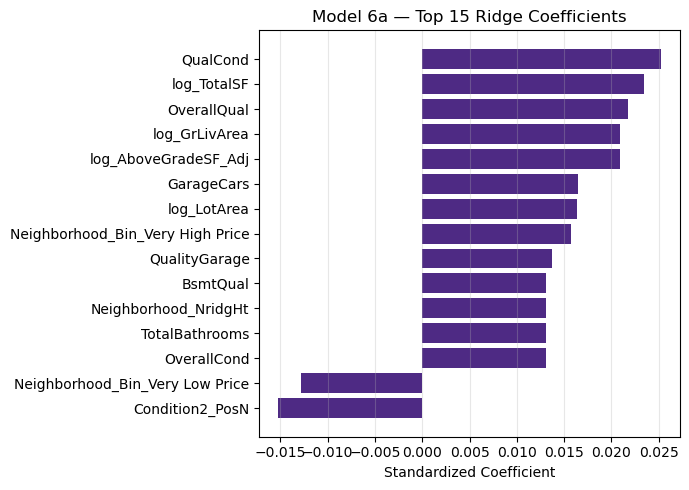

In [68]:
# Get feature names and coefficients from the tuned ridge pipeline
ridge_coef_6a = model_6a.named_steps["reg"].coef_
ridge_features_6a = X6a.columns

coef_6a_df = pd.DataFrame({
    "Feature": ridge_features_6a,
    "Coefficient": ridge_coef_6a,
    "Abs_Coefficient": np.abs(ridge_coef_6a)
}).sort_values("Abs_Coefficient", ascending=False)

top_6a = coef_6a_df.head(15)[["Feature", "Coefficient"]].round(6)

display(
    nu_style_table(
        top_6a,
        caption="Model 6a — Top Coefficients (Ridge, standardized)"
    )
)

top_plot_6a = coef_6a_df.head(15).copy()
top_plot_6a = top_plot_6a.sort_values("Coefficient")

plt.figure(figsize=(7, 5))
plt.barh(top_plot_6a["Feature"], top_plot_6a["Coefficient"], color=nu_purple)
plt.xlabel("Standardized Coefficient")
plt.title("Model 6a — Top 15 Ridge Coefficients")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

Since Ridge keeps all features, “importance” is shown using the largest standardized coefficients. The top coefficients mostly reflect size and quality variables, which matches housing intuition. Neighborhood effects are present but smaller, showing Ridge is shrinking these effects rather than allowing them to dominate.

Even though the strongest drivers make sense, the model still spreads small weights across many predictors, which helps explain the weak cross-validation performance. This motivates Model 6b, where Ridge is applied to a cleaner feature set.

#### Model 6b: Ridge Regression (Selected Feature Set)
Model 6b applies Ridge regression using the enhanced selected feature set (the same strong engineered features used in Model 5). This keeps the inputs focused on the main signals (size, quality, age/remodeling, and a small set of key categories) instead of hundreds of weak predictors. Ridge then helps stabilize the model by shrinking correlated coefficients, which reduces multicollinearity problems.

##### Hyperparameter Tuning
For Model 6b, the Ridge regularization strength (alpha) is selected using five-fold cross-validation. Alpha controls how strongly the coefficients are shrunk toward zero. Smaller values apply weaker regularization, while larger values apply stronger shrinkage.

Cross-validation is used to find an alpha that balances bias and variance. The goal is to stabilize the coefficients and reduce multicollinearity without removing important signal from the enhanced feature set. The final model uses the alpha value that minimizes cross-validated RMSE.

In [69]:
#  Use the enhanced selected features (b-models)
# ----------------------------
X6b = X_sel_enhanced.iloc[:ntrain_enhanced].copy() 
y6b = y_log_enhanced.copy()  

# Reset index so X and y align (outlier removal breaks original index labels)
X6b = X6b.reset_index(drop=True)
y6b = y6b.reset_index(drop=True)

# fill numeric NaNs (should be minimal after enhanced preprocessing)
X6b = X6b.fillna(X6b.median(numeric_only=True))

print("Model 6b X shape:", X6b.shape, "| y length:", len(y6b))

# ----------------------------
# 2) Train–Validation split (holdout)
# ----------------------------
X6b_train, X6b_val, y6b_train, y6b_val = train_test_split(
    X6b, y6b, test_size=0.2, random_state=42
)

# ----------------------------
# 3) Ridge pipeline + GridSearch
# ----------------------------
ridge_pipe_6b = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", Ridge())
])

ridge_grid_6b = {"reg__alpha": np.logspace(-3, 5, 40)}

ridge_search_6b = GridSearchCV(
    ridge_pipe_6b,
    ridge_grid_6b,
    cv=cv,
    scoring=scoring,
    refit="rmse",
    n_jobs=-1
)

ridge_search_6b.fit(X6b_train, y6b_train)

model_6b = ridge_search_6b.best_estimator_
best_alpha_6b = ridge_search_6b.best_params_["reg__alpha"]

print("Best alpha (6b):", best_alpha_6b)

Model 6b X shape: (1454, 68) | y length: 1454
Best alpha (6b): 32.57020655659783


##### Ridge Tuning Curve

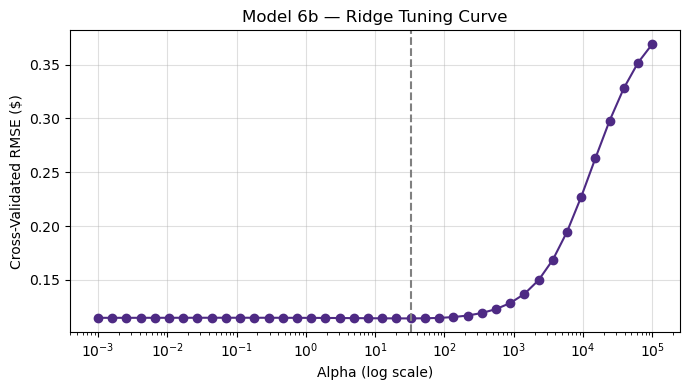

In [70]:
ridge_tuning_6b_df = pd.DataFrame({
    "alpha": ridge_search_6b.cv_results_["param_reg__alpha"].astype(float),
    "CV RMSE": -ridge_search_6b.cv_results_["mean_test_rmse"]
}).sort_values("alpha")

plt.figure(figsize=(7, 4))
plt.plot(ridge_tuning_6b_df["alpha"], ridge_tuning_6b_df["CV RMSE"], marker="o", color=nu_purple)
plt.axvline(best_alpha_6b, linestyle="--", color="gray")
plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Cross-Validated RMSE ($)")
plt.title("Model 6b — Ridge Tuning Curve")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

The tuning curve shows that the model works best at a moderate alpha value, shown by the dashed line. When alpha becomes too large, the error increases, which means the model is over-regularized and starts underfitting. This confirms that the chosen alpha gives a good balance between stability and accuracy.

##### Model 6b Performance

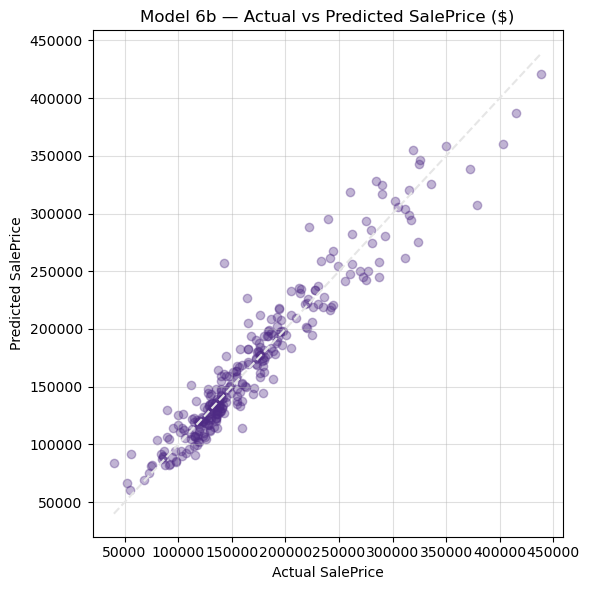

In [71]:
# Holdout predictions (log scale)
y6b_val_pred_log = model_6b.predict(X6b_val)

# Evaluate back in dollars using  helper
m6b = evaluate_dollar_scale(y6b_val, y6b_val_pred_log)

model_6b_holdout = pd.DataFrame({
    "Model": ["Model 6b: Ridge (selected features)"],
    "Val RMSE ($)": [m6b["RMSE ($)"]],
    "Val R² ($)":   [m6b["R² ($)"]],
    "Best alpha":   [best_alpha_6b],
}).round(4)

# Cross-validation (train set only), evaluated back in dollars
model_6b_cv = cv_summary_dollar_from_log_target(
    Pipeline([
        ("scaler", StandardScaler()),
        ("reg", Ridge(alpha=best_alpha_6b))
    ]),
    X6b,
    np.expm1(y6b), 
    "Model 6b: Ridge (selected features)"
)

display_side_by_side(
    nu_style_table(model_6b_holdout, "Model 6b — Holdout Performance (Dollar Scale)"),
    nu_style_table(model_6b_cv,      "Model 6b — Cross-Validation Performance (Dollar Scale)")
)

# Actual vs predicted in dollars
plot_actual_vs_pred(
    np.expm1(y6b_val),
    np.expm1(y6b_val_pred_log),
    "Model 6b — Actual vs Predicted SalePrice ($)"
)

Model 6b shows strong and consistent performance. The holdout RMSE is about 19.2K with an R² of 0.92, and the cross-validation RMSE is very close at around $22.9K with a CV R² of 0.92. The small gap between holdout and cross-validation results suggests that the model generalizes well and is not overfitting.

Compared to Model 6a, using a reduced and cleaner feature set clearly improves stability. This confirms that combining feature selection with Ridge regularization leads to a more reliable OLS-based model. Model 6b serves as a strong reference point for comparing Lasso and ElasticNet.

##### Top Coefficients (Feature Importance)

Ridge keeps all predictors, so feature importance is shown using the largest standardized coefficients. This helps highlight which enhanced predictors drive the model the most.

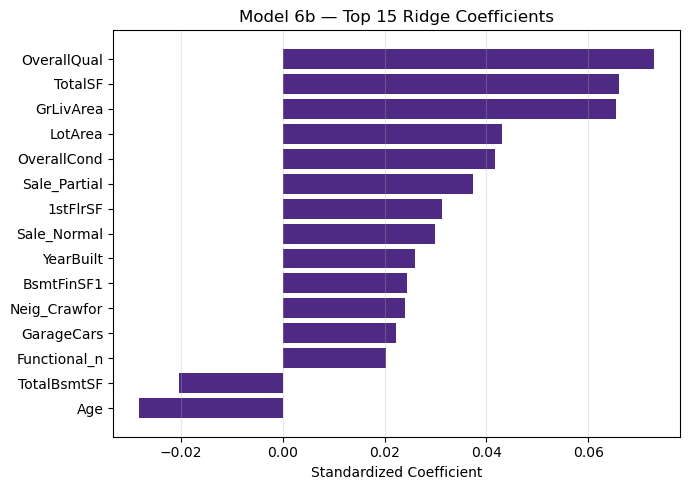

In [72]:
ridge_coef_6b = model_6b.named_steps["reg"].coef_
ridge_features_6b = X6b.columns

coef_6b_df = pd.DataFrame({
    "Feature": ridge_features_6b,
    "Coefficient": ridge_coef_6b,
    "Abs_Coefficient": np.abs(ridge_coef_6b)
}).sort_values("Abs_Coefficient", ascending=False)

top_6b = coef_6b_df.head(15)[["Feature", "Coefficient"]].round(6)

display(
    nu_style_table(
        top_6b,
        caption="Model 6b — Top Coefficients (Ridge, standardized)"
    )
)

top_plot_6b = coef_6b_df.head(15).copy().sort_values("Coefficient")

plt.figure(figsize=(7, 5))
plt.barh(top_plot_6b["Feature"], top_plot_6b["Coefficient"], color=nu_purple)
plt.xlabel("Standardized Coefficient")
plt.title("Model 6b — Top 15 Ridge Coefficients")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

The results make sense and are easy to interpret. OverallQual, TotalSF, and GrLivArea have the largest positive effects, showing that bigger and better-quality houses sell for higher prices. LotArea and OverallCond also matter, which fits housing market intuition.

Age-related features behave as expected. Age has a negative coefficient, meaning older homes sell for less, while YearBuilt is positive, showing newer homes are more valuable. Basement, garage, and sale-type features have smaller but still meaningful effects.

Overall, Ridge produces stable and reasonable coefficients with the enhanced features. This gives a solid base to move next to Lasso, which can simplify the model further by removing weak predictors.

### Model 7: Lasso Regression
Lasso regression is similar to Ridge, but with one important difference: it can shrink some coefficients all the way to zero. This allows Lasso to automatically remove weak predictors and perform feature selection.

In this section, Lasso is tested in two stages. Model 7a uses all encoded features to see how well Lasso can select useful predictors on its own. Model 7b applies Lasso to the enhanced selected feature set, allowing a fair comparison with Ridge in terms of stability, performance, and interpretability.

#### Model 7a: Lasso Regression (All Encoded Features)
Model 7a applies Lasso using all encoded predictors. Since Lasso is scale-sensitive, predictors are standardized inside a pipeline. The model is trained on log(SalePrice) and evaluated in dollars.

##### Hyperparameter Tuning
Alpha is tuned using five-fold cross-validation. Smaller alpha keeps more predictors, while larger alpha pushes more coefficients to zero and increases sparsity.

In [73]:
X7a = X_reg.copy()
X7a = X7a.fillna(X7a.median(numeric_only=True))

X7a_train, X7a_val, y7a_train, y7a_val = train_test_split(
    X7a, y_log, test_size=0.2, random_state=42
)

lasso_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", Lasso(max_iter=20000))
])

lasso_grid = {"reg__alpha": np.logspace(-4, 1, 40)}

lasso_search_7a = GridSearchCV(
    lasso_pipe,
    lasso_grid,
    cv=cv,
    scoring=scoring,
    refit="rmse",
    n_jobs=-1
)

lasso_search_7a.fit(X7a_train, y7a_train)

model_7a = lasso_search_7a.best_estimator_
best_alpha_7a = lasso_search_7a.best_params_["reg__alpha"]

print("Best alpha (7a):", best_alpha_7a)

Best alpha (7a): 0.004641588833612777


##### Lasso Tuning Curve

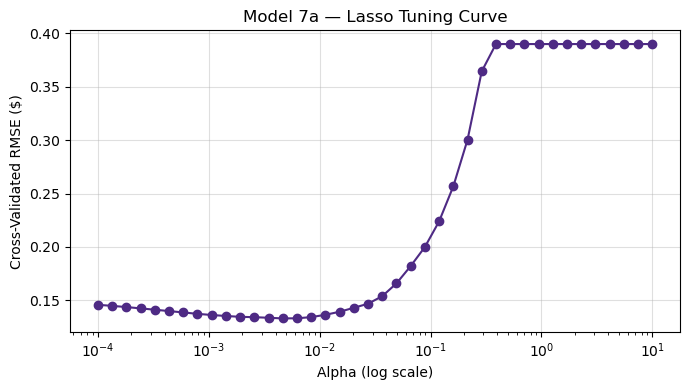

In [74]:
lasso_tuning_7a = pd.DataFrame({
    "alpha": lasso_search_7a.cv_results_["param_reg__alpha"].astype(float),
    "CV RMSE": -lasso_search_7a.cv_results_["mean_test_rmse"]
}).sort_values("alpha")

plt.figure(figsize=(7, 4))
plt.plot(
    lasso_tuning_7a["alpha"],
    lasso_tuning_7a["CV RMSE"],
    marker="o",
    color=nu_purple
)
plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Cross-Validated RMSE ($)")
plt.title("Model 7a — Lasso Tuning Curve")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

The tuning curve shows that the best performance happens at very small alpha values. When alpha becomes larger, RMSE increases quickly because Lasso removes too many predictors. This indicates the model needs only light regularization before important signals start being dropped.

##### Model 7a Performance

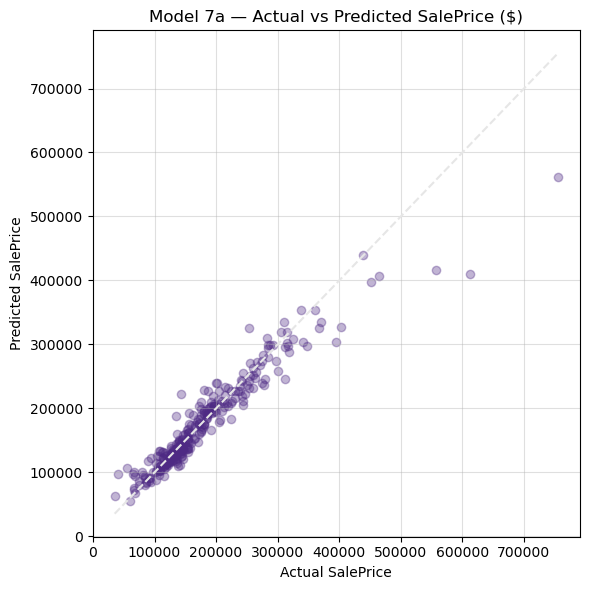

In [75]:
y7a_val_pred_log = model_7a.predict(X7a_val)
m7a = evaluate_dollar_scale(y7a_val, y7a_val_pred_log)

model_7a_holdout = pd.DataFrame({
    "Model": ["Model 7a: Lasso (all features)"],
    "Val RMSE ($)": [m7a["RMSE ($)"]],
    "Val R² ($)":   [m7a["R² ($)"]],
    "Best alpha":   [best_alpha_7a],
}).round(4)

model_7a_cv = cv_summary_dollar_from_log_target(
    Pipeline([
        ("scaler", StandardScaler()),
        ("reg", Lasso(alpha=best_alpha_7a, max_iter=20000))
    ]),
    X7a,
    df_reg["SalePrice"],
    "Model 7a: Lasso (all features)"
)

display_side_by_side(
    nu_style_table(model_7a_holdout, "Model 7a — Holdout (Dollar Scale)"),
    nu_style_table(model_7a_cv,      "Model 7a — Cross-Validation (Dollar Scale)")
)

plot_actual_vs_pred(
    np.expm1(y7a_val),
    np.expm1(y7a_val_pred_log),
    "Model 7a — Actual vs Predicted SalePrice ($)"
)

Model 7a looks strong on the holdout split (RMSE about 26.9K and R² about 0.91). But cross-validation is still weak: CV RMSE is about 41.9K and CV R² about 0.51. This gap suggests the model is not stable across folds.

This instability can happen because Lasso can pick different predictors when many correlated features are available. Small changes in the training fold can lead to different feature selection, which hurts consistency. This motivates Model 7b, where Lasso is applied to a smaller feature set.

##### Top Coefficients (Feature Selection)

Lasso removes weak predictors by setting their coefficients to zero. The table below shows the remaining strongest features.

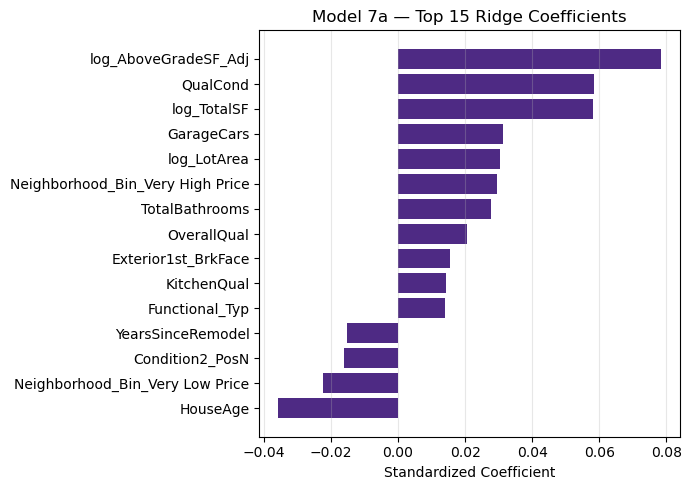

In [76]:
lasso_coef_7a = model_7a.named_steps["reg"].coef_
lasso_features_7a = X7a.columns

coef_7a_df = pd.DataFrame({
    "Feature": lasso_features_7a,
    "Coefficient": lasso_coef_7a,
    "Abs_Coefficient": np.abs(lasso_coef_7a)
})

coef_7a_df = coef_7a_df[coef_7a_df["Coefficient"] != 0]
coef_7a_df = coef_7a_df.sort_values("Abs_Coefficient", ascending=False)

top_7a = coef_7a_df.head(15)[["Feature", "Coefficient"]].round(6)

display(
    nu_style_table(
        top_7a,
        caption="Model 7a — Top Non-Zero Coefficients (Lasso)"
    )
)


top_plot_7a = coef_7a_df.head(15).copy()
top_plot_7a = top_plot_7a.sort_values("Coefficient")

plt.figure(figsize=(7, 5))
plt.barh(
    top_plot_7a["Feature"],
    top_plot_7a["Coefficient"],
    color=nu_purple
)
plt.xlabel("Standardized Coefficient")
plt.title("Model 7a — Top 15 Ridge Coefficients")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

The non-zero coefficients show that Lasso kept mostly size, quality, and neighborhood tier signals, which makes sense. However, because selection can change under correlation, this feature set can vary from fold to fold. That helps explain why cross-validation is still much worse than the holdout split.

#### Model 7b: Lasso Regression (Selected Feature Set)
Model 7b applies Lasso using the same enhanced selected feature set used in Model 6b. Starting with a smaller and cleaner set of predictors helps reduce noise, and Lasso can then remove weak signals by shrinking some coefficients exactly to zero. The model is trained on log1p(SalePrice), uses standardized predictors inside a pipeline, and is evaluated back in dollars for interpretability.

##### Hyperparameter Tuning
For Model 7b, the Lasso regularization strength (alpha) is tuned using five-fold cross-validation. Alpha controls how strongly coefficients are pushed toward zero. Smaller values keep more features, while larger values increase sparsity. The chosen alpha is the one that minimizes cross-validated RMSE.

In [77]:
# ----------------------------
# Use the enhanced selected feature set for "b" models
# ----------------------------
X7b = X_sel_enhanced.copy()

# fill numeric NaNs
X7b = X7b.fillna(X7b.median(numeric_only=True))

# Use the enhanced target (log scale)
y7b = y_log_enhanced.copy()

# ----------------------------
# Train–Validation split
# ----------------------------
X7b_train, X7b_val, y7b_train, y7b_val = train_test_split(
    X7b, y7b, test_size=0.2, random_state=42
)

# ----------------------------
# Lasso pipeline (scale -> lasso)
# ----------------------------
lasso_pipe_7b = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", Lasso(max_iter=20000))
])

# Alpha range (log-spaced)
lasso_grid_7b = {"reg__alpha": np.logspace(-4, 0, 40)}

lasso_search_7b = GridSearchCV(
    lasso_pipe_7b,
    lasso_grid_7b,
    cv=cv,
    scoring=scoring,
    refit="rmse",
    n_jobs=-1
)

# Fit tuning search
lasso_search_7b.fit(X7b_train, y7b_train)

# Best tuned model
model_7b = lasso_search_7b.best_estimator_
best_alpha_7b = lasso_search_7b.best_params_["reg__alpha"]

print("Best alpha (7b):", best_alpha_7b)

Best alpha (7b): 0.0013433993325989001


##### Lasso Tuning Curve
The tuning curve below shows how cross-validated RMSE changes as alpha increases. When alpha is too large, Lasso removes too many predictors and performance gets worse. The best alpha is marked on the plot.

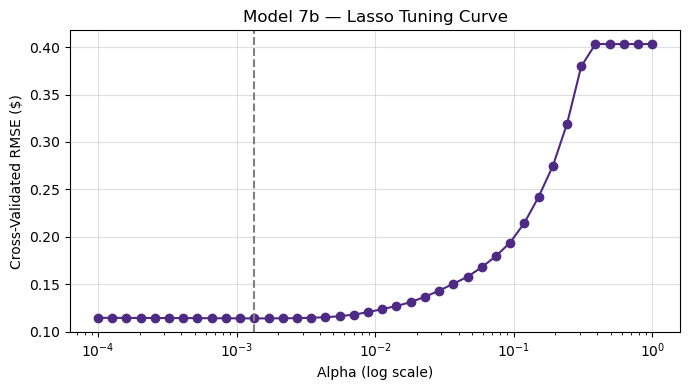

In [78]:
lasso_tuning_7b_df = pd.DataFrame({
    "alpha": lasso_search_7b.cv_results_["param_reg__alpha"].astype(float),
    "CV RMSE": -lasso_search_7b.cv_results_["mean_test_rmse"]
}).sort_values("alpha")

plt.figure(figsize=(7, 4))
plt.plot(
    lasso_tuning_7b_df["alpha"],
    lasso_tuning_7b_df["CV RMSE"],
    marker="o",
    color=nu_purple
)
plt.axvline(best_alpha_7b, linestyle="--", color="gray")
plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Cross-Validated RMSE ($)")
plt.title("Model 7b — Lasso Tuning Curve")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

The tuning curve shows that the lowest RMSE happens at very small alpha values. As alpha increases, the error goes up quickly. This means Lasso works best with light regularization on this feature set. When regularization becomes too strong, too many features are removed and the model performance drops.

##### Model 7b Performance

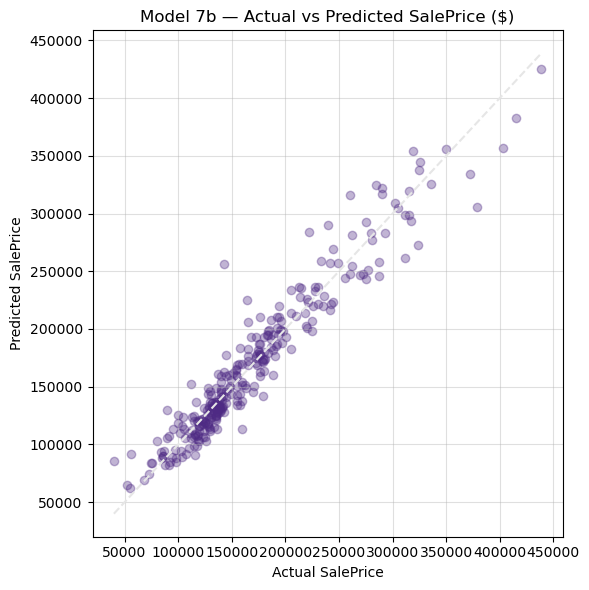

In [79]:
# Predict on holdout (log scale)
y7b_val_pred_log = model_7b.predict(X7b_val)

# Convert back to dollars for evaluation
m7b = evaluate_dollar_scale(y7b_val, y7b_val_pred_log)

model_7b_holdout = pd.DataFrame({
    "Model": ["Model 7b: Lasso (selected features)"],
    "Val RMSE ($)": [m7b["RMSE ($)"]],
    "Val R² ($)":   [m7b["R² ($)"]],
    "Best alpha":   [best_alpha_7b],
}).round(4)

# Cross-validation in dollars (from log target)
model_7b_cv = cv_summary_dollar_from_log_target(
    Pipeline([
        ("scaler", StandardScaler()),
        ("reg", Lasso(alpha=best_alpha_7b, max_iter=20000))
    ]),
    X7b,
    np.expm1(y7b),  # convert y back to dollars for the helper
    "Model 7b: Lasso (selected features)"
)

display_side_by_side(
    nu_style_table(model_7b_holdout, "Model 7b — Holdout Performance (Dollar Scale)"),
    nu_style_table(model_7b_cv,      "Model 7b — Cross-Validation Performance (Dollar Scale)")
)

plot_actual_vs_pred(
    np.expm1(y7b_val),
    np.expm1(y7b_val_pred_log),
    "Model 7b — Actual vs Predicted SalePrice ($)"
)

Model 7b also performs well, with a holdout RMSE of about $19.0K and an R² of 0.92. Cross-validation results are very similar, indicating stable generalization.

However, Model 7b performs slightly worse than Model 6b overall. This is likely because Lasso removes some correlated predictors that still contain useful shared information. In this dataset, Ridge’s ability to keep all predictors while shrinking them smoothly appears to be more effective than forcing sparsity.

##### Top Coefficients (Feature Importance)
Unlike Ridge, Lasso can remove features completely. The table below shows the strongest predictors that stayed in the model (non-zero coefficients).

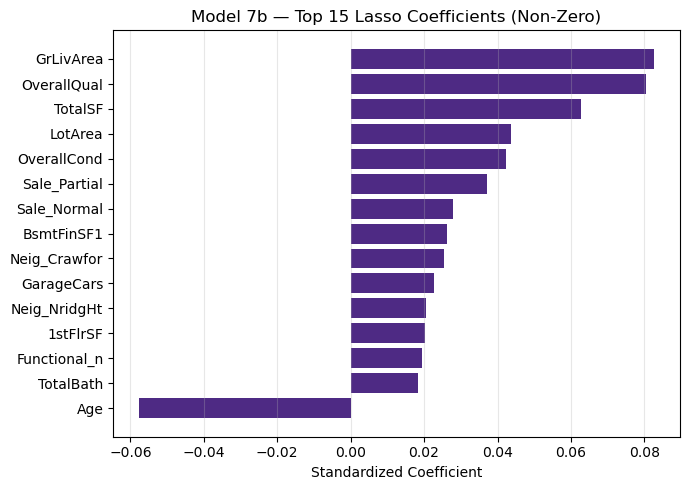

Number of non-zero coefficients (7b): 54


In [80]:
lasso_coef_7b = model_7b.named_steps["reg"].coef_
lasso_features_7b = X7b.columns

coef_7b_df = pd.DataFrame({
    "Feature": lasso_features_7b,
    "Coefficient": lasso_coef_7b
})

# Keep only non-zero coefficients
coef_7b_nonzero = coef_7b_df[coef_7b_df["Coefficient"].abs() > 1e-8].copy()
coef_7b_nonzero["Abs_Coefficient"] = coef_7b_nonzero["Coefficient"].abs()
coef_7b_nonzero = coef_7b_nonzero.sort_values("Abs_Coefficient", ascending=False)

top_7b = coef_7b_nonzero.head(15)[["Feature", "Coefficient"]].round(6)

display(
    nu_style_table(
        top_7b,
        caption="Model 7b — Top Non-Zero Coefficients (Lasso)"
    )
)

top_plot_7b = coef_7b_nonzero.head(15).copy().sort_values("Coefficient")

plt.figure(figsize=(7, 5))
plt.barh(top_plot_7b["Feature"], top_plot_7b["Coefficient"], color=nu_purple)
plt.xlabel("Standardized Coefficient")
plt.title("Model 7b — Top 15 Lasso Coefficients (Non-Zero)")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

print("Number of non-zero coefficients (7b):", coef_7b_nonzero.shape[0])

The non-zero coefficients show that Lasso mainly keeps size, quality, age, and neighborhood variables. Features like GrLivArea, OverallQual, and TotalSF stay important, while older homes have lower predicted prices.

Lasso makes the model simpler by dropping weak features, but it does not outperform Ridge here. Because Ridge keeps all features and Lasso removes some, the next step is ElasticNet, which combines both ideas.

### Model 8: ElasticNet Regression
ElasticNet combines the ideas of Ridge and Lasso. Like Ridge, it handles correlated predictors by shrinking coefficients together. Like Lasso, it can also remove weak features by shrinking some coefficients to zero.

This makes ElasticNet useful when the data has many correlated variables but we still want some feature selection. As with the previous models, ElasticNet is tested in two stages. Model 8a uses all encoded features, while Model 8b uses the selected (enhanced) feature set. The model is trained on log(SalePrice) and all results are reported back in dollars for easy interpretation.

#### Model 8a: ElasticNet Regression (All Encoded Features)
Model 8a applies ElasticNet using all encoded predictors. ElasticNet is tuned on two hyperparameters: alpha (overall regularization strength) and l1_ratio (balance between Lasso and Ridge behavior).

##### Hyperparameter Tuning
A grid search is used to tune both alpha and l1_ratio using five-fold cross-validation. This explores different levels of shrinkage and sparsity.

In [81]:
X8a = X_reg.copy()
X8a = X8a.fillna(X8a.median(numeric_only=True))

X8a_train, X8a_val, y8a_train, y8a_val = train_test_split(
    X8a, y_log, test_size=0.2, random_state=42
)

enet_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", ElasticNet(max_iter=20000))
])

enet_grid = {
    "reg__alpha": np.logspace(-4, 1, 30),
    "reg__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}

enet_search = GridSearchCV(
    enet_pipe,
    enet_grid,
    cv=cv,
    scoring=scoring,
    refit="rmse",
    n_jobs=-1
)

enet_search.fit(X8a_train, y8a_train)

model_8a = enet_search.best_estimator_
best_params_8a = enet_search.best_params_

print("Best params (8a):", best_params_8a)

Best params (8a): {'reg__alpha': 0.01743328822199989, 'reg__l1_ratio': 0.3}


##### ElasticNet Tuning Curve

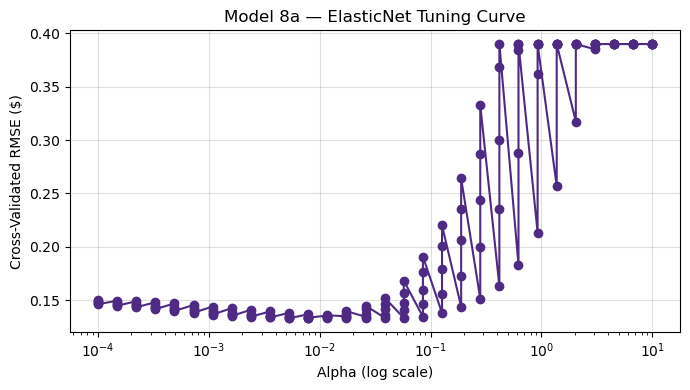

In [82]:
enet_tuning_df = pd.DataFrame({
    "alpha": enet_search.cv_results_["param_reg__alpha"].astype(float),
    "CV RMSE": -enet_search.cv_results_["mean_test_rmse"]
})

plt.figure(figsize=(7, 4))
plt.plot(enet_tuning_df["alpha"], enet_tuning_df["CV RMSE"], marker="o", color=nu_purple)
plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Cross-Validated RMSE ($)")
plt.title("Model 8a — ElasticNet Tuning Curve")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

The tuning curve shows how RMSE changes with alpha. This helps visualize where the model performs best and where performance degrades due to underfitting.

##### Model 8a Performance

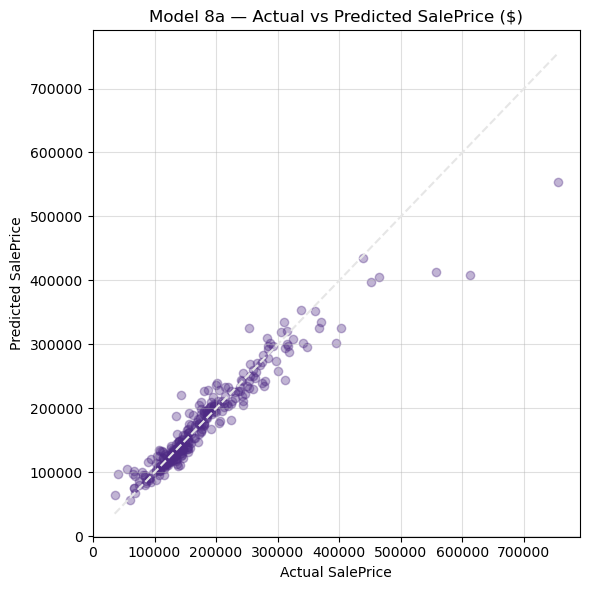

In [83]:
y8a_val_pred_log = model_8a.predict(X8a_val)
m8a = evaluate_dollar_scale(y8a_val, y8a_val_pred_log)

model_8a_holdout = pd.DataFrame({
    "Model": ["Model 8a: ElasticNet (all features)"],
    "Val RMSE ($)": [m8a["RMSE ($)"]],
    "Val R² ($)":   [m8a["R² ($)"]],
    "Best alpha":   [best_params_8a["reg__alpha"]],
    "Best l1_ratio":[best_params_8a["reg__l1_ratio"]],
}).round(4)

model_8a_cv = cv_summary_dollar_from_log_target(
    Pipeline([
        ("scaler", StandardScaler()),
        ("reg", ElasticNet(
            alpha=best_params_8a["reg__alpha"],
            l1_ratio=best_params_8a["reg__l1_ratio"],
            max_iter=20000
        ))
    ]),
    X8a,
    df_reg["SalePrice"],
    "Model 8a: ElasticNet (all features)"
)

display_side_by_side(
    nu_style_table(model_8a_holdout, "Model 8a — Holdout (Dollar Scale)"),
    nu_style_table(model_8a_cv,      "Model 8a — Cross-Validation (Dollar Scale)")
)

plot_actual_vs_pred(
    np.expm1(y8a_val),
    np.expm1(y8a_val_pred_log),
    "Model 8a — Actual vs Predicted SalePrice ($)"
)

Model 8a performs well on the holdout split (RMSE about 27.3K, R² about 0.90), but cross-validation is still much worse (CV RMSE about 41.4K, CV R² about 0.53). This shows that using all encoded features still leads to unstable generalization, even with ElasticNet.

##### Top Non-Zero Coefficients

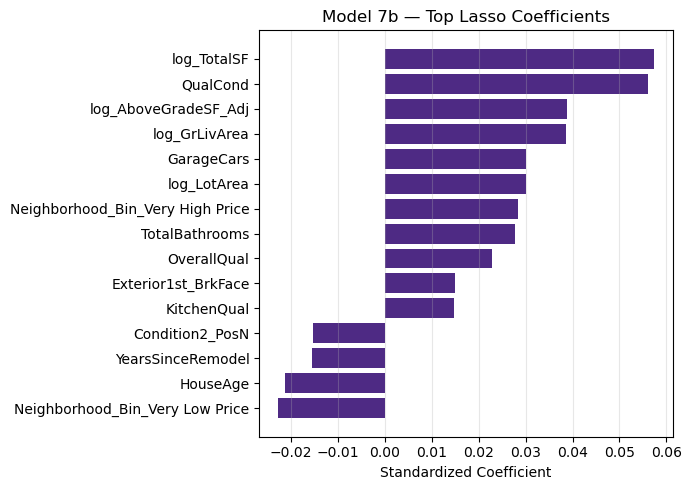

In [84]:
enet_coef_8a = model_8a.named_steps["reg"].coef_
enet_features_8a = X8a.columns

coef_8a_df = pd.DataFrame({
    "Feature": enet_features_8a,
    "Coefficient": enet_coef_8a,
    "Abs_Coefficient": np.abs(enet_coef_8a)
}).sort_values("Abs_Coefficient", ascending=False)

top_8a = coef_8a_df[coef_8a_df["Coefficient"] != 0].head(15)[["Feature", "Coefficient"]].round(6)

display(
    nu_style_table(
        top_8a,
        caption="Model 8a — Top Non-Zero Coefficients (ElasticNet)"
    )
)


top_plot_8a = coef_8a_df.head(15).copy()
top_plot_8a = top_plot_8a.sort_values("Coefficient")

plt.figure(figsize=(7, 5))
plt.barh(top_plot_8a["Feature"], top_plot_8a["Coefficient"], color=nu_purple)
plt.xlabel("Standardized Coefficient")
plt.title("Model 7b — Top Lasso Coefficients")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

The non-zero coefficients again emphasize size, quality, and neighborhood tiers. ElasticNet keeps a small set of important predictors, but with the full feature space it still does not generalize consistently across folds.

#### Model 8b: ElasticNet Regression (Selected Feature Set)
Model 8b applies ElasticNet using the same enhanced selected feature set used in Models 6b and 7b. Starting from a cleaner feature space reduces noise and allows ElasticNet to focus on meaningful predictors.

ElasticNet combines Ridge and Lasso penalties. It can shrink correlated coefficients like Ridge while also setting weak coefficients to zero like Lasso. This makes it a good compromise when predictors are correlated but some feature selection is still helpful. As with the other regularized models, predictors are standardized in a pipeline, the model is trained on log(SalePrice), and all results are reported back in dollar scale.

##### Hyperparameter Tuning
For Model 8b, both alpha (overall regularization strength) and l1_ratio (balance between Ridge and Lasso) are tuned using five-fold cross-validation. The goal is to find a balance between stability and sparsity that minimizes cross-validated RMSE.

In [85]:
# ----------------------------
# Use enhanced selected features
# ----------------------------
X8b = X_sel_enhanced.copy()
X8b = X8b.fillna(X8b.median(numeric_only=True))

y8b = y_log_enhanced.copy()

# ----------------------------
# Train–Validation split
# ----------------------------
X8b_train, X8b_val, y8b_train, y8b_val = train_test_split(
    X8b, y8b, test_size=0.2, random_state=42
)

# ----------------------------
# ElasticNet pipeline
# ----------------------------
enet_pipe_8b = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", ElasticNet(max_iter=20000))
])

enet_grid_8b = {
    "reg__alpha": np.logspace(-4, 1, 30),
    "reg__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
}

enet_search_8b = GridSearchCV(
    enet_pipe_8b,
    enet_grid_8b,
    cv=cv,
    scoring=scoring,
    refit="rmse",
    n_jobs=-1
)

enet_search_8b.fit(X8b_train, y8b_train)

model_8b = enet_search_8b.best_estimator_
best_params_8b = enet_search_8b.best_params_

print("Best params (8b):", best_params_8b)

Best params (8b): {'reg__alpha': 0.011721022975334805, 'reg__l1_ratio': 0.1}


##### ElasticNet Tuning Curve

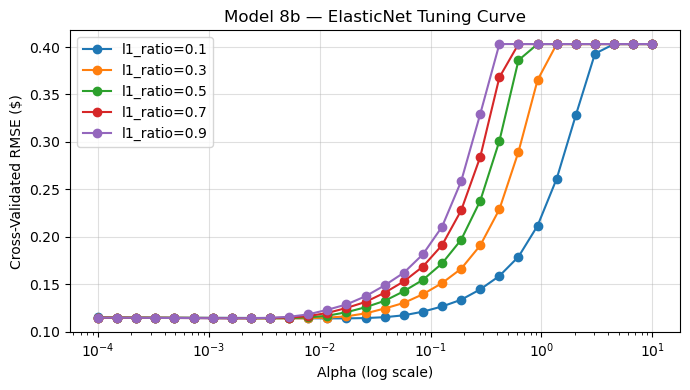

In [86]:
enet_tuning_df_8b = pd.DataFrame({
    "alpha": enet_search_8b.cv_results_["param_reg__alpha"].astype(float),
    "l1_ratio": enet_search_8b.cv_results_["param_reg__l1_ratio"].astype(float),
    "CV RMSE": -enet_search_8b.cv_results_["mean_test_rmse"],
})

plt.figure(figsize=(7, 4))

for lr in sorted(enet_tuning_df_8b["l1_ratio"].unique()):
    tmp = enet_tuning_df_8b[enet_tuning_df_8b["l1_ratio"] == lr].sort_values("alpha")
    plt.plot(tmp["alpha"], tmp["CV RMSE"], marker="o", label=f"l1_ratio={lr}")

plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Cross-Validated RMSE ($)")
plt.title("Model 8b — ElasticNet Tuning Curve")
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

The tuning curve shows how RMSE changes as alpha increases for different l1_ratio values. Performance is best at small to moderate alpha values, and gets worse when regularization becomes too strong. The different curves help show how the Ridge–Lasso mix affects model performance.

##### Model 8b Performance

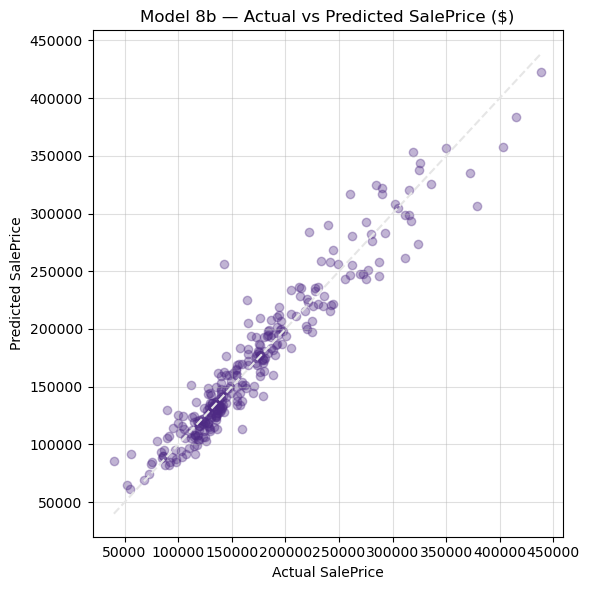

In [87]:
# Predict on holdout (log scale)
y8b_val_pred_log = model_8b.predict(X8b_val)

# Convert back to dollars
m8b = evaluate_dollar_scale(y8b_val, y8b_val_pred_log)

model_8b_holdout = pd.DataFrame({
    "Model": ["Model 8b: ElasticNet (selected features)"],
    "Val RMSE ($)": [m8b["RMSE ($)"]],
    "Val R² ($)":   [m8b["R² ($)"]],
    "Best alpha":   [best_params_8b["reg__alpha"]],
    "Best l1_ratio":[best_params_8b["reg__l1_ratio"]],
}).round(4)

model_8b_cv = cv_summary_dollar_from_log_target(
    Pipeline([
        ("scaler", StandardScaler()),
        ("reg", ElasticNet(
            alpha=best_params_8b["reg__alpha"],
            l1_ratio=best_params_8b["reg__l1_ratio"],
            max_iter=20000
        ))
    ]),
    X8b,
    np.expm1(y8b),
    "Model 8b: ElasticNet (selected features)"
)

display_side_by_side(
    nu_style_table(model_8b_holdout, "Model 8b — Holdout Performance (Dollar Scale)"),
    nu_style_table(model_8b_cv,      "Model 8b — Cross-Validation Performance (Dollar Scale)")
)

plot_actual_vs_pred(
    np.expm1(y8b_val),
    np.expm1(y8b_val_pred_log),
    "Model 8b — Actual vs Predicted SalePrice ($)"
)

Model 8b performs very similarly to Models 6b and 7b. The holdout RMSE is about 18.9K with an R² around 0.92, and the cross-validation results are close, with a CV RMSE around 22.9K and CV R² around 0.92. The small gap between holdout and CV results suggests the model generalizes well.

Overall, ElasticNet does not clearly beat Ridge in this case. Since the selected feature set is already clean and informative, Ridge’s smooth coefficient shrinkage appears sufficient. Adding Lasso-style sparsity through ElasticNet does not provide a noticeable improvement here.

##### Top Non-Zero Coefficients (Feature Importance)
ElasticNet can shrink some coefficients exactly to zero. Feature importance is therefore examined using the non-zero standardized coefficients.

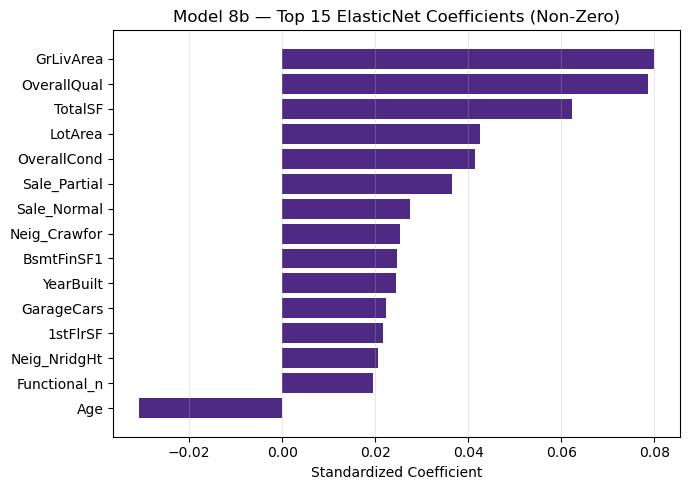

Number of non-zero coefficients (8b): 55


In [88]:
enet_coef_8b = model_8b.named_steps["reg"].coef_
enet_features_8b = X8b.columns

coef_8b_df = pd.DataFrame({
    "Feature": enet_features_8b,
    "Coefficient": enet_coef_8b
})

coef_8b_nonzero = coef_8b_df[coef_8b_df["Coefficient"].abs() > 1e-8].copy()
coef_8b_nonzero["Abs_Coefficient"] = coef_8b_nonzero["Coefficient"].abs()
coef_8b_nonzero = coef_8b_nonzero.sort_values("Abs_Coefficient", ascending=False)

top_8b = coef_8b_nonzero.head(15)[["Feature", "Coefficient"]].round(6)

display(
    nu_style_table(
        top_8b,
        caption="Model 8b — Top Non-Zero Coefficients (ElasticNet)"
    )
)

top_plot_8b = coef_8b_nonzero.head(15).copy()
top_plot_8b = top_plot_8b.sort_values("Coefficient")

plt.figure(figsize=(7, 5))
plt.barh(top_plot_8b["Feature"], top_plot_8b["Coefficient"], color=nu_purple)
plt.xlabel("Standardized Coefficient")
plt.title("Model 8b — Top 15 ElasticNet Coefficients (Non-Zero)")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

print("Number of non-zero coefficients (8b):", coef_8b_nonzero.shape[0])

The non-zero coefficients show the same pattern seen in Ridge and Lasso. Size and quality features are still the most important drivers of price, followed by lot size, basement space, and neighborhood effects. Age-related variables have negative coefficients, which means older homes tend to sell for less.

ElasticNet keeps 55 non-zero coefficients, so it does not shrink the model as aggressively as Lasso. This suggests ElasticNet leans more toward Ridge behavior in this case, keeping more predictors while still applying regularization to improve stability and generalization.

## Model Comparison and Selection
After fitting all models, I compare them using 5-fold cross-validated RMSE in dollars. Cross-validation is more reliable than a single holdout split because it averages results across multiple folds.

Some models are trained directly on SalePrice ($), while others are trained on log1p(SalePrice). For fair comparison, I convert all predictions back to dollars using expm1, then report RMSE in dollars. The goal is to pick a model that generalizes well and gives accurate dollar predictions, not just a model that performs well on one split.

In [89]:
X_enh_train = X_enhanced.iloc[:ntrain_enhanced].copy().reset_index(drop=True)
y_enh_dollar = train_raw["SalePrice"].astype(float).reset_index(drop=True)

comparison = pd.concat([
    # --------------------------
    # Dollar-target models
    # --------------------------
    cv_summary_dollar_from_dollar_target(model_1, X,  y,  "Model 1: Baseline"),
    cv_summary_dollar_from_dollar_target(model_2, X2, y2, "Model 2: Engineered"),

    # --------------------------
    # Log-target OLS models (evaluated back in $)
    # --------------------------
    cv_summary_dollar_from_log_target(model_3, X3, df_hencoded["SalePrice"], "Model 3: Polynomial"),
    cv_summary_dollar_from_log_target(model_4, X4, df_hencoded["SalePrice"], "Model 4: Optimized OLS"),

    # --------------------------
    # Enhanced OLS model (Model 5)
    # --------------------------
    cv_summary_dollar_from_log_target(
    model_5,
    X_enh_train,
    y_enh_dollar,
    "Model 5: Outlier-Controlled Engineered"
    ),
    
    # --------------------------
    # Regularized models (all features) — original encoded
    # --------------------------
    cv_summary_dollar_from_log_target(model_6a, X6a, df_hencoded["SalePrice"], "Model 6a: Ridge (all features)"),
    cv_summary_dollar_from_log_target(model_7a, X7a, df_hencoded["SalePrice"], "Model 7a: Lasso (all features)"),
    cv_summary_dollar_from_log_target(model_8a, X8a, df_hencoded["SalePrice"], "Model 8a: ElasticNet (all features)"),

    # --------------------------
    # Regularized models (selected features) — enhanced selected set
    # --------------------------
    cv_summary_dollar_from_log_target(model_6b, X6b, np.expm1(y_log_enhanced), "Model 6b: Ridge (selected features)"),
    cv_summary_dollar_from_log_target(model_7b, X7b, np.expm1(y_log_enhanced), "Model 7b: Lasso (selected features)"),
    cv_summary_dollar_from_log_target(model_8b, X8b, np.expm1(y_log_enhanced), "Model 8b: ElasticNet (selected features)"),
], ignore_index=True)

# ----------------------------------------------------------
# Rank models by CV RMSE ($)
# ----------------------------------------------------------
rmse_col = "CV RMSE ($) (mean)"
comparison[rmse_col] = (
    pd.to_numeric(comparison[rmse_col], errors="coerce")
      .replace([np.inf, -np.inf], np.nan)
)

comparison["RMSE Rank"] = (
    comparison[rmse_col]
    .rank(method="min", ascending=True)
    .astype("Int64")
)

comparison = comparison.sort_values(rmse_col).reset_index(drop=True)

display(
    nu_style_table(
        comparison,
        caption="Model Comparison — Cross-Validation Performance (Dollar Scale)"
    )
)

# ----------------------------------------------------------
# Best model
# ----------------------------------------------------------
best_row = comparison.iloc[0]
best_model_name = best_row["Model"]

print(f"\n BEST MODEL (by lowest CV RMSE $): {best_model_name}")
print(f"   CV RMSE ($): {best_row['CV RMSE ($) (mean)']:.2f}")
print(f"   CV R² ($):   {best_row['CV R² ($) (mean)']:.4f}")


 BEST MODEL (by lowest CV RMSE $): Model 5: Outlier-Controlled Engineered
   CV RMSE ($): 22746.46
   CV R² ($):   0.9165


When I look at the ranking table, the pattern is clear. Models with stronger preprocessing (log target, feature engineering, and outlier control) perform much better than the baseline. The versions that use all encoded features (Models 6a, 7a, and 8a) rank near the bottom, showing that regularization alone cannot fully fix a large and noisy feature space.

At the top, the results are very close. Model 5 (Outlier-Controlled Engineered) has the lowest cross-validated RMSE, meaning it gives the most accurate dollar-level predictions on average. The selected-feature regularized models (6b, 7b, and 8b) follow closely behind with very similar performance.

Since model selection is based on lowest CV RMSE in dollars, Model 5 is chosen as the best overall model. However, Models 6b–8b are strong alternatives and confirm that combining cleaner features with regularization leads to stable and reliable results.

### Generate predictions and save submissions for all models

In [90]:
# ==========================================================
# Generate predictions and save submissions for ALL models
# ==========================================================

rmse_col = "CV RMSE ($) (mean)"
if rmse_col not in comparison.columns:
    raise ValueError(f"comparison must include '{rmse_col}' column.")

display(
    nu_style_table(
        comparison[["Model", rmse_col, "CV R² ($) (mean)", "RMSE Rank"]],
        caption="All Models — Ranked by CV RMSE ($)"
    )
)

# ----------------------------------------------------------
# Model registry 
# ----------------------------------------------------------
model_registry = {
    "Model 1: Baseline": {
        "model": model_1,
        "X_cols": X.columns,
        "log_target": False,
        "test_source": "encoded"  
    },
    "Model 2: Engineered": {
        "model": model_2,
        "X_cols": X2.columns,
        "log_target": False,
        "test_source": "encoded"
    },
    "Model 3: Polynomial": {
        "model": model_3,
        "X_cols": X3.columns,
        "log_target": True,
        "test_source": "encoded"
    },
    "Model 4: Optimized OLS": {
        "model": model_4,
        "X_cols": X4.columns,
        "log_target": True,
        "test_source": "encoded"
    },

    "Model 5: Outlier-Controlled Engineered": {
        "model": model_5,
        "X_cols": X_train_enhanced.columns,   
        "log_target": True,                  
        "test_source": "enhanced"        
    },


    "Model 6a: Ridge (all features)": {
        "model": model_6a,
        "X_cols": X6a.columns,
        "log_target": True,
        "test_source": "encoded"
    },
    "Model 7a: Lasso (all features)": {
        "model": model_7a,
        "X_cols": X7a.columns,
        "log_target": True,
        "test_source": "encoded"
    },
    "Model 8a: ElasticNet (all features)": {
        "model": model_8a,
        "X_cols": X8a.columns,
        "log_target": True,
        "test_source": "encoded"
    },

    "Model 6b: Ridge (selected features)": {
        "model": model_6b,
        "X_cols": X6b.columns,
        "log_target": True,
        "test_source": "enhanced_selected"  
    },
    "Model 7b: Lasso (selected features)": {
        "model": model_7b,
        "X_cols": X7b.columns,
        "log_target": True,
        "test_source": "enhanced_selected"
    },
    "Model 8b: ElasticNet (selected features)": {
        "model": model_8b,
        "X_cols": X8b.columns,
        "log_target": True,
        "test_source": "enhanced_selected"
    },
}

# ----------------------------------------------------------
# Generate predictions + save Kaggle submissions (ALL models)
# ----------------------------------------------------------
saved_files = []

for model_name in comparison["Model"]:
    if model_name not in model_registry:
        print(f"Skipping {model_name} (not in registry)")
        continue

    info = model_registry[model_name]
    mdl = info["model"]
    cols = info["X_cols"]
    is_log = info["log_target"]
    test_source = info["test_source"]

    X_test_use = get_test_matrix(test_source, cols)

    preds = mdl.predict(X_test_use)

    # Convert back to dollars if trained on log(target)
    if is_log:
        preds = np.expm1(preds)

    preds = np.maximum(preds, 0)

    fname = save_submission(preds, model_name)
    saved_files.append((model_name, fname))

print("\nDone. Files created:")
for m, f in saved_files:
    print(f" - {m} → {f}")

Saved: output/submission_model_5_outlier_controlled_engineered.csv
Saved: output/submission_model_7b_lasso_selected_features.csv
Saved: output/submission_model_8b_elasticnet_selected_features.csv
Saved: output/submission_model_6b_ridge_selected_features.csv
Saved: output/submission_model_4_optimized_ols.csv
Saved: output/submission_model_3_polynomial.csv
Saved: output/submission_model_2_engineered.csv
Saved: output/submission_model_8a_elasticnet_all_features.csv
Saved: output/submission_model_7a_lasso_all_features.csv
Saved: output/submission_model_6a_ridge_all_features.csv
Saved: output/submission_model_1_baseline.csv

Done. Files created:
 - Model 5: Outlier-Controlled Engineered → output/submission_model_5_outlier_controlled_engineered.csv
 - Model 7b: Lasso (selected features) → output/submission_model_7b_lasso_selected_features.csv
 - Model 8b: ElasticNet (selected features) → output/submission_model_8b_elasticnet_selected_features.csv
 - Model 6b: Ridge (selected features) → outp

# Conclusion

In this project, I focused on understanding and preparing the Ames housing dataset before building regression models. The data analysis showed that house prices are right-skewed and include a small number of very expensive homes. Because of this, careful preprocessing, feature engineering, and handling of extreme values were important before modeling.

The exploratory analysis showed that SalePrice is mainly influenced by living area, construction quality, neighborhood, and time-related factors such as house age and remodeling history. Feature engineering helped make these relationships clearer by combining related variables into more meaningful features. For example, total finished basement area, total bathrooms, and house age provided more stable and interpretable information than the original raw variables.

Several regression models were built and compared using cross-validation. Model 1, the baseline linear regression, performed poorly and showed strong overfitting. Model 2 improved performance by using engineered features and neighborhood price bins. Model 3 added polynomial terms, but this increased complexity without improving generalization. Model 4 used a log-transformed target to improve stability and achieved strong explanatory performance. Model 5 applied enhanced preprocessing and stronger outlier control, and achieved the lowest cross-validated RMSE in dollar terms.

Regularized regression models were then introduced to address multicollinearity and overfitting. Ridge regression (Model 6) improved coefficient stability, especially when applied to a selected feature set. Lasso regression (Model 7) simplified the model by removing weak predictors, but this sparsity slightly reduced predictive accuracy. ElasticNet regression (Model 8) balanced shrinkage and feature selection, producing stable and interpretable results, though it did not outperform the best linear model.

From my experience working with real-world data, I found that good results rarely come from a single modeling attempt. I iterated through multiple preprocessing strategies, feature engineering choices, and model versions until the results became both stable and accurate. This process showed that improving the data representation had a larger impact than adding more complex models.

Based on cross-validation results, Model 5 (Outlier-Controlled Engineered Linear Regression) was selected as the final model due to its lowest prediction error in dollar scale. Overall, the results confirm that thoughtful preprocessing, strong feature engineering, and careful handling of extreme values are more important than model complexity. Understanding the data and refining it step by step are essential for building reliable and interpretable regression models.

# Answers to Assignment Questions (Management Questions)

From my experience working with data and analytics projects, this assignment strongly reinforces that preprocessing decisions often have a greater impact on model performance than the choice of algorithm itself. This project demonstrates how careful exploratory data analysis and thoughtful data preparation directly shape the quality, stability, and reliability of predictive results.

The main objective of this project is to identify which factors most strongly influence house prices in Ames, Iowa, while showing why proper data preparation is essential for producing trustworthy insights. Housing price predictions are used in important financial decisions such as buying, selling, lending, and investing. Inaccurate estimates can lead to overpricing, financial loss, or increased risk, making model reliability especially important.

Several stakeholder groups benefit from accurate housing price analysis. Home buyers and sellers rely on fair valuations to make informed decisions. Real estate professionals use pricing insights to guide listings and negotiations. Mortgage lenders and financial institutions depend on reliable estimates to assess credit risk. Investors and developers analyze housing features to guide investment strategies, while planners and policymakers use housing data to study affordability and growth trends. From a data science perspective, the Ames housing dataset popularized through the Kaggle House Prices: Advanced Regression Techniques competition is widely used as a benchmark for learning regression modeling, preprocessing, and feature engineering techniques (De Cock 2011; Montoya and DataCanary 2016).

This project highlights the importance of understanding what the data represent rather than treating preprocessing as a mechanical step. The analysis shows that house prices are influenced by a combination of living space, construction quality, neighborhood, and age-related factors. Feature engineering helped clarify these relationships by aggregating raw variables into more meaningful measures, such as total living area and house age, which aligns with best practices in statistical learning (James et al. 2013).

The modeling results further demonstrate that preprocessing choices—such as handling missing values based on domain meaning and controlling extreme values—can improve performance more than adding polynomial complexity. This finding is consistent with established machine learning research emphasizing interpretability and robust preprocessing (Hastie, Tibshirani, and Friedman 2009).

From my experience, reaching these results required testing multiple versions of preprocessing and feature engineering rather than relying on a single approach. I iteratively adjusted how missing values, outliers, transformations, and engineered features were handled, and evaluated each version using cross-validation. This process helped identify which data preparation choices consistently improved performance and which ones added unnecessary complexity. The final results reflect this iterative refinement, showing that careful experimentation with preprocessing can lead to meaningful gains in predictive accuracy and model stability.

Future research could explore how these preprocessing strategies perform across different housing markets or price ranges. Applying similar methods to data from other cities would help evaluate how generalizable these findings are beyond the Ames dataset.

# References

De Cock, Dean. 2011. “Ames, Iowa: Alternative to the Boston Housing Data.” Journal of Statistics Education 19 (3).

Nordhausen, Klaus. “The Elements of Statistical Learning: Data Mining, Inference, and Prediction, Second Edition by Trevor Hastie, Robert Tibshirani, Jerome Friedman.” International Statistical Review 77, no. 3 (October 29, 2009): 482–482. https://doi.org/10.1111/j.1751-5823.2009.00095_18.x. 

James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. 2013. An Introduction to Statistical Learning: With Applications in R. New York: Springer.

“House Prices - Advanced Regression Techniques.” Kaggle. Accessed January 25, 2026. https://kaggle.com/competitions/house-prices-advanced-regression-techniques. 